# JAI SHREE RAM

## Description

In this project, I utilized LSTM networks to predict the stock prices of 12 different stocks by leveraging technical indicators such as RSI, VWAP, EMA, and MACD. By capturing trends and analyzing the historical performance of these stocks, I aimed to develop a model that could generate accurate predictions. These predictions were then used to create a risk-free portfolio that provides the expected return, optimizing investment strategies while minimizing potential risks.

## Importing necessary packages

In [24]:
import pandas as pd 
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
import matplotlib.patches as patches
import joblib
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tabulate import tabulate
from scipy.optimize import minimize
import ta 

## What was the change in price of the stock overtime?

In [25]:
# The tech stocks we'll use for this analysis
tech_list =['TCS.NS','NESTLEIND.NS','TITAN.NS','ASTRAL.BO','TATAPOWER.NS','SUZLON.NS',
            'HINDPETRO.BO','HDFCBANK.NS','INFY.NS','ULTRACEMCO.NS','MAHLIFE.BO','ADANIGREEN.BO']

# Set up End and Start times for data grab
end = dt.datetime.now()
start = dt.date(end.year - 10, end.month, end.day)

# Initialize an empty list to store stock data
stocks = []

for stock in tech_list:
    # Download stock data
    stock_data = yf.download(stock, start=start, end=end)
    
    # Add a column for the company name
    stock_data["company_name"] = stock
    
    # Append the DataFrame to the list
    stocks.append(stock_data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [26]:
type(stocks)

list

## Descriptive Statistics about the Data and Closing price

==================== TCS.NS Summary Statistics ====================

          Open     High      Low    Close  Adj Close       Volume
count  2464.00  2464.00  2464.00  2464.00    2464.00      2464.00
mean   2312.70  2335.01  2289.22  2311.96    2139.97   2665746.03
std     991.71   999.90   983.89   991.94    1024.37   2394438.82
min    1058.45  1070.00  1025.95  1050.57     898.00         0.00
25%    1290.11  1303.84  1277.52  1289.18    1084.92   1636799.75
50%    2083.50  2105.47  2060.00  2080.30    1881.40   2210644.50
75%    3280.24  3309.77  3252.29  3277.75    3135.71   3089539.75
max    4560.00  4592.25  4500.00  4553.75    4553.75  88067154.00




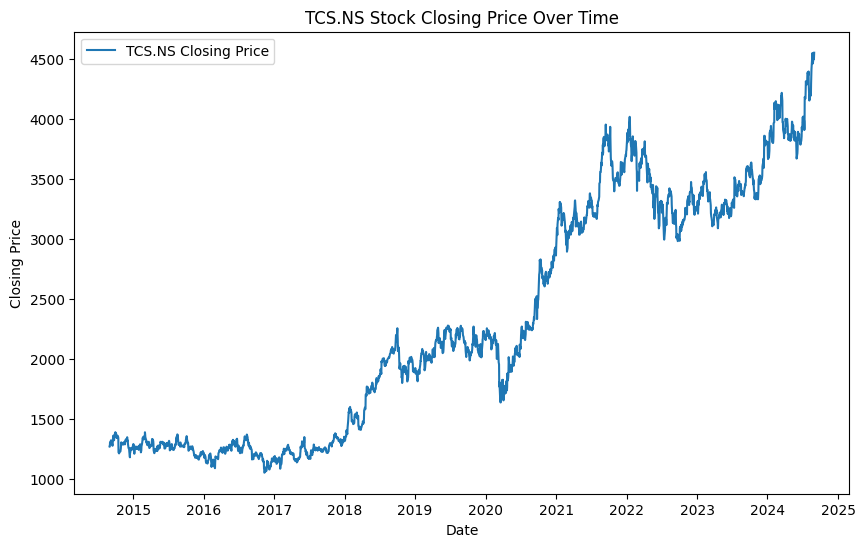

==================== NESTLEIND.NS Summary Statistics ====================

          Open     High      Low    Close  Adj Close       Volume
count  2464.00  2464.00  2464.00  2464.00    2464.00      2464.00
mean   1351.49  1364.72  1336.46  1350.43    1286.82    712613.62
std     645.14   649.87   639.00   644.46     662.95    658655.43
min     504.00   505.99   498.10   500.80     438.83         0.00
25%     683.00   689.16   675.91   681.40     600.75    345005.00
50%    1264.65  1283.91  1251.07  1269.01    1200.37    547145.00
75%    1859.99  1882.56  1844.30  1862.34    1817.99    858282.50
max    2754.00  2769.30  2702.41  2737.24    2717.75  11067460.00




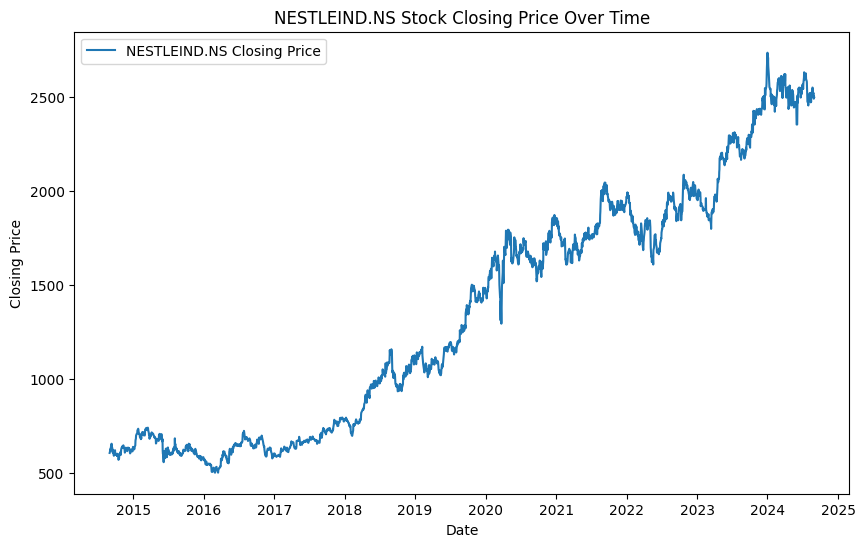

==================== TITAN.NS Summary Statistics ====================

          Open     High      Low    Close  Adj Close       Volume
count  2464.00  2464.00  2464.00  2464.00    2464.00      2464.00
mean   1413.98  1429.76  1396.06  1412.97    1390.38   1791805.96
std    1030.13  1038.70  1019.59  1029.07    1030.17   1763896.22
min     304.00   306.30   296.15   303.30     290.90         0.00
25%     441.78   447.44   436.06   441.59     422.70    842247.25
50%    1079.58  1094.28  1061.83  1079.05    1051.23   1317738.00
75%    2372.56  2398.65  2340.03  2372.89    2343.87   2164137.50
max    3882.00  3886.95  3800.00  3866.65    3854.04  27100101.00




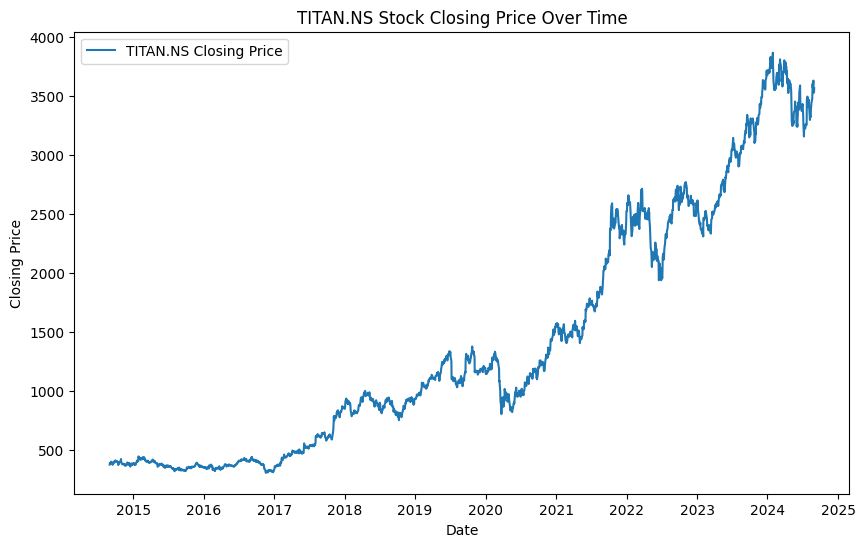

==================== ASTRAL.BO Summary Statistics ====================

          Open     High      Low    Close  Adj Close       Volume
count  2446.00  2446.00  2446.00  2446.00    2446.00      2446.00
mean    833.59   846.18   819.30   832.13     827.36     53167.14
std     655.62   664.39   646.01   654.70     653.95    722977.13
min     156.15   157.50   139.95   153.04     150.63        40.00
25%     226.51   233.09   223.09   228.31     224.77      4702.00
50%     542.73   552.65   531.97   539.69     534.75     10708.50
75%    1477.53  1498.85  1449.51  1477.58    1469.74     23530.75
max    2427.20  2453.95  2393.20  2416.10    2413.18  32108998.00




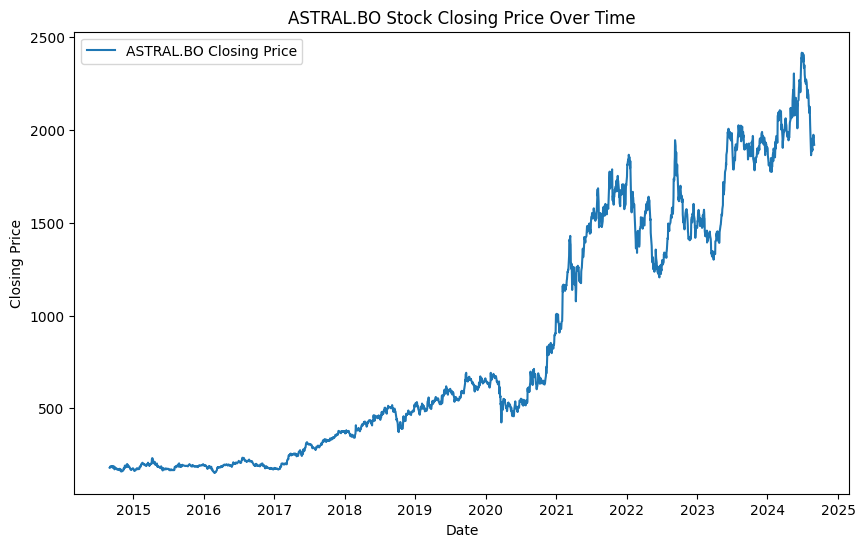

==================== TATAPOWER.NS Summary Statistics ====================

          Open     High      Low    Close  Adj Close        Volume
count  2464.00  2464.00  2464.00  2464.00    2464.00  2.464000e+03
mean    132.56   134.36   130.41   132.30     125.56  1.528454e+07
std     100.57   101.80    98.98   100.36     102.75  2.346618e+07
min      27.25    28.60    27.00    27.30      25.56  0.000000e+00
25%      70.00    70.95    68.74    69.88      60.47  3.986498e+06
50%      82.00    82.70    80.85    81.70      70.17  7.326536e+06
75%     207.65   209.75   205.60   207.71     204.83  1.730864e+07
max     461.60   471.00   454.05   464.40     464.40  3.606618e+08




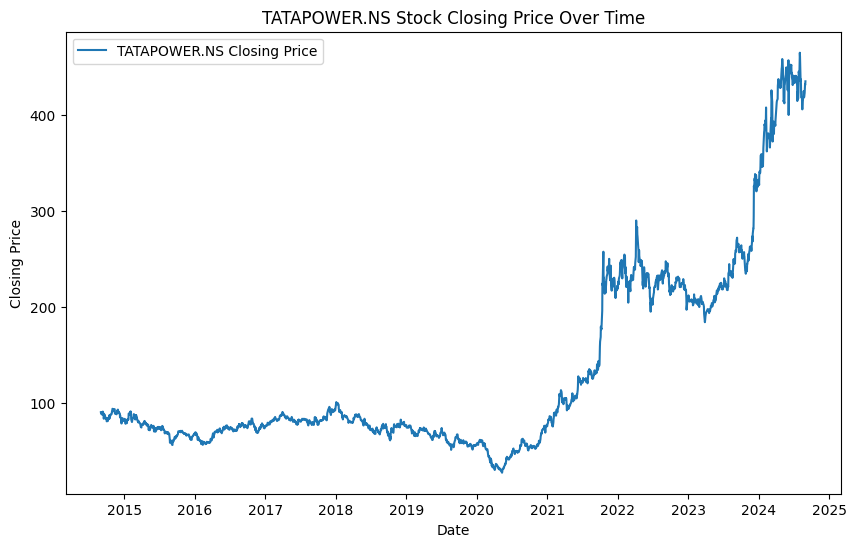

==================== SUZLON.NS Summary Statistics ====================

          Open     High      Low    Close  Adj Close        Volume
count  2464.00  2464.00  2464.00  2464.00    2464.00  2.464000e+03
mean     13.77    14.06    13.43    13.72      13.72  5.403929e+07
std      12.30    12.53    12.01    12.28      12.28  6.992858e+07
min       1.56     1.65     1.56     1.61       1.61  0.000000e+00
25%       5.78     5.92     5.65     5.78       5.78  1.871280e+07
50%      10.35    10.60    10.05    10.24      10.24  3.255264e+07
75%      17.17    17.41    16.86    17.04      17.04  5.947487e+07
max      82.19    84.29    79.21    80.79      80.79  8.115259e+08




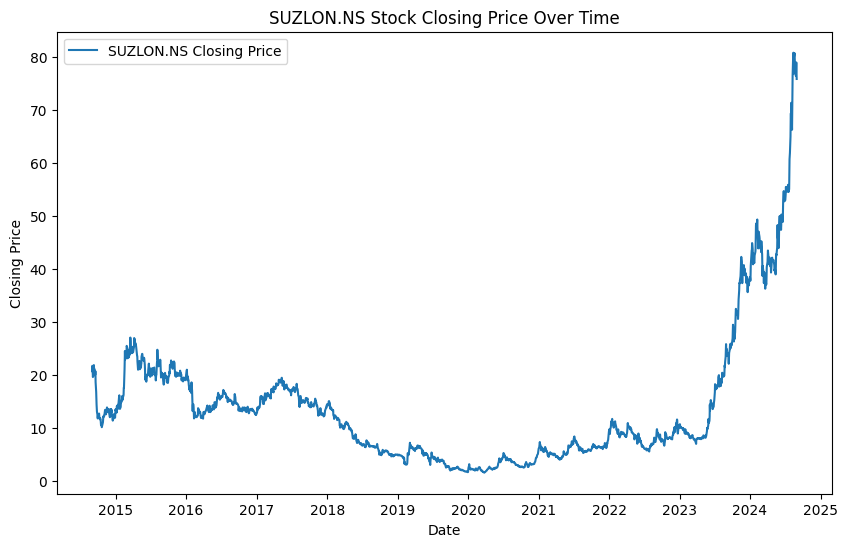

==================== HINDPETRO.BO Summary Statistics ====================

          Open     High      Low    Close  Adj Close       Volume
count  2462.00  2462.00  2462.00  2462.00    2462.00      2462.00
mean    182.40   185.33   179.15   182.09     131.40    641795.32
std      64.83    65.87    63.46    64.70      69.82    689411.81
min      68.15    69.34    66.67    68.14      22.04     14234.00
25%     141.65   144.16   139.35   141.43      98.58    262841.00
50%     171.27   173.60   168.83   171.07     128.50    453292.50
75%     206.00   209.62   202.19   206.08     156.23    788951.50
max     420.15   425.00   415.70   419.25     419.25  12977923.00




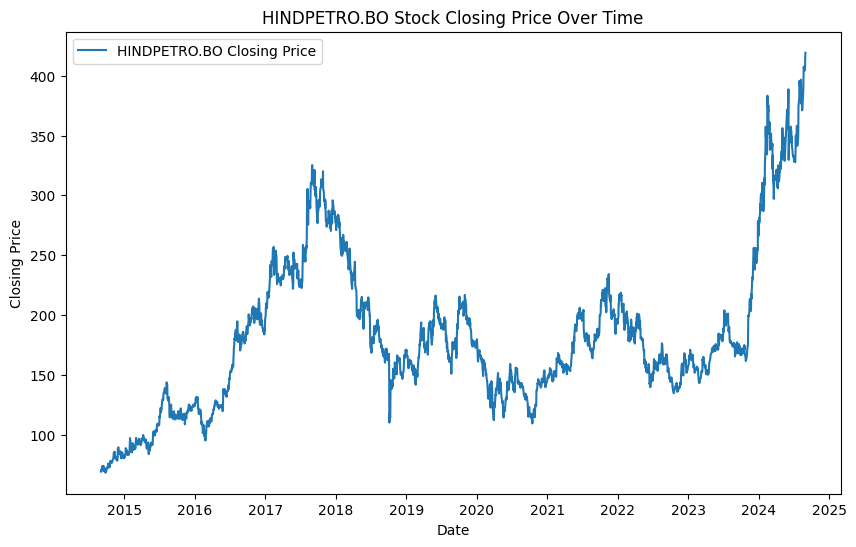

==================== HDFCBANK.NS Summary Statistics ====================

          Open     High      Low    Close  Adj Close        Volume
count  2464.00  2464.00  2464.00  2464.00    2464.00  2.464000e+03
mean   1097.90  1107.58  1087.59  1097.73    1056.39  8.372154e+06
std     400.07   403.48   396.58   399.95     400.79  1.002532e+07
min     421.55   424.50   419.30   420.60     389.07  0.000000e+00
25%     700.98   708.98   693.44   698.97     656.78  2.984017e+06
50%    1096.95  1106.51  1083.76  1094.20    1048.22  5.454772e+06
75%    1483.96  1495.14  1467.18  1482.65    1436.74  1.029808e+07
max    1791.00  1794.00  1764.65  1768.65    1768.65  2.226710e+08




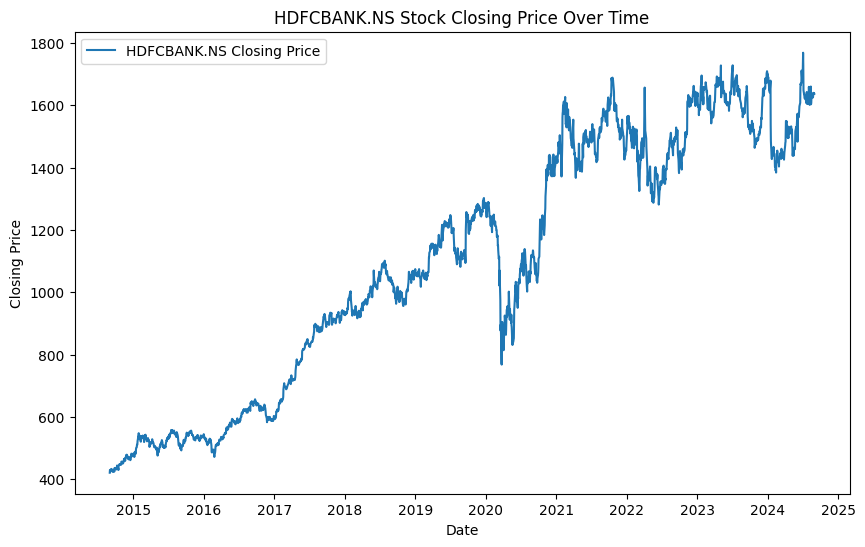

==================== INFY.NS Summary Statistics ====================

          Open     High      Low    Close  Adj Close        Volume
count  2464.00  2464.00  2464.00  2464.00    2464.00  2.464000e+03
mean    960.06   969.51   950.19   959.84     883.42  8.228004e+06
std     464.69   468.42   460.67   464.68     480.85  7.523398e+06
min     440.00   443.80   430.00   436.70     353.45  0.000000e+00
25%     549.50   554.99   541.19   548.67     442.60  5.068403e+06
50%     730.00   736.68   724.05   730.45     646.43  6.676416e+06
75%    1436.09  1449.14  1424.95  1435.11    1401.21  9.089553e+06
max    1938.55  1953.90  1930.50  1943.70    1943.70  1.663204e+08




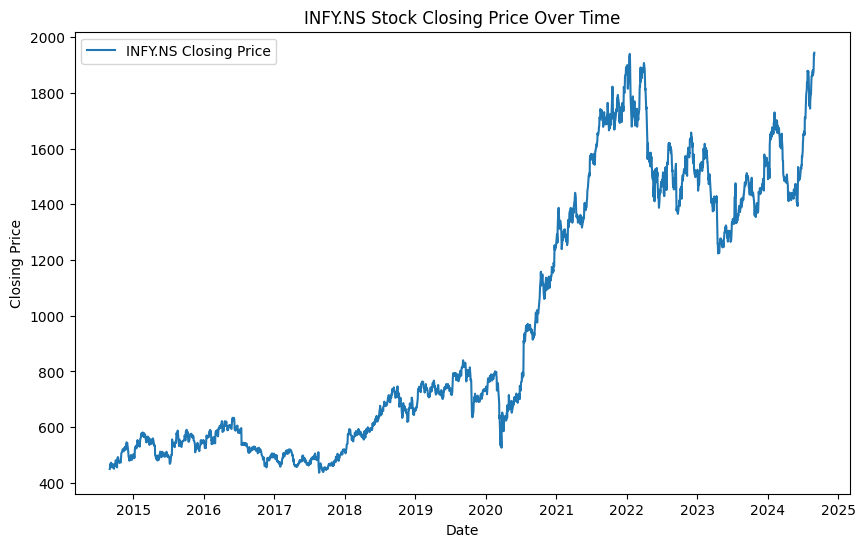

==================== ULTRACEMCO.NS Summary Statistics ====================

           Open      High       Low     Close  Adj Close      Volume
count   2464.00   2464.00   2464.00   2464.00    2464.00     2464.00
mean    5199.47   5256.13   5136.30   5193.99    5094.14   383109.17
std     2219.79   2236.74   2198.58   2217.39    2229.80   299390.38
min     2320.10   2355.05   2297.20   2317.60    2232.02        0.00
25%     3691.75   3744.71   3654.45   3696.26    3587.87   213487.00
50%     4199.25   4243.50   4153.53   4194.00    4082.61   303772.00
75%     6835.97   6909.10   6747.00   6824.21    6726.48   466350.75
max    11944.00  12078.00  11803.50  11984.50   11984.50  5134859.00




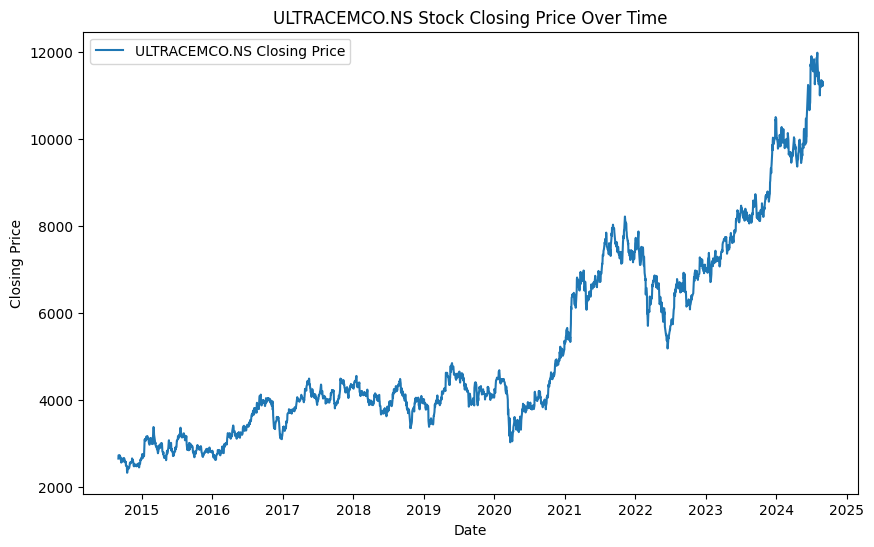

==================== MAHLIFE.BO Summary Statistics ====================

          Open     High      Low    Close  Adj Close      Volume
count  2444.00  2444.00  2444.00  2444.00    2444.00     2444.00
mean    230.12   234.21   225.99   229.62     217.12    24196.22
std     152.12   154.86   149.43   151.68     157.24   100904.71
min      57.73    59.68    57.07    58.33      57.81       39.00
25%     136.83   138.76   134.78   136.50     120.08     4593.75
50%     155.67   157.86   153.33   155.29     131.18     9427.50
75%     287.39   295.10   280.51   284.27     281.70    18677.50
max     679.15   679.15   660.55   669.35     666.41  2663919.00




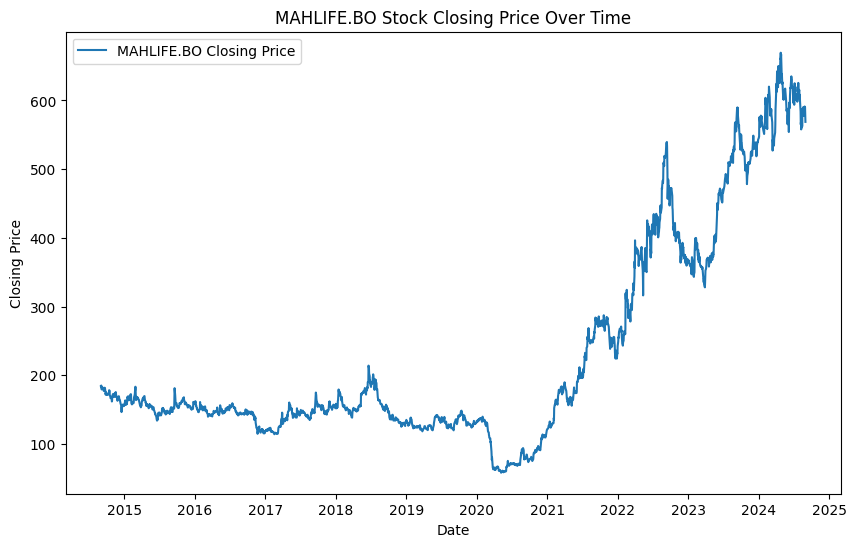

==================== ADANIGREEN.BO Summary Statistics ====================

          Open     High      Low    Close  Adj Close       Volume
count  1509.00  1509.00  1509.00  1509.00    1509.00      1509.00
mean    974.13   993.56   950.52   970.98     970.98    230149.56
std     772.98   788.85   753.06   769.10     769.10   1655876.99
min      24.65    26.35    22.75    25.05      25.05      4020.00
25%     136.90   139.00   134.95   137.75     137.75     37707.00
50%     976.45   990.50   955.00   973.95     973.95     74373.00
75%    1740.25  1783.20  1703.00  1736.80    1736.80    165488.00
max    3037.00  3048.00  2850.00  2968.10    2968.10  48320150.00




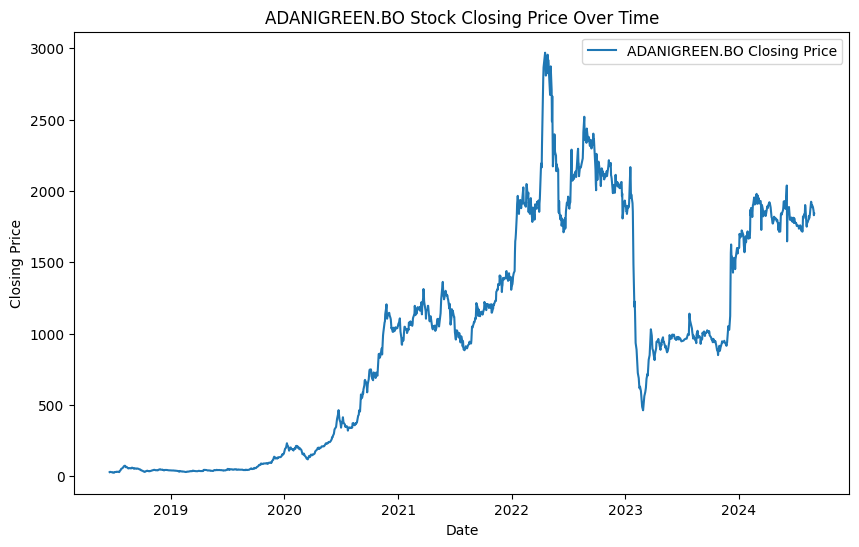

In [27]:
# Loop through each stock DataFrame in the stocks list and print the describe output
for stock_df in stocks:
    company_name = stock_df['company_name'].iloc[0]
    
    print(f"{'='*20} {company_name} Summary Statistics {'='*20}\n")
    print(stock_df.describe().round(2))  # Round the output for a cleaner look
    print("\n" + "="*60 + "\n")  # Add separation between outputs
    
    # Optional: Plotting the closing price to visualize the trend
    plt.figure(figsize=(10, 6))
    plt.plot(stock_df['Close'], label=f"{company_name} Closing Price")
    plt.title(f"{company_name} Stock Closing Price Over Time")
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.legend()
    plt.show()


## Volume of Sales¶

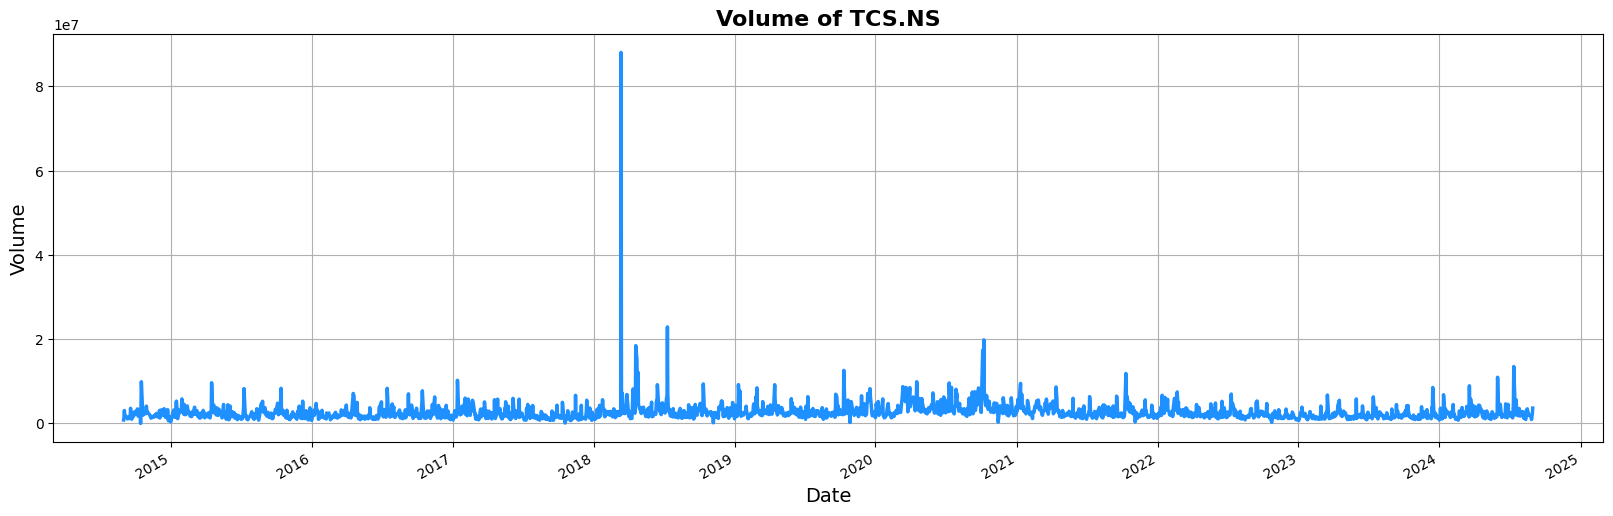

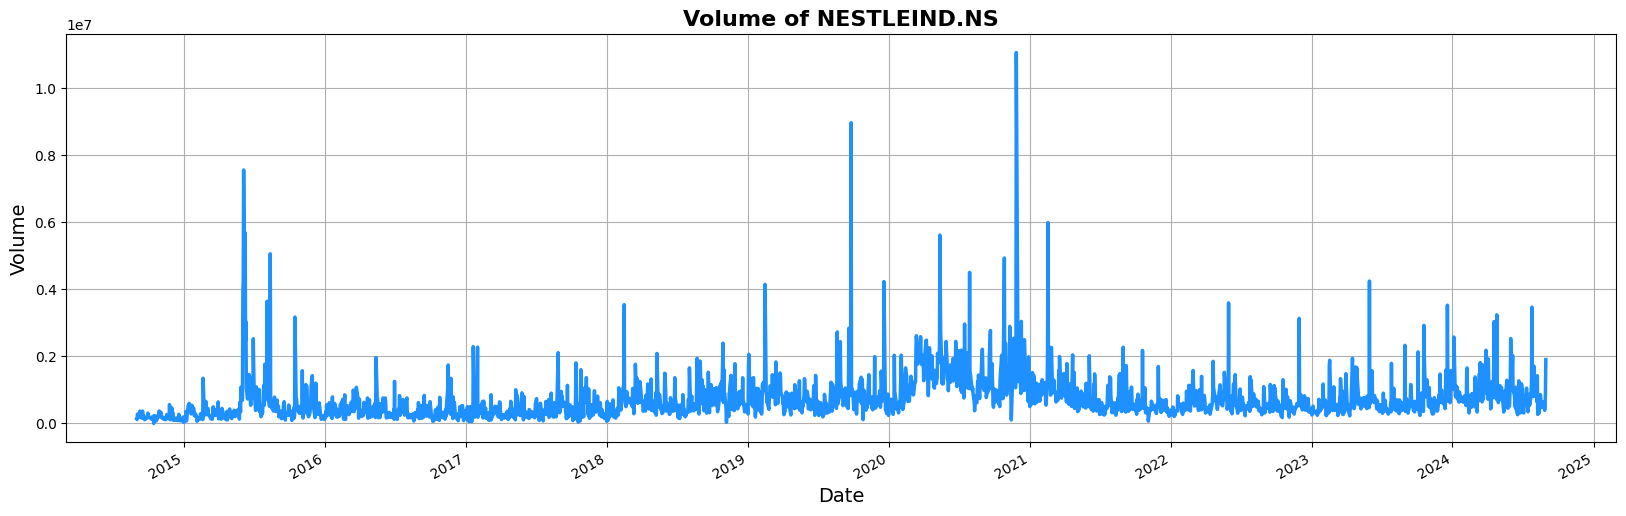

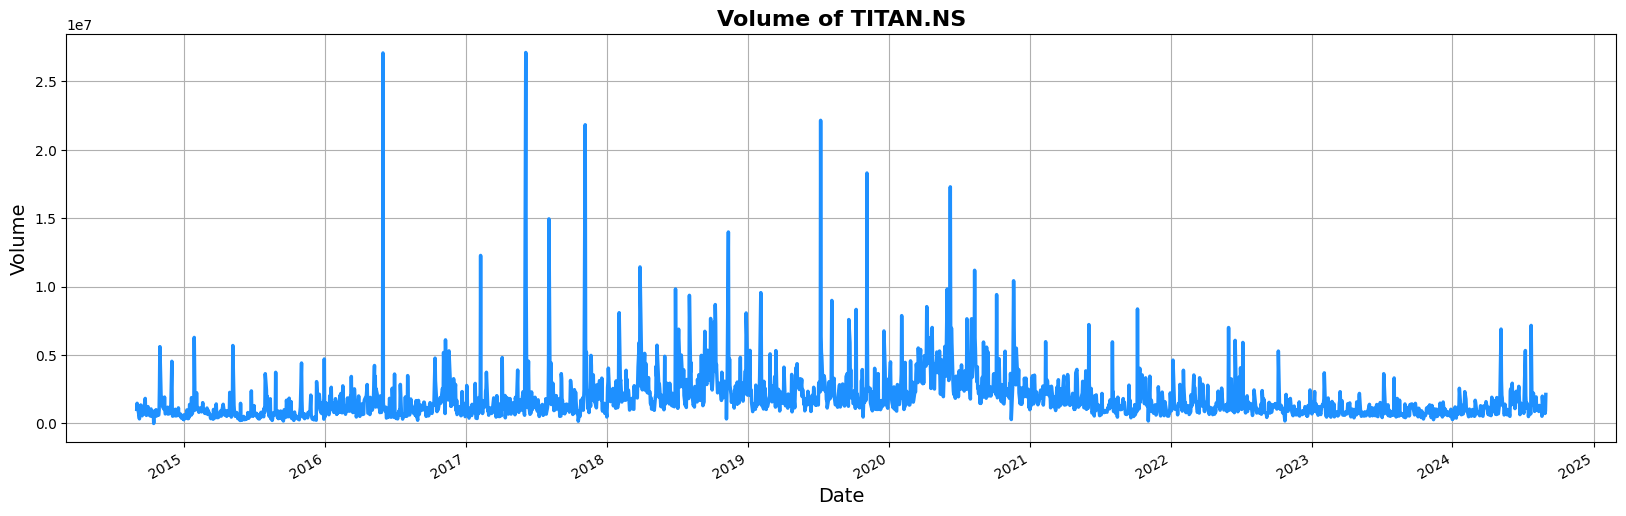

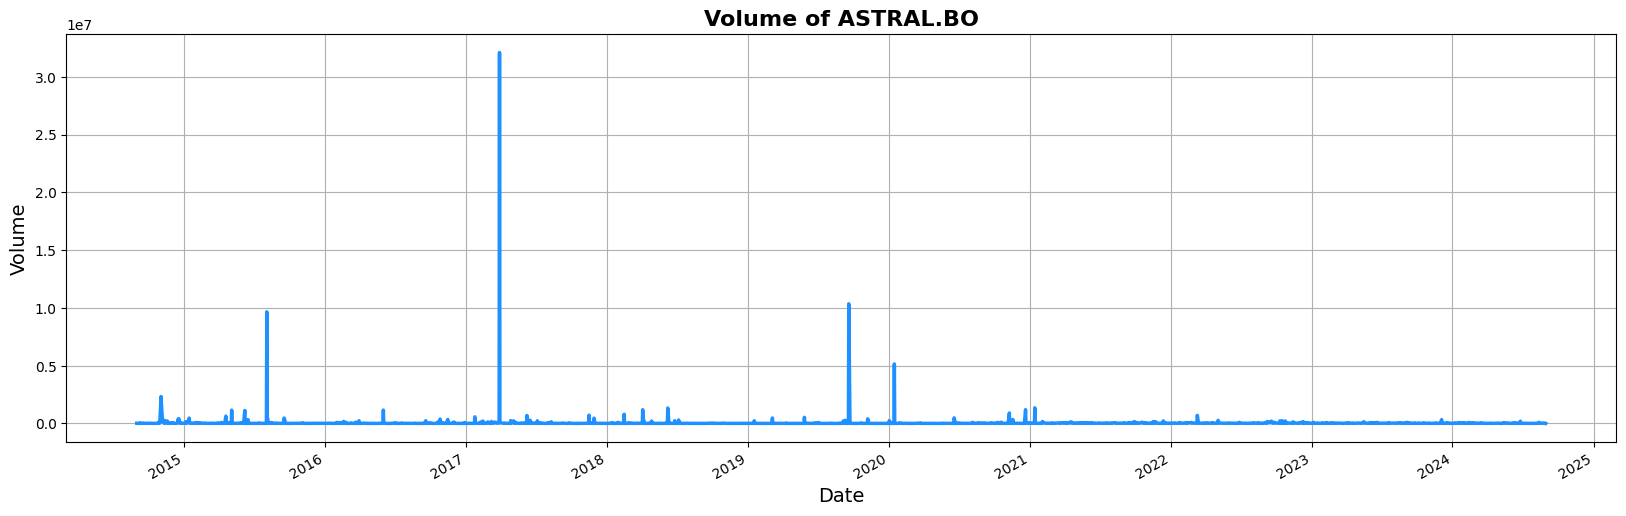

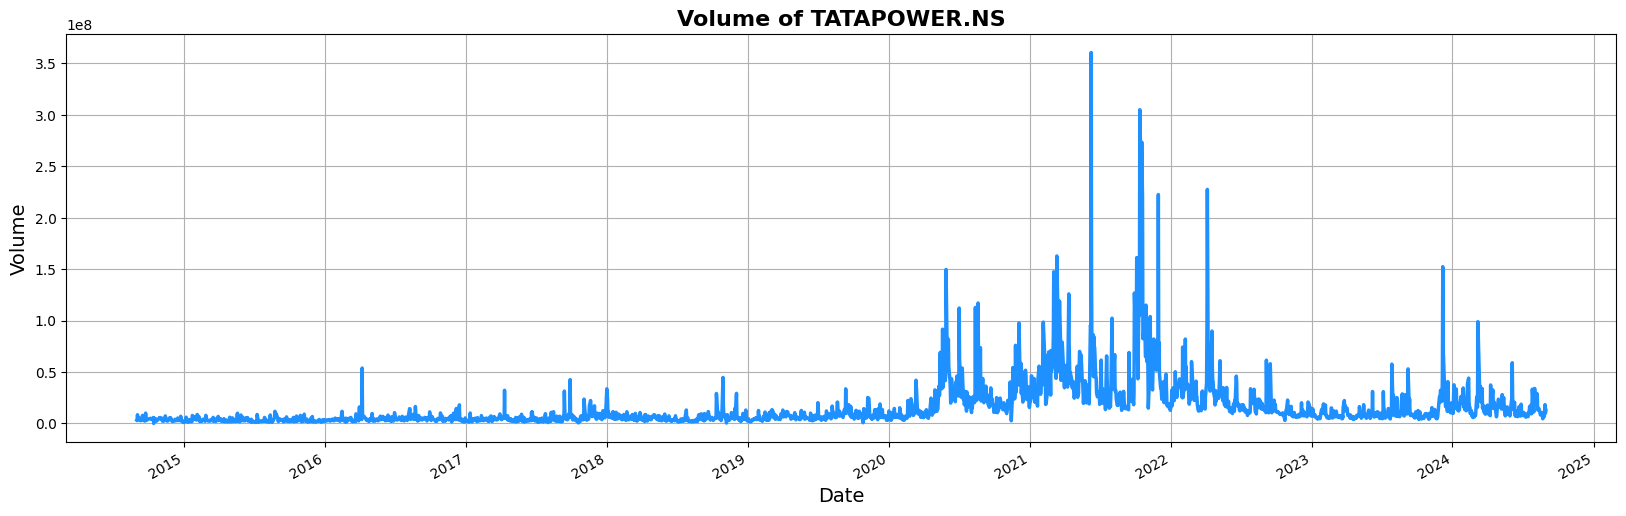

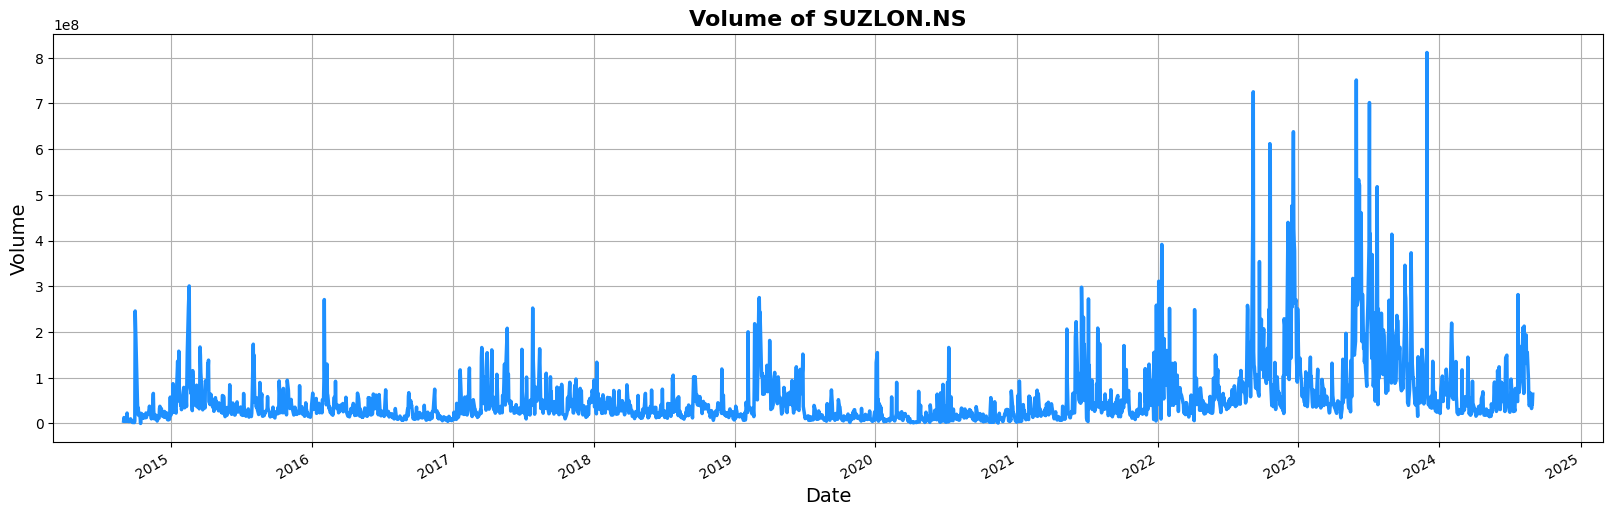

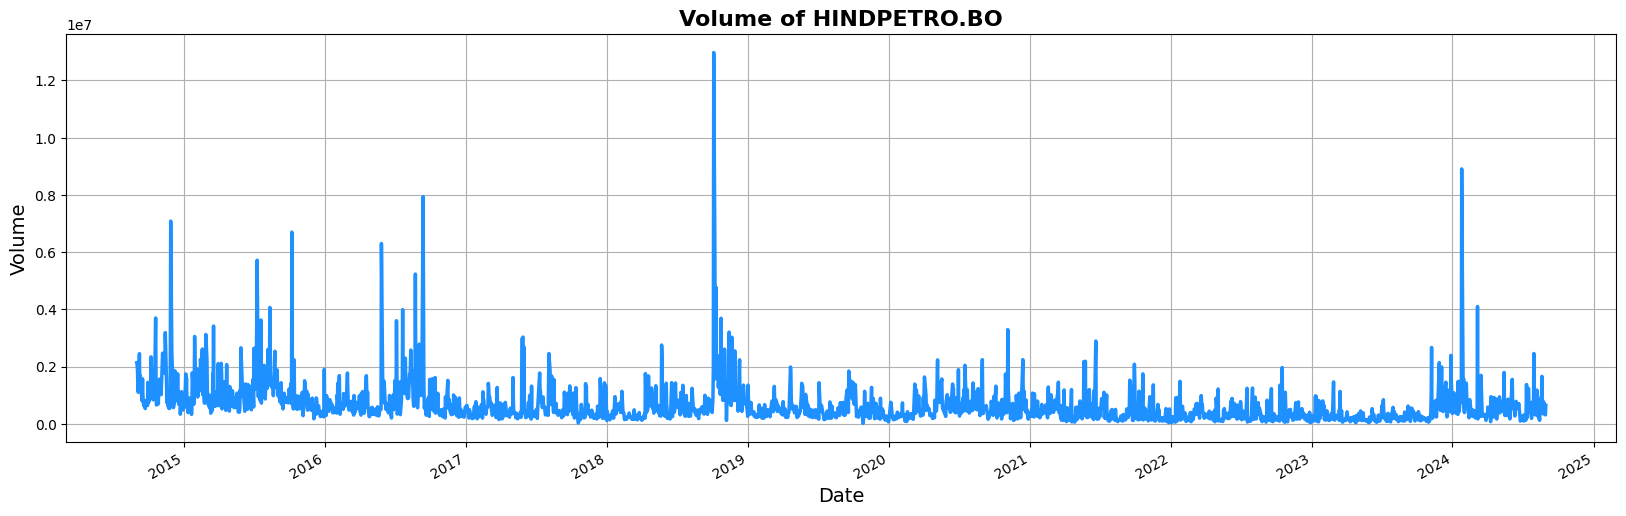

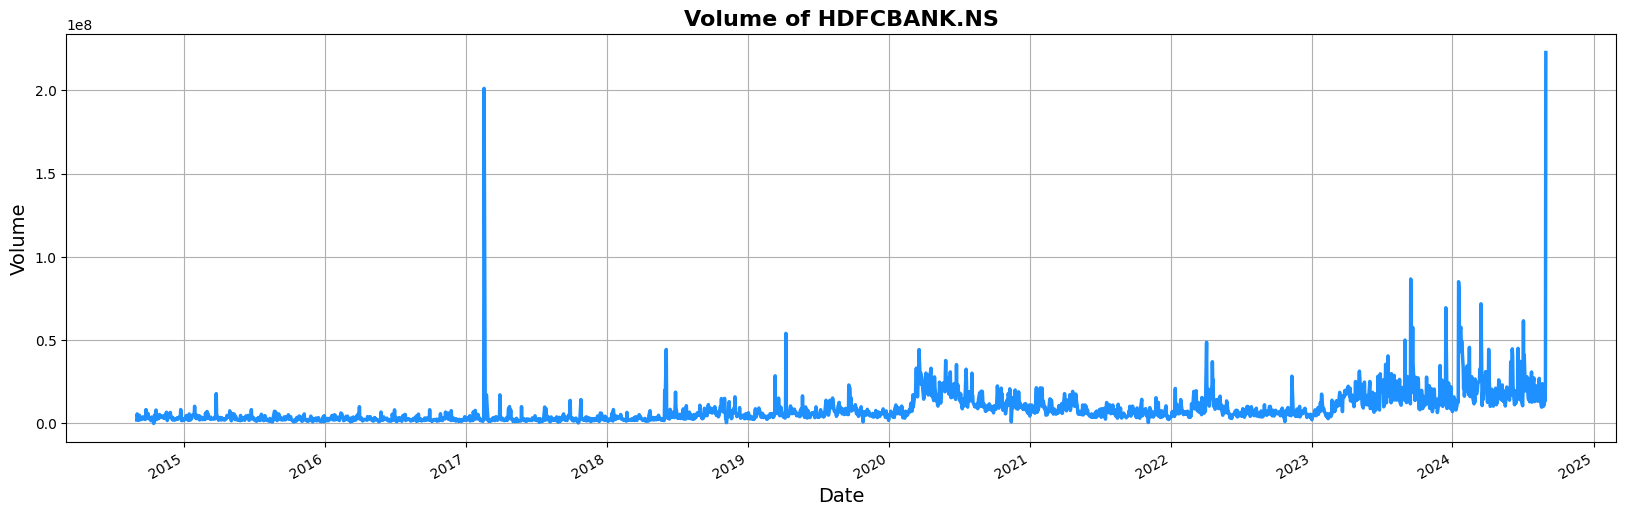

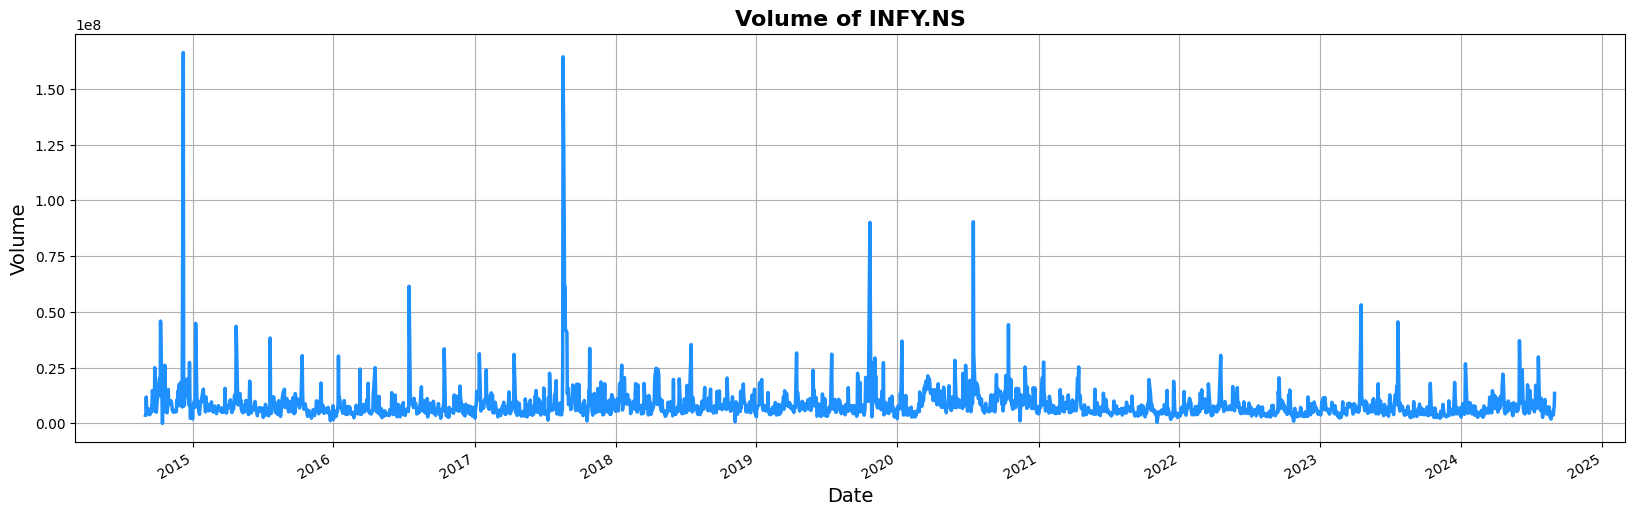

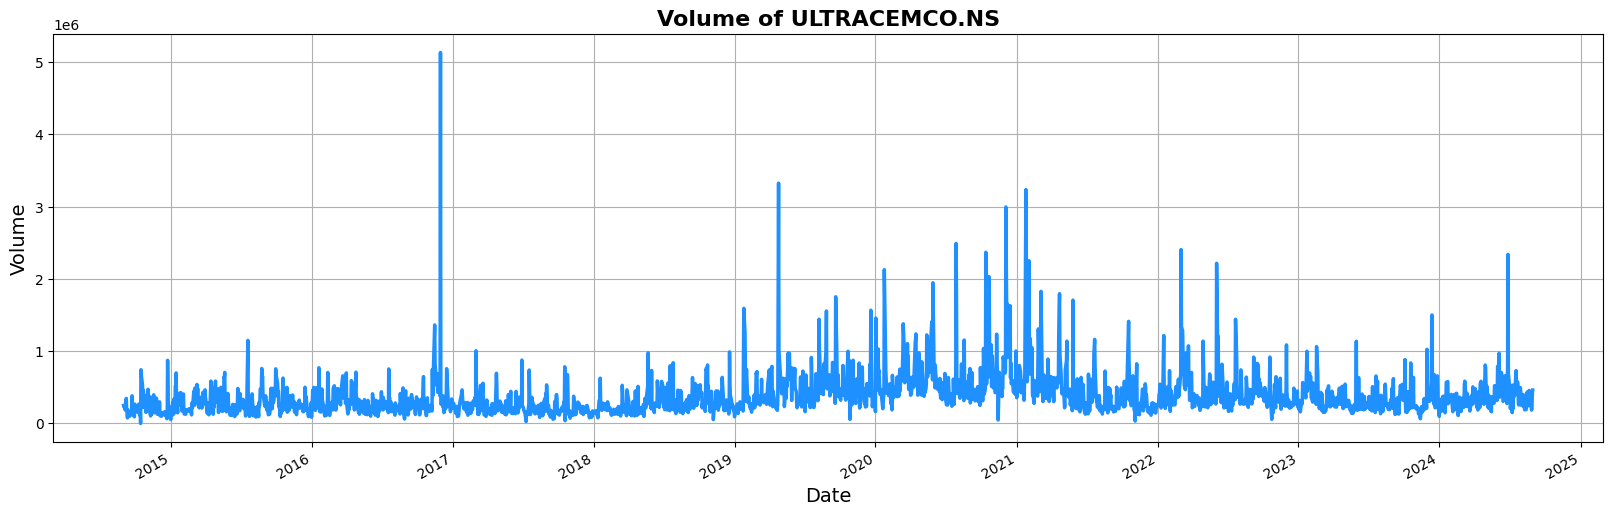

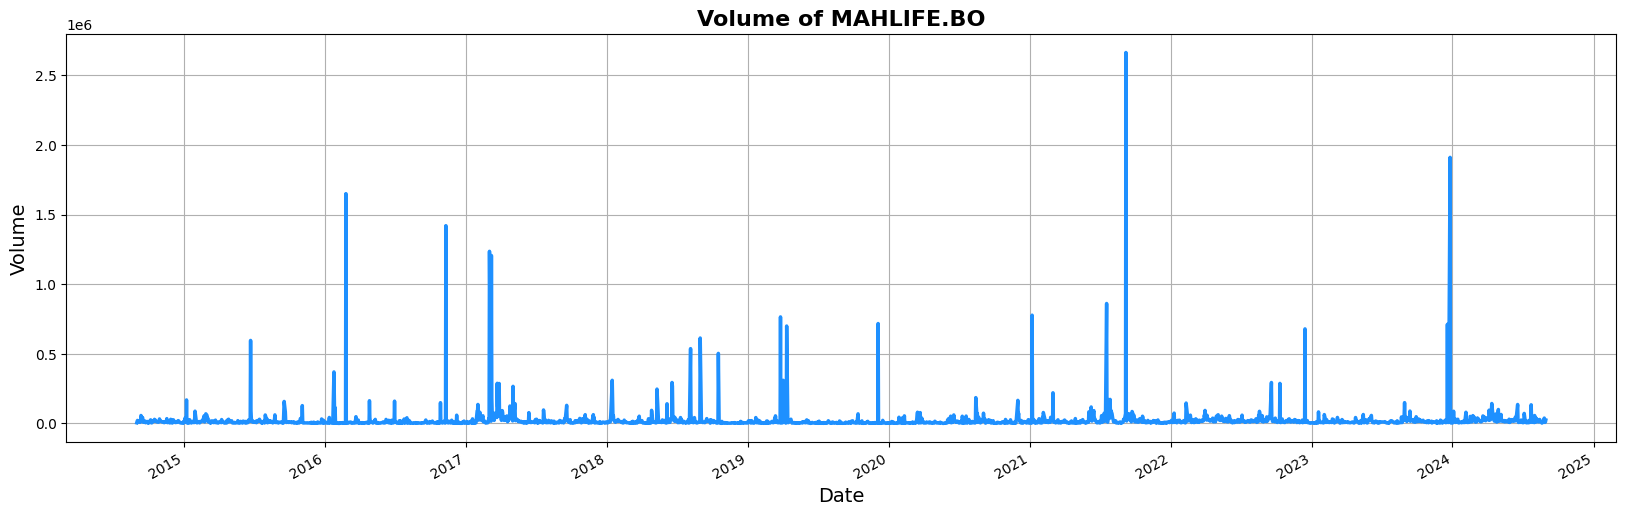

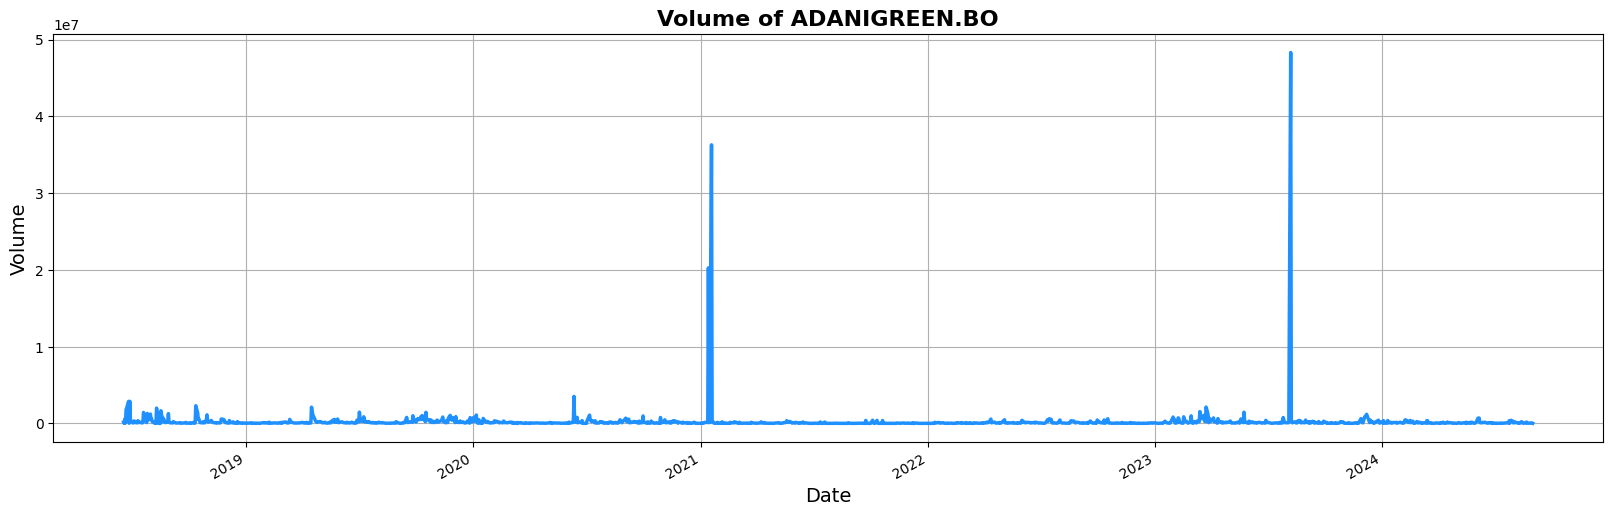

In [28]:
# Loop through the list of DataFrames and plot each stock's volume
for i, stock_data in enumerate(stocks):
    plt.figure(figsize=(20, 6))  # Customize the size of each plot for better visibility
    stock_data['Volume'].plot(color='dodgerblue', linewidth=2.5)  # Thicker line for better visibility
    plt.ylabel('Volume', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.title(f"Volume of {stock_data['company_name'].iloc[0]}", fontsize=16, fontweight='bold')  # Larger, bold title
    plt.grid(True)  # Add gridlines for better readability
    
    plt.show()  # Display each plot individually


## Moving Average

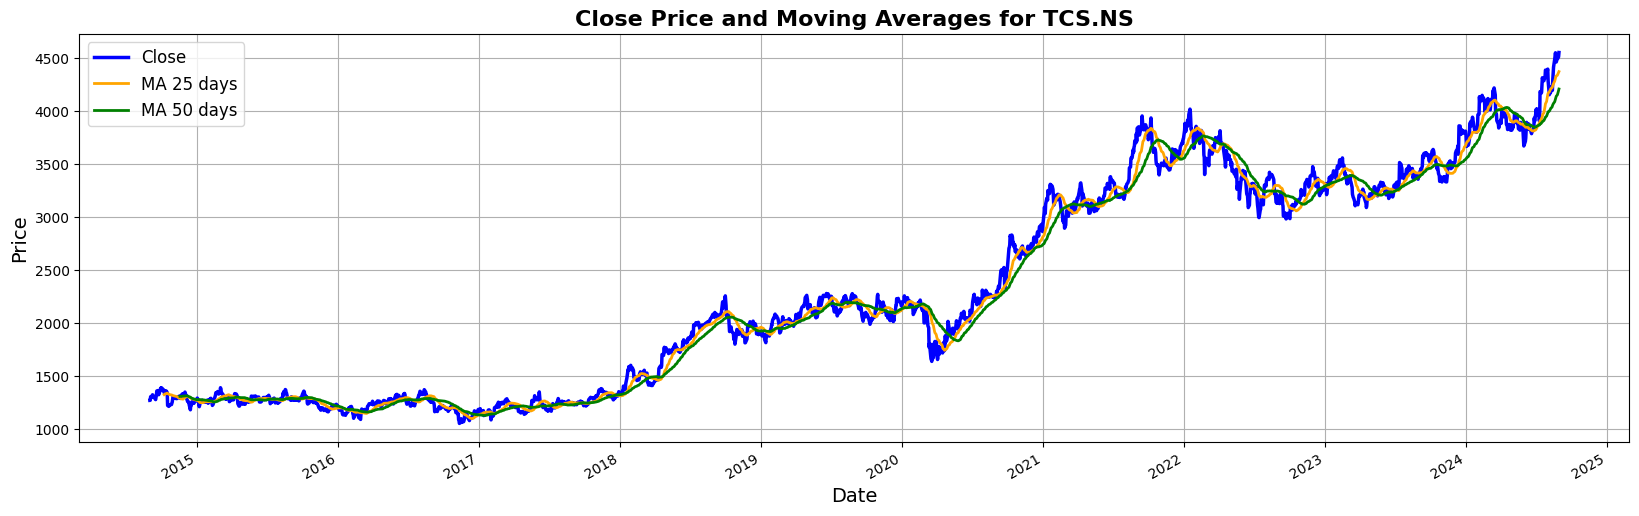

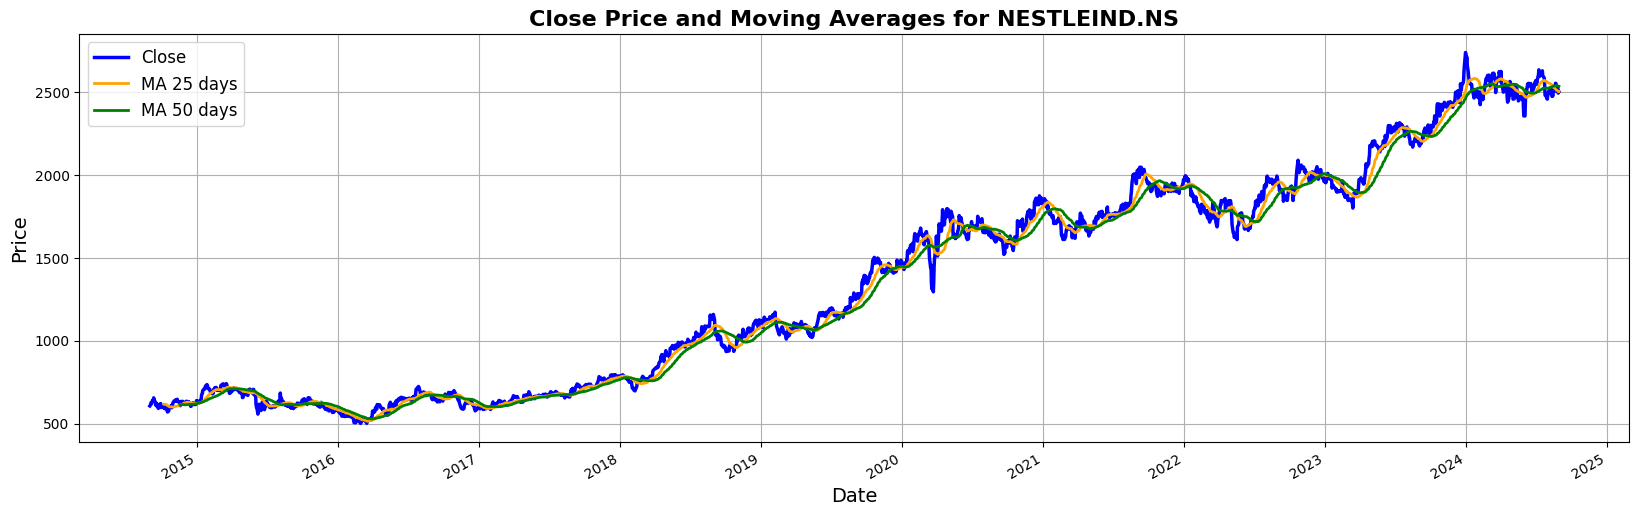

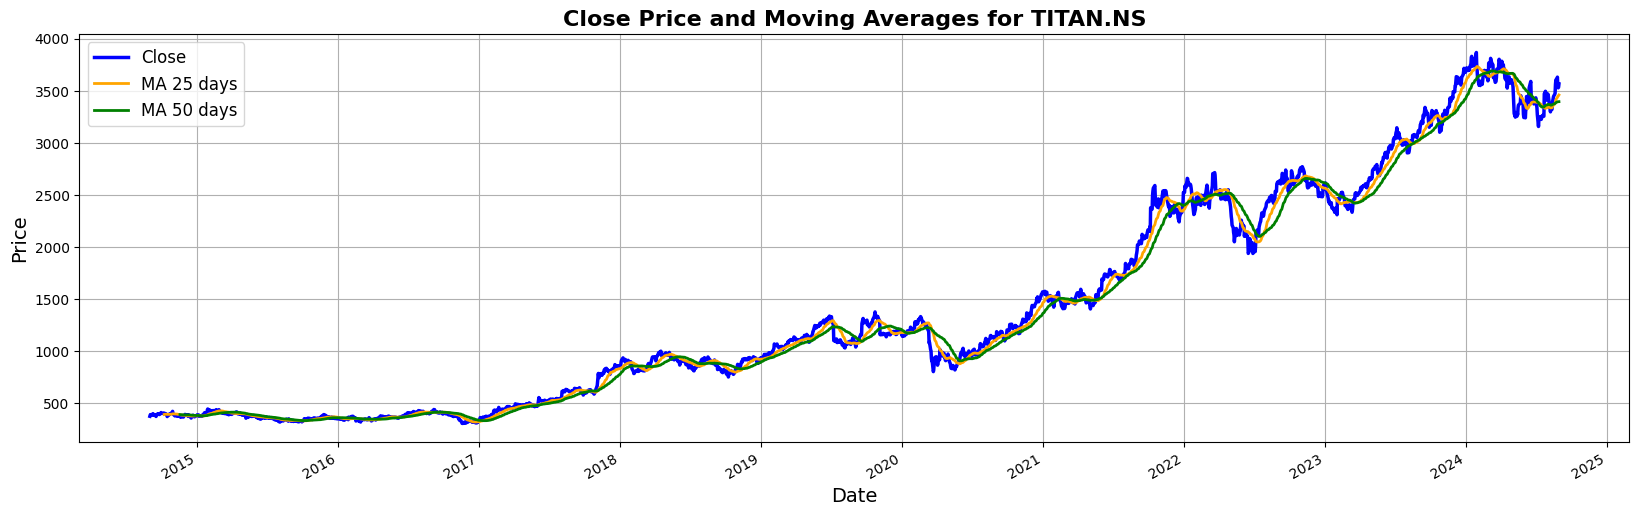

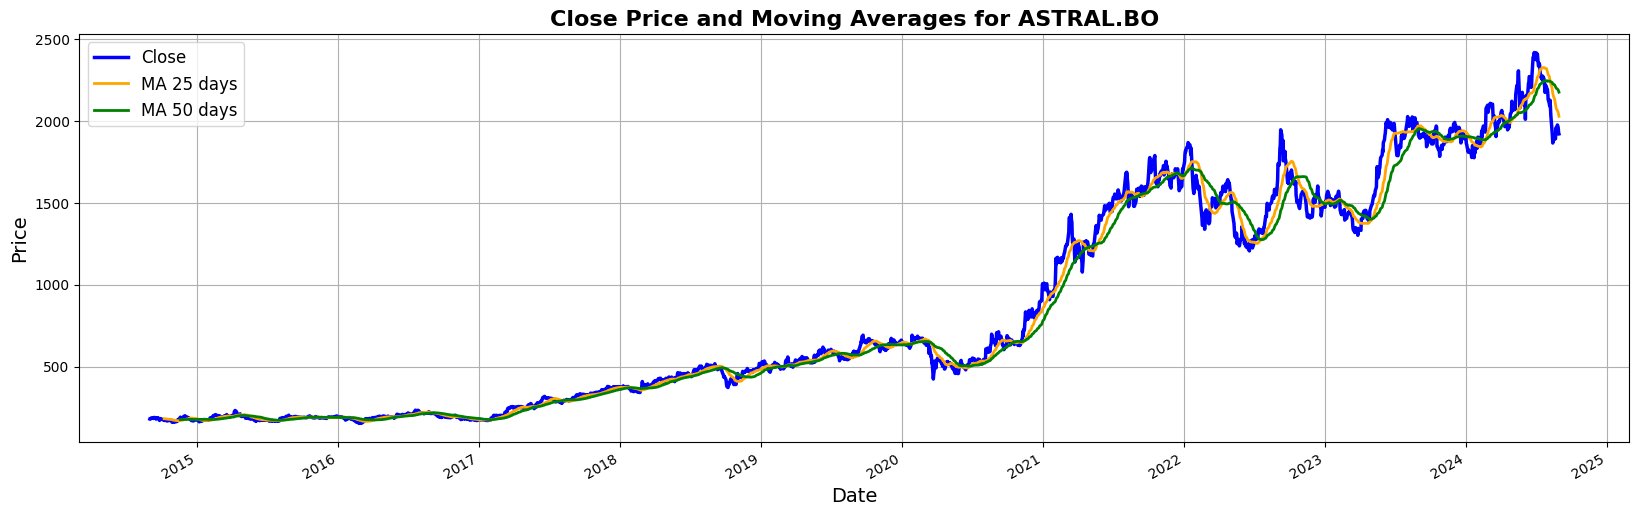

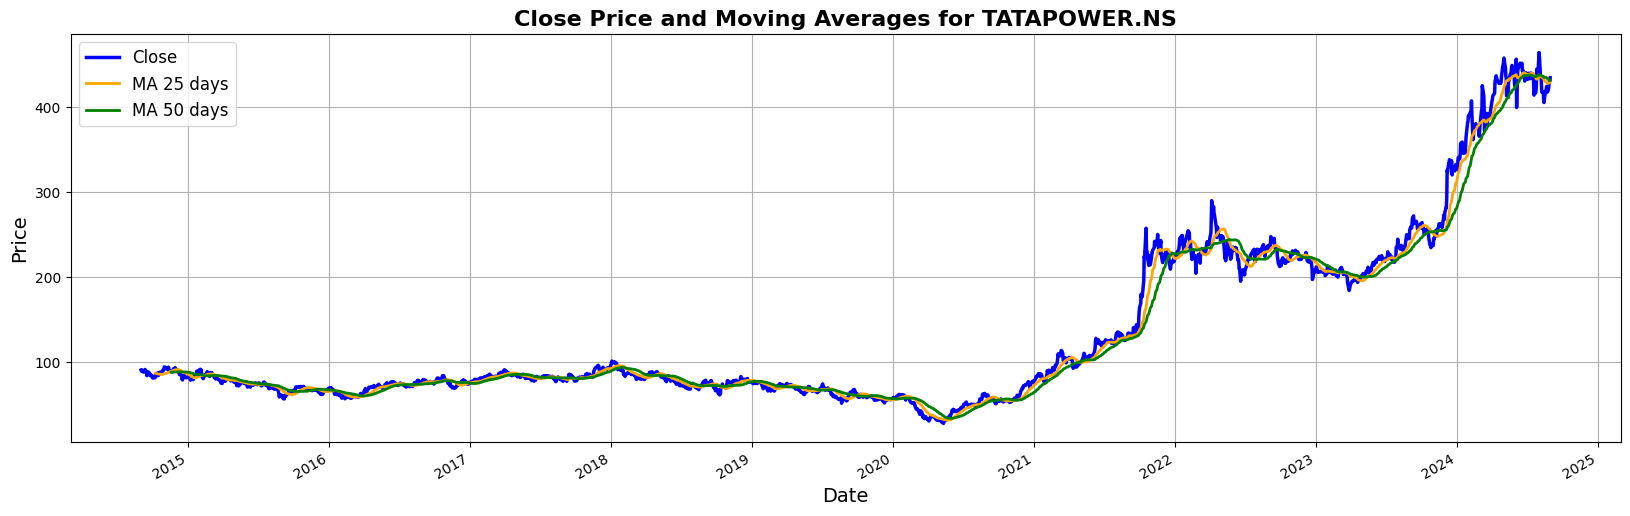

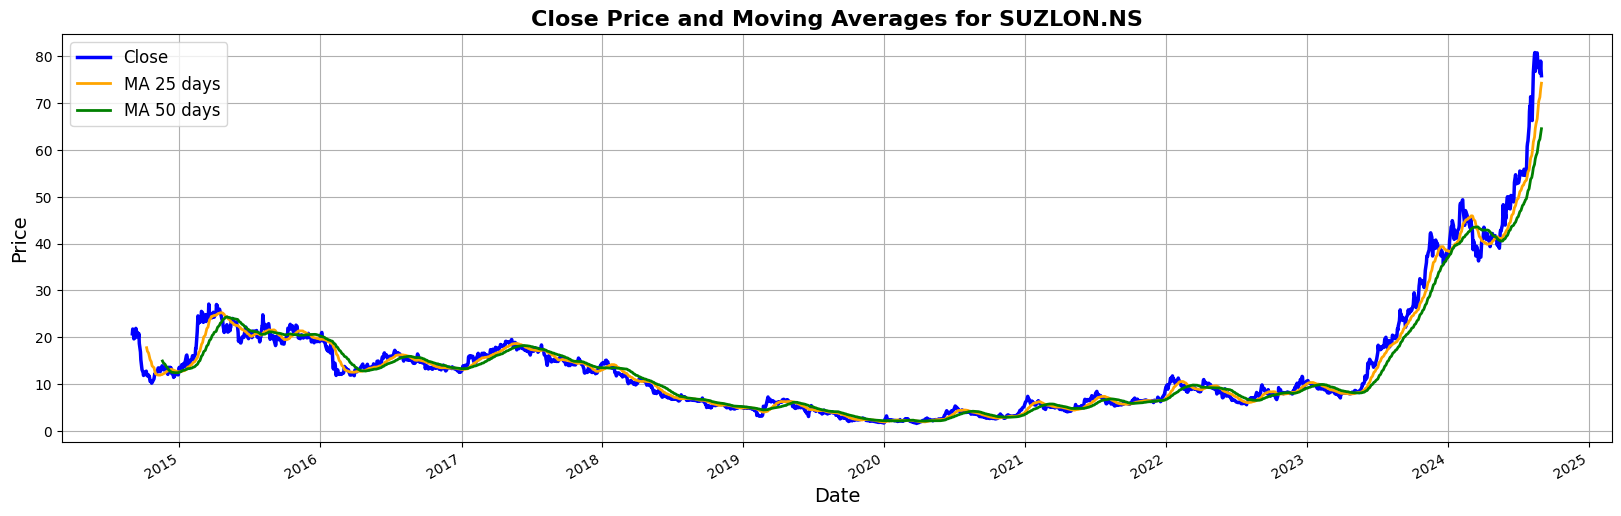

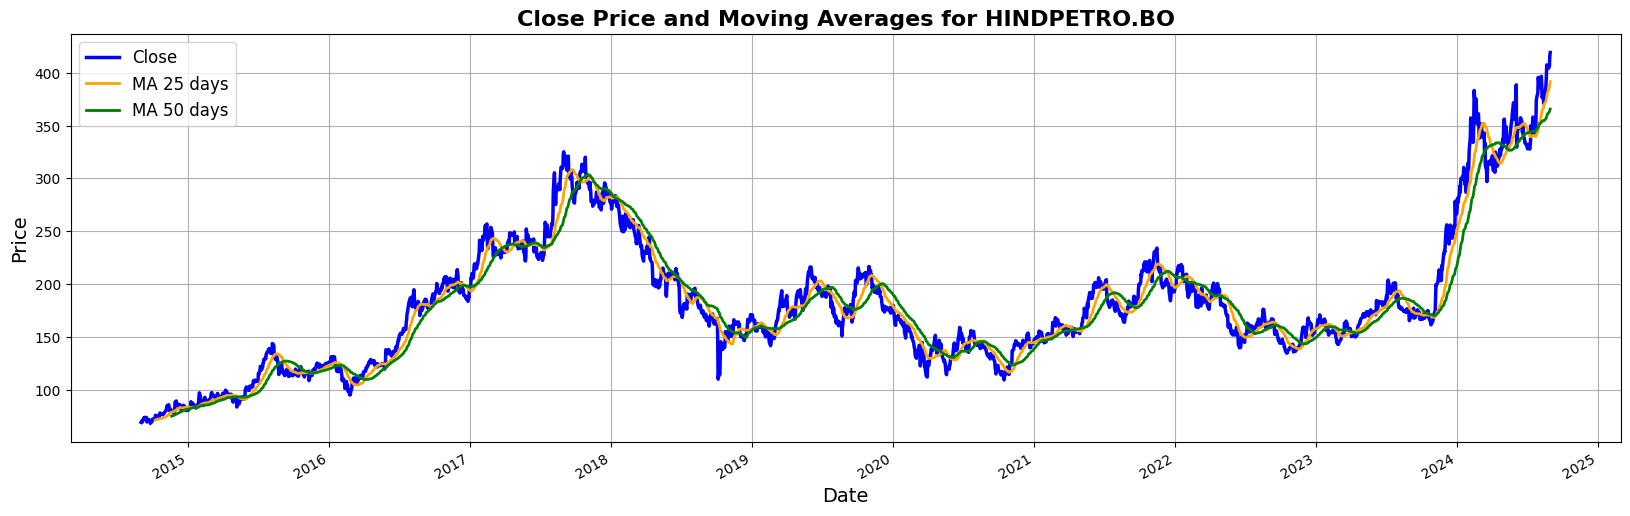

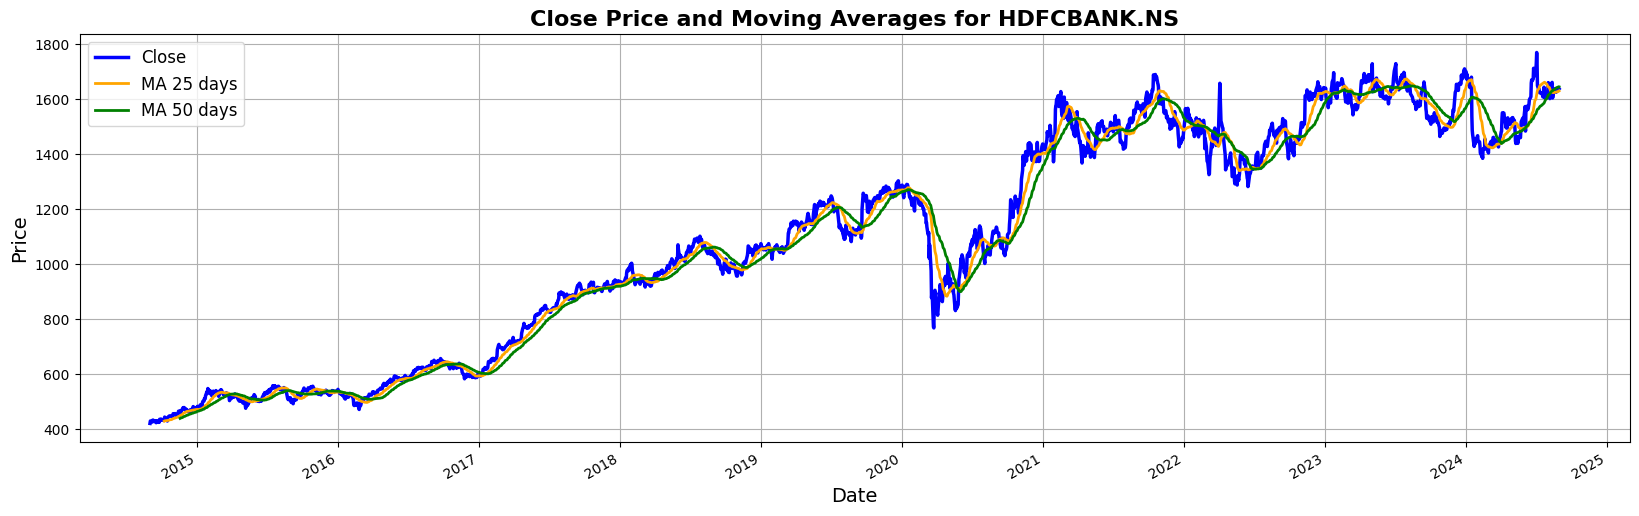

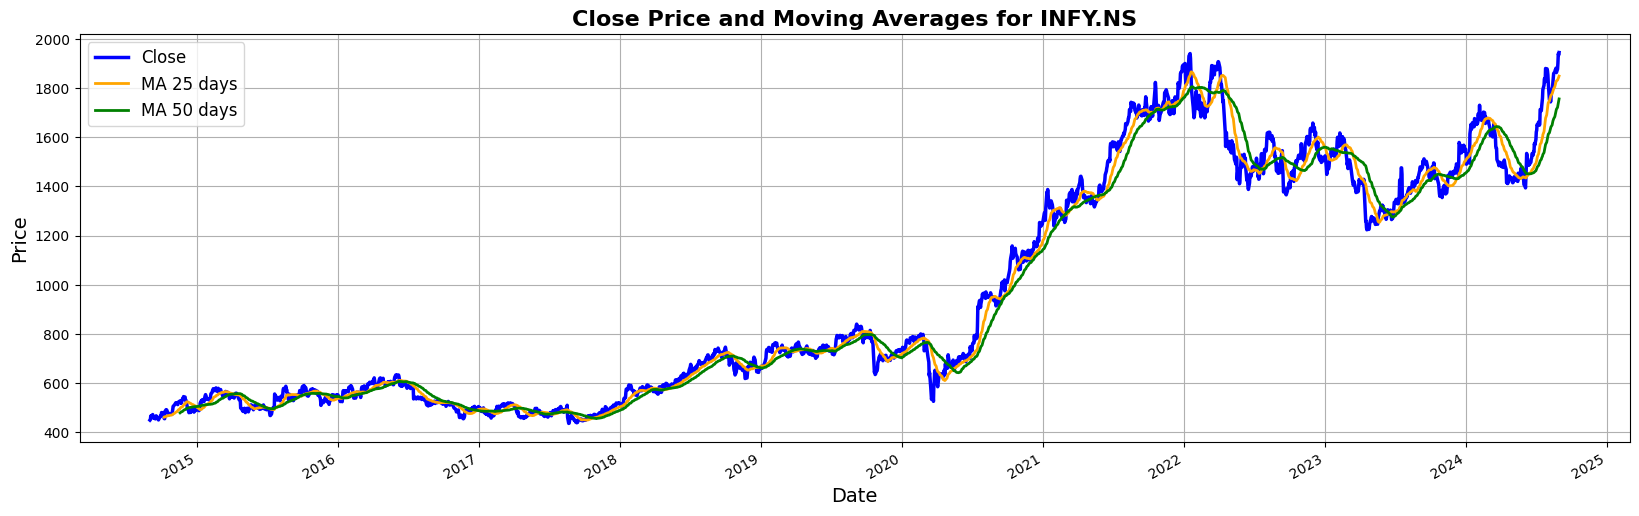

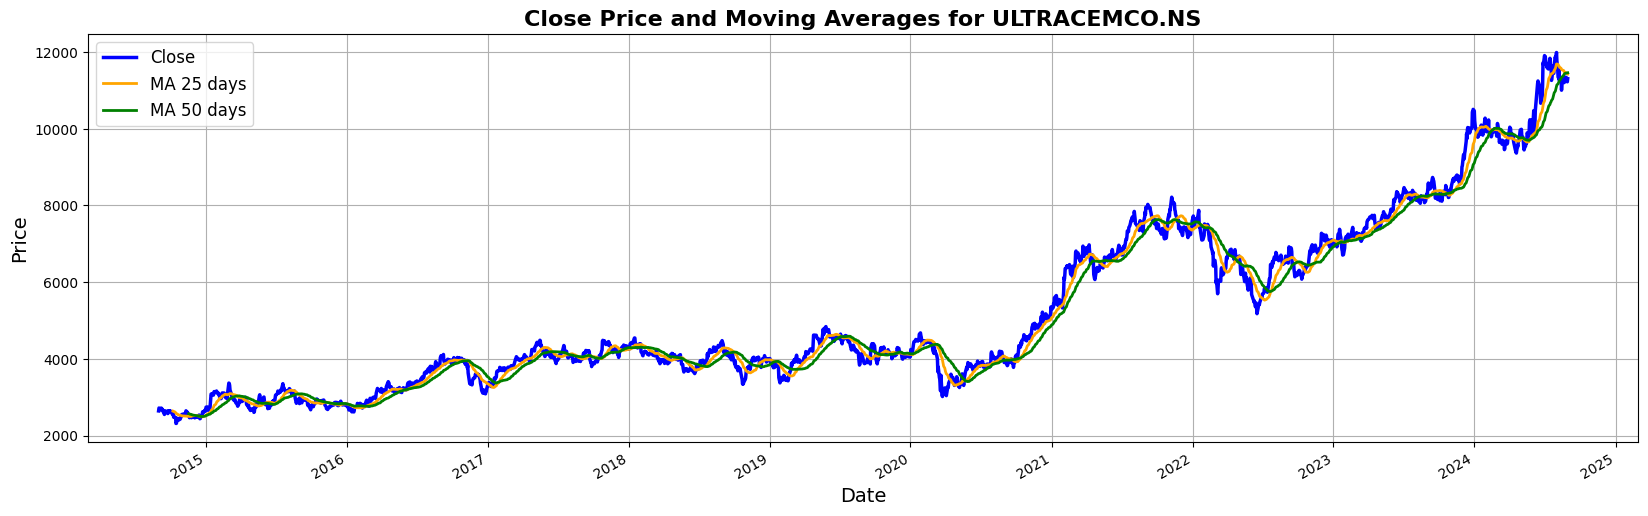

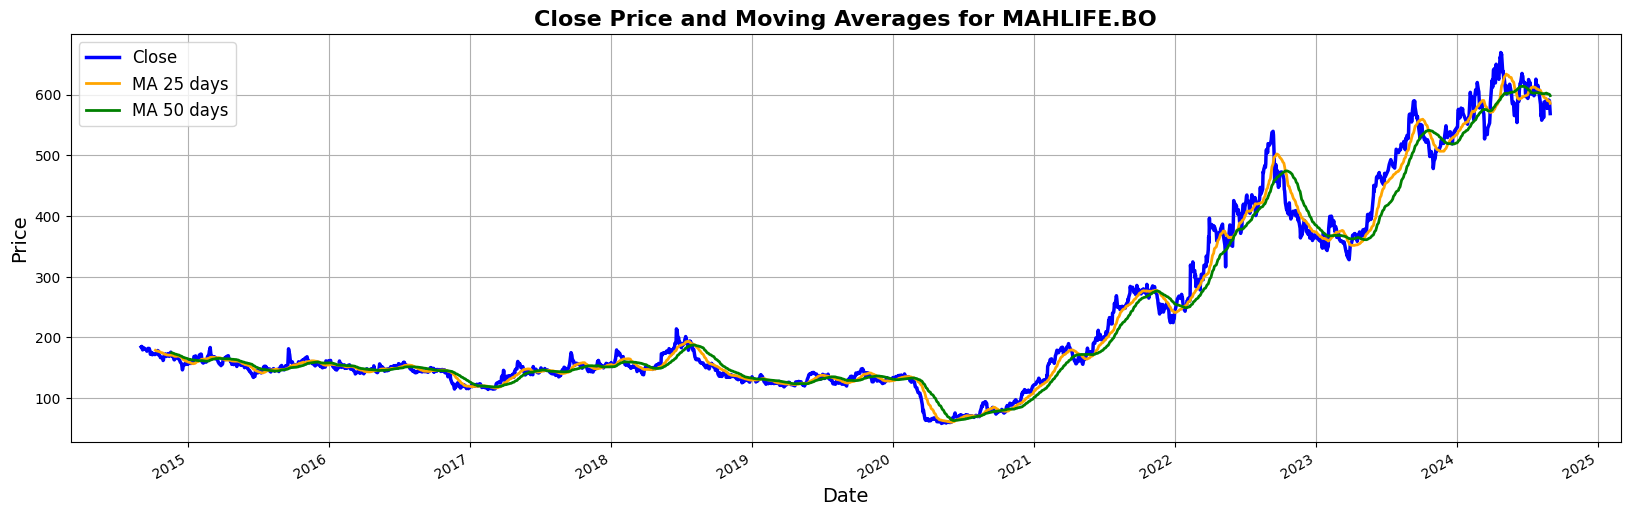

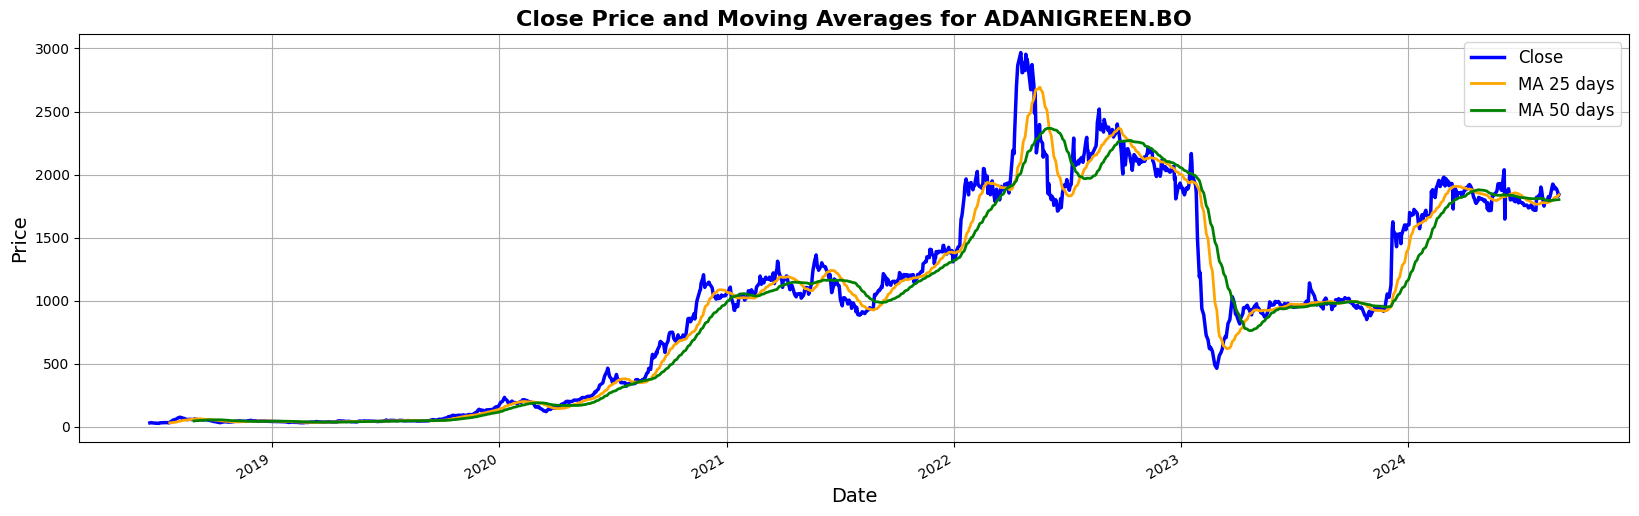

In [29]:
# Define colors for the moving averages
ma_days = [25,50]
colors = {
    25: 'orange',  # Color for MA25
    50: 'green'    # Color for MA50
}

# Calculate moving averages and add them to each DataFrame in the list
for ma in ma_days:
    for stock_data in stocks:
        stock_data[f"MA for {ma} days"] = stock_data['Close'].rolling(ma).mean()

# Loop through the list of DataFrames and plot the closing price and moving averages
for i, stock_data in enumerate(stocks):
    plt.figure(figsize=(20, 6))  # Larger figure size for better visibility
    stock_data['Close'].plot(label='Close', color='blue', linewidth=2.5)  # Close price in blue
    for ma in ma_days:
        stock_data[f"MA for {ma} days"].plot(label=f'MA {ma} days', color=colors[ma], linewidth=2)  # Moving averages with custom colors
    plt.ylabel('Price', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.title(f"Close Price and Moving Averages for {stock_data['company_name'].iloc[0]}", fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True)  # Add gridlines for better readability
    
    plt.show()  # Display each plot individually


## Risk VS Return

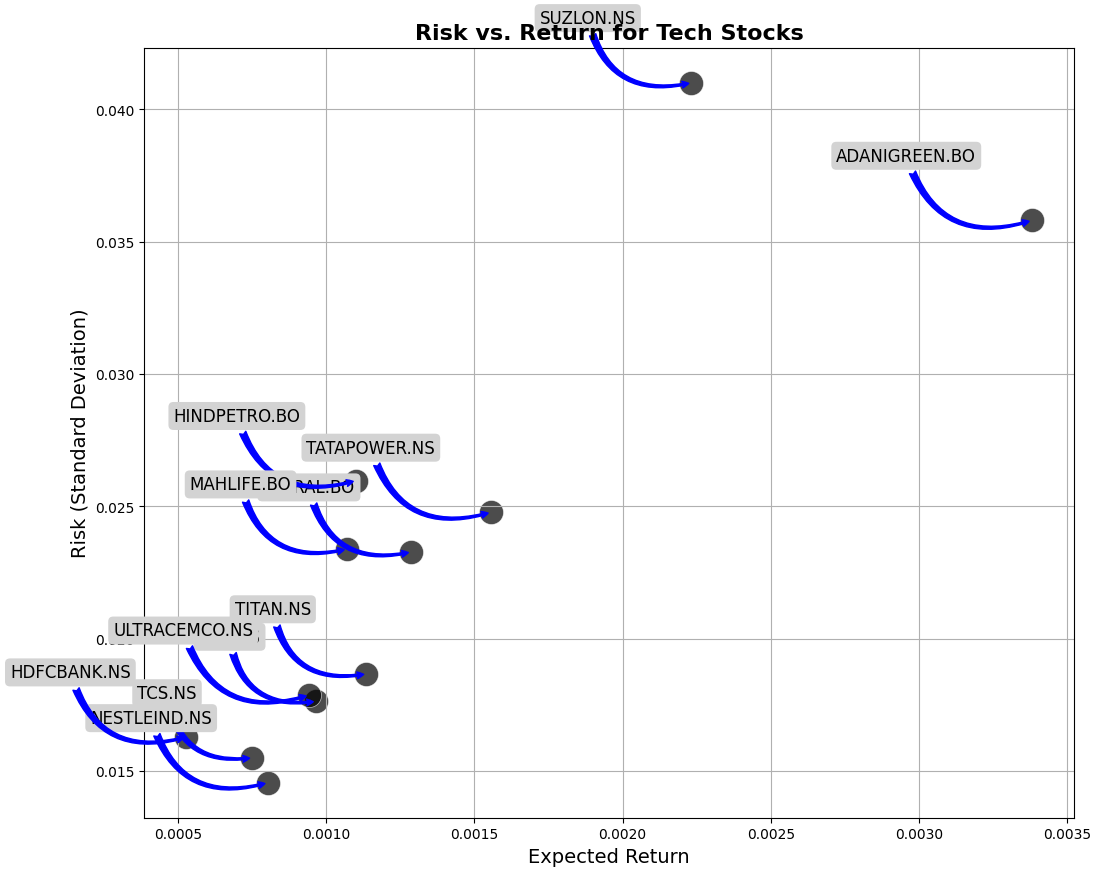

In [30]:
returns_df = pd.DataFrame()

# Calculate daily returns and store them in the returns_df
for stock_data in stocks:
    stock_name = stock_data['company_name'].iloc[0]
    returns_df[stock_name] = stock_data['Adj Close'].pct_change()

# Drop missing values from returns_df
returns_df = returns_df.dropna()

# Calculate mean returns and standard deviation (risk)
mean_returns = returns_df.mean()
std_dev = returns_df.std()

# Plot the risk vs. return scatter plot
plt.figure(figsize=(12, 10))  # Larger figure size for better visibility

# Scatter plot with larger, black circles
plt.scatter(mean_returns, std_dev, s=300, color='black', alpha=0.7, edgecolors='w', linewidth=0.5)  # Larger circles

# Add labels and annotations
plt.xlabel('Expected Return', fontsize=14)
plt.ylabel('Risk (Standard Deviation)', fontsize=14)
plt.title('Risk vs. Return for Tech Stocks', fontsize=16, fontweight='bold')

for label, x, y in zip(returns_df.columns, mean_returns, std_dev):
    # Calculate position for annotation
    offset_x = 40 if x < 0 else -40  # Dynamic offset based on x position to avoid overlap
    offset_y = 40  # Fixed vertical offset
    # Annotate with thinner, curvy arrows
    plt.annotate(label, xy=(x, y), xytext=(x + offset_x, y + offset_y), textcoords='offset points',
                 ha='right', va='bottom', fontsize=12,
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='lightgrey'),
                 arrowprops=dict(arrowstyle='fancy', color='blue', lw=1, connectionstyle='arc3,rad=0.5'))  # Thinner arrows

plt.grid(True)
plt.show()


## Capturing stocks Trends with indicators

### RSI 

**Relative Strength Index (RSI)** is an analysis tool that measures the speed and rate of price changes in the market.

It provides immediate signals for buying and selling, helping you understand whether an asset is overbought or oversold.

RSI readings below 30 signal buy opportunities, indicating the asset is undervalued. Conversely, RSI readings above 70 signal sell opportunities, suggesting the asset is overvalued. A value of 50 signifies a balance between bullish and bearish positions or a neutral stance.

**Formula:**

$$
\text{RSI} = 100 - \left[ \frac{100}{1 + \left(\frac{\text{Average of Upward Price Change}}{\text{Average of Downward Price Change}}\right)} \right]
$$


### EMA

An **Exponential Moving Average (EMA)** is a widely used technical chart indicator that helps track changes in the price of a financial instrument over a specified period. Unlike a Simple Moving Average (SMA), the EMA gives more weight to recent prices, making it more responsive to new information.

### Formula for the Exponential Moving Average (EMA)

The EMA is calculated using the following formula:

$$
\text{EMA}_t = \text{Price}_t \times K + \text{EMA}_{t-1} \times (1 - K)
$$





Where:
- **Price_t** is the price of the asset at time **t**.
- **EMA_(t-1)** is the EMA value of the previous period.
- **K** is the smoothing factor, given by **K = 2 / (N + 1)**, where **N** represents the number of periods.

The EMA is particularly useful in identifying trends and smoothing out price fluctuations, providing a clearer view of the underlying trend.


### MACD

The **Moving Average Convergence/Divergence (MACD)** indicator is primarily used to trade trends. It appears on the chart as two lines: the MACD line (fast line) and the Signal line (slow line). The crossover of these two lines provides trading signals.

- **Bullish Signal**: When the MACD line crosses from below to above the Signal line, the indicator is considered bullish. The further below the zero line the crossover occurs, the stronger the signal.
  
- **Bearish Signal**: When the MACD line crosses from above to below the Signal line, the indicator is considered bearish. The further above the zero line the crossover occurs, the stronger the signal.


#### MACD Histogram

The **MACD Histogram** represents the difference between the MACD line and the Signal line. It is used to visualize the strength and direction of the MACD signal.

- **Positive Histogram**: When the MACD line is above the Signal line, the histogram is positive. This indicates a bullish trend and can suggest increasing upward momentum.
  
- **Negative Histogram**: When the MACD line is below the Signal line, the histogram is negative. This indicates a bearish trend and can suggest increasing downward momentum.

The histogram helps traders to identify the potential changes in the strength of the trend and possible trend reversals. 


### MACD Formulas

1. **MACD Line**: 
   - `MACD Line = EMA(12) - EMA(26)`
     - **EMA(12)**: 12-period Exponential Moving Average of the closing prices
     - **EMA(26)**: 26-period Exponential Moving Average of the closing prices

2. **Signal Line**: 
   - `Signal Line = EMA(9, MACD Line)`
     - **EMA(9)**: 9-period Exponential Moving Average of the MACD Line

3. **MACD Histogram**: 
   - `MACD Histogram = MACD Line - Signal Line`


### VWAP

The **Volume-weighted average price (VWAP)** is a technical analysis indicator used on intraday charts that resets at the start of every new trading session. It's the average price a security has traded at throughout the day, based on both volume and price. VWAP is important because it provides traders with insight into the price trend.

The formula for VWAP is:

$$
\text{VWAP} = \frac{\text{Cumulative Typical Price} \times \text{Volume}}{\text{Cumulative Volume}}
$$

where:

- **Typical Price** is calculated as:
  $$
  \text{Typical Price} = \frac{\text{High Price} + \text{Low Price} + \text{Closing Price}}{3}
  $$

- **Cumulative Typical Price** is the sum of the Typical Price multiplied by Volume for each trade since the trading session opened.

- **Cumulative Volume** is the total volume of trades since the trading session opened.


Processing stock: TCS.NS


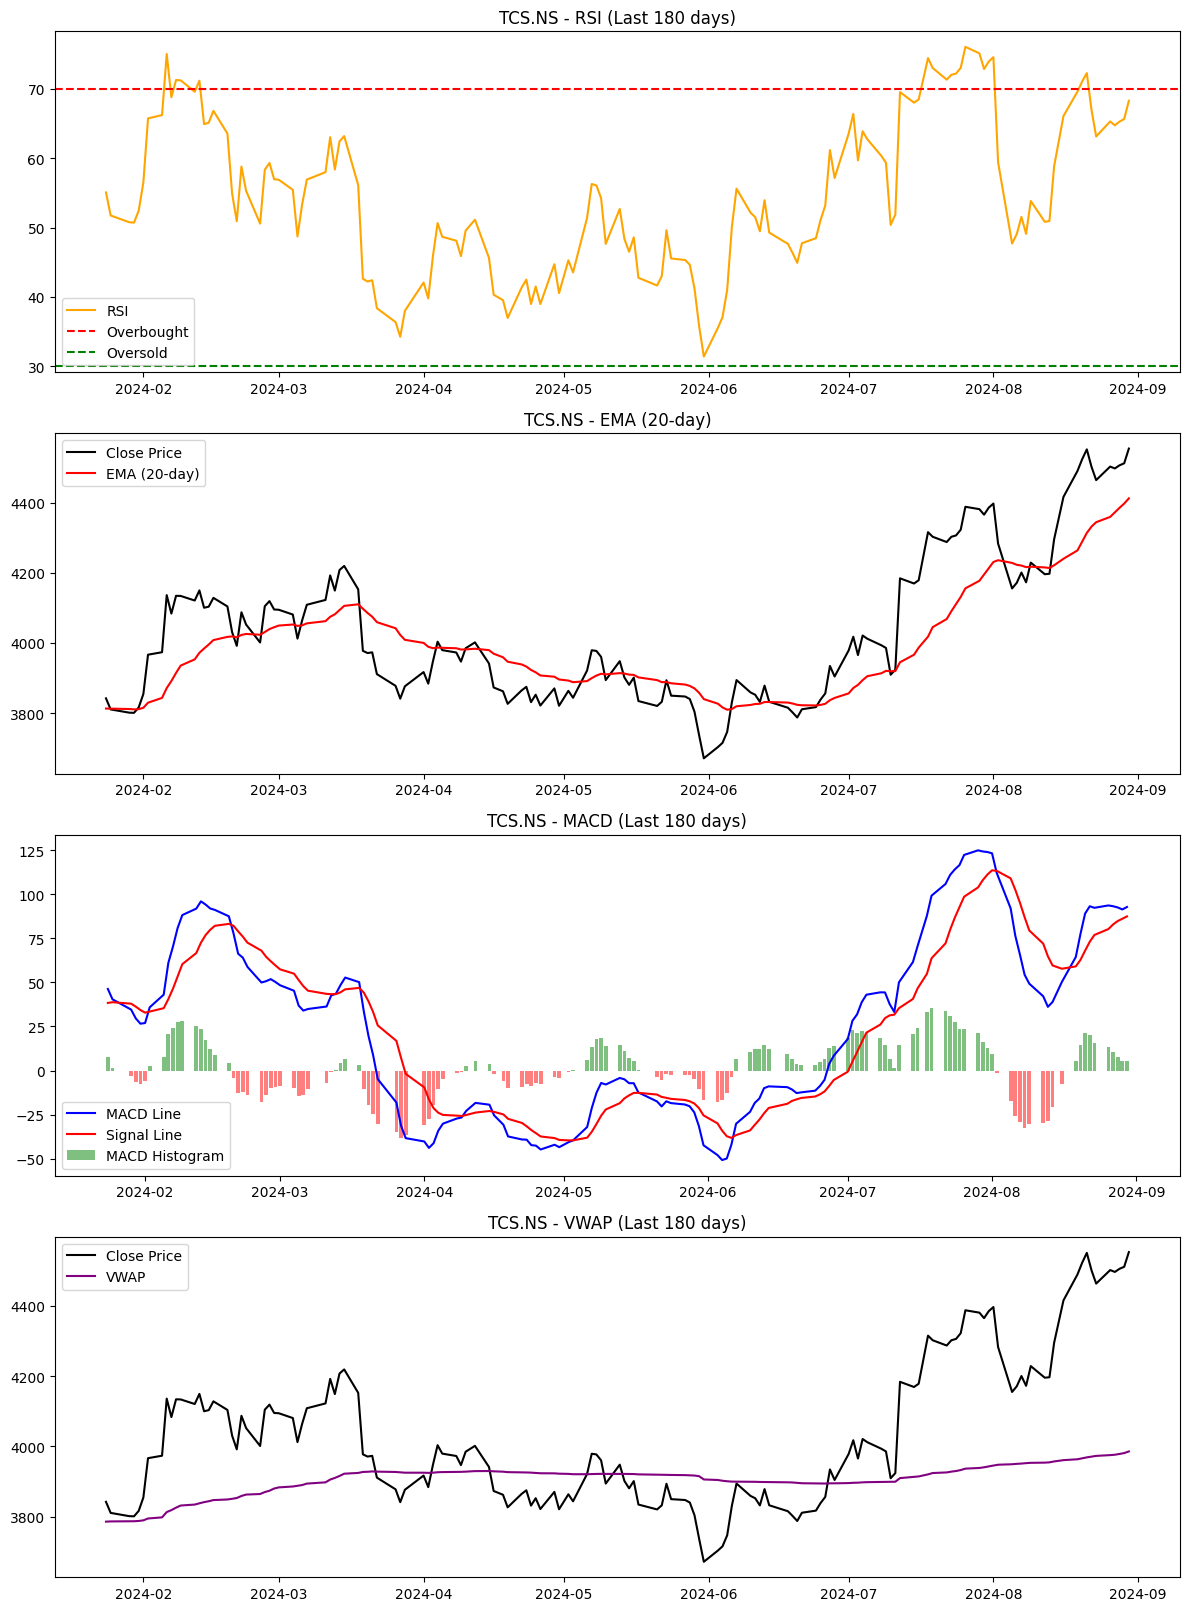

Processing stock: NESTLEIND.NS


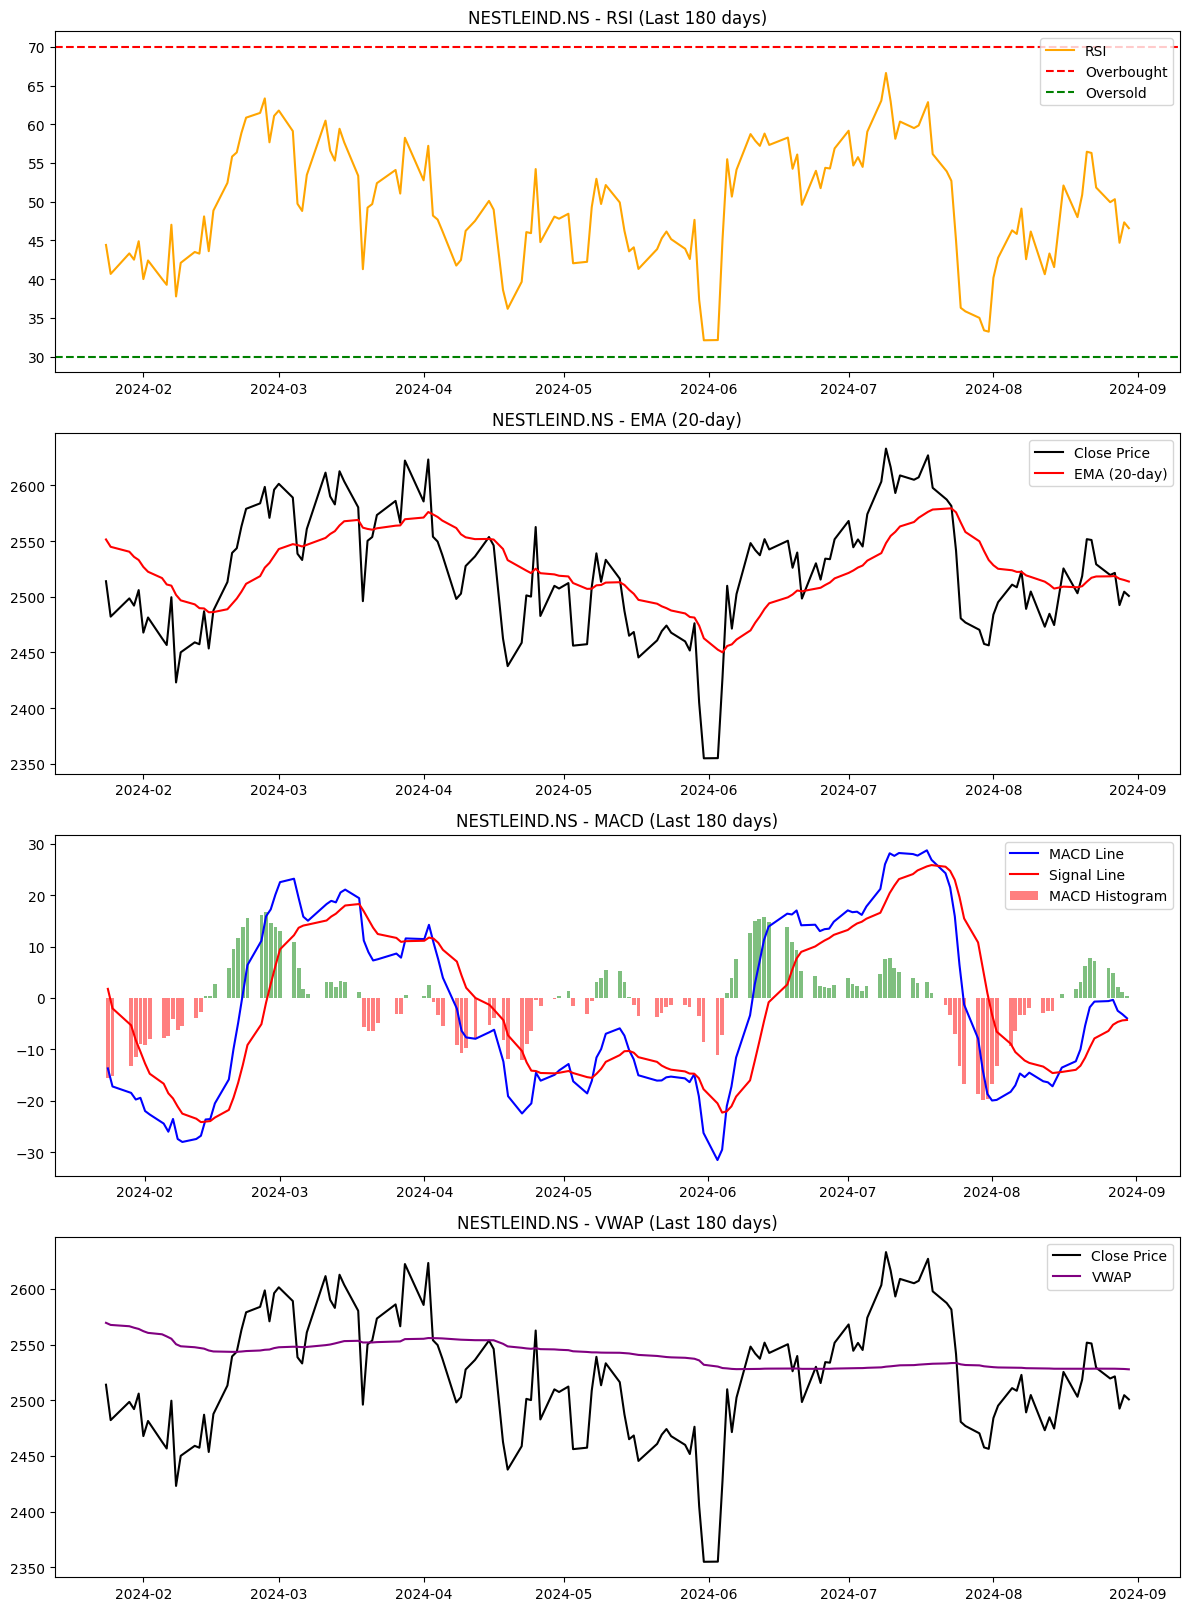

Processing stock: TITAN.NS


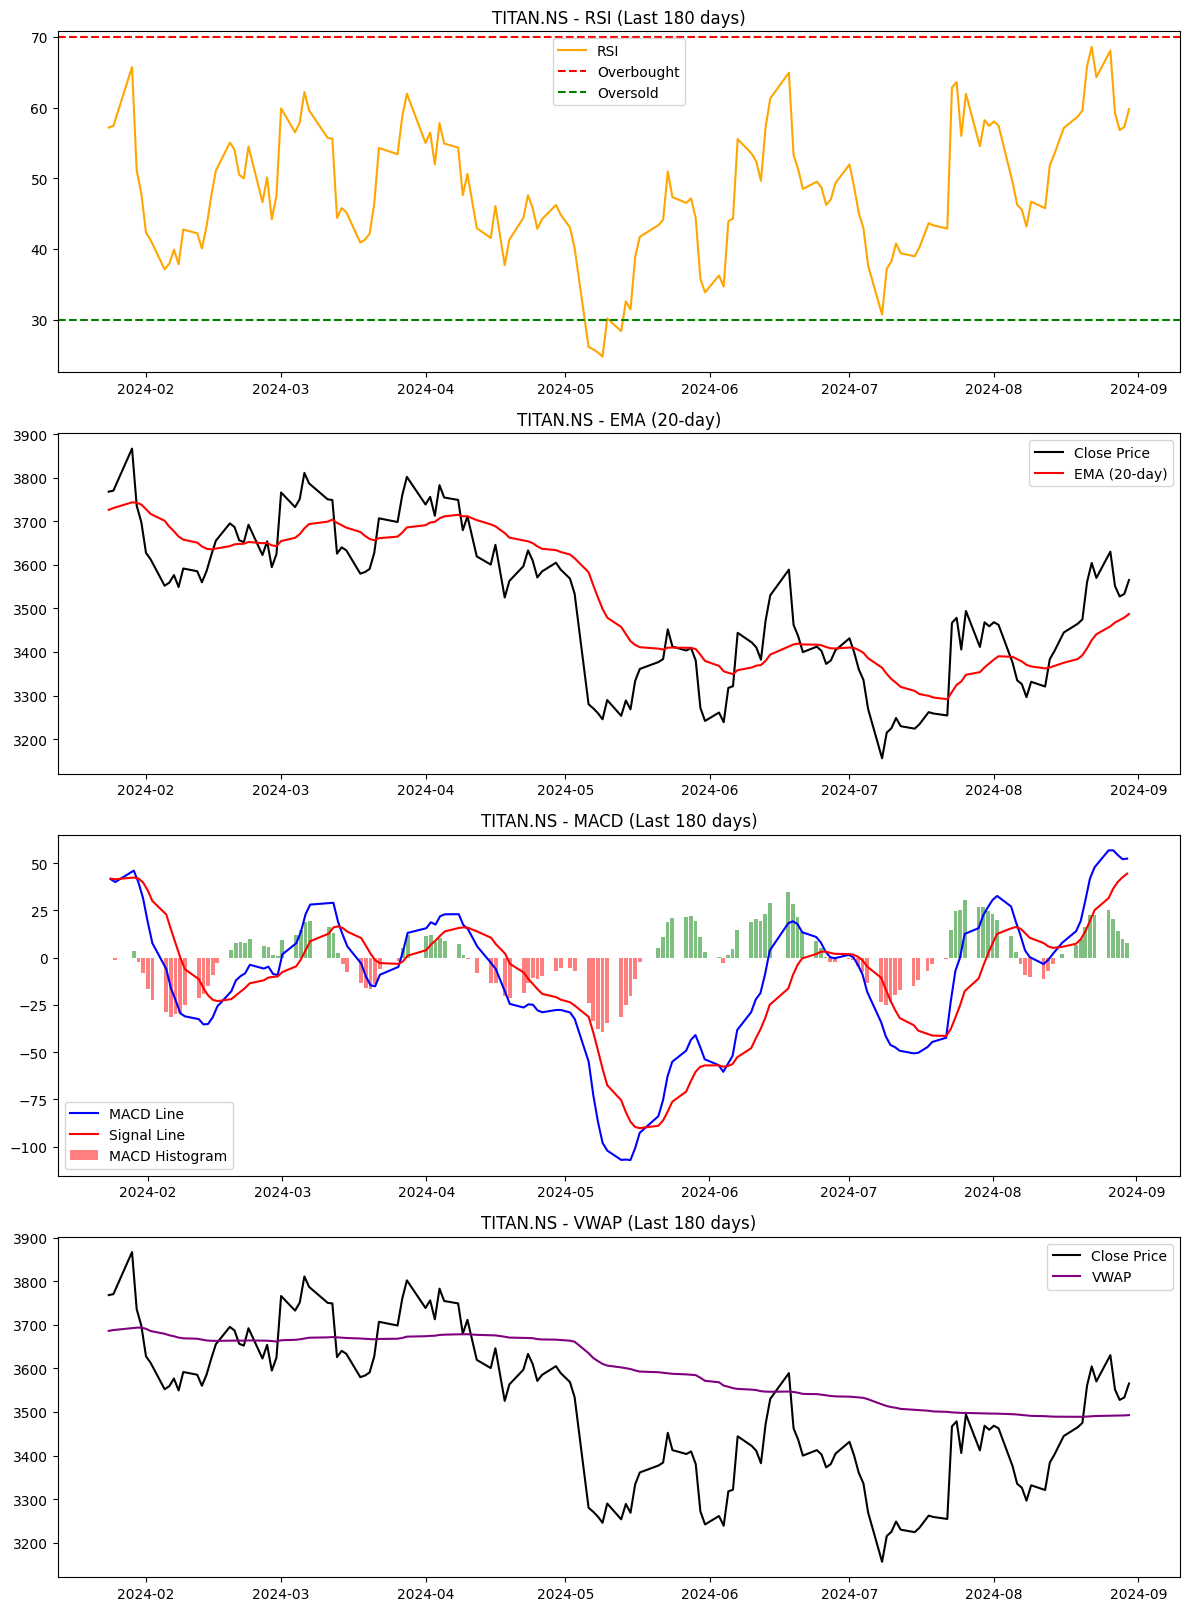

Processing stock: ASTRAL.BO


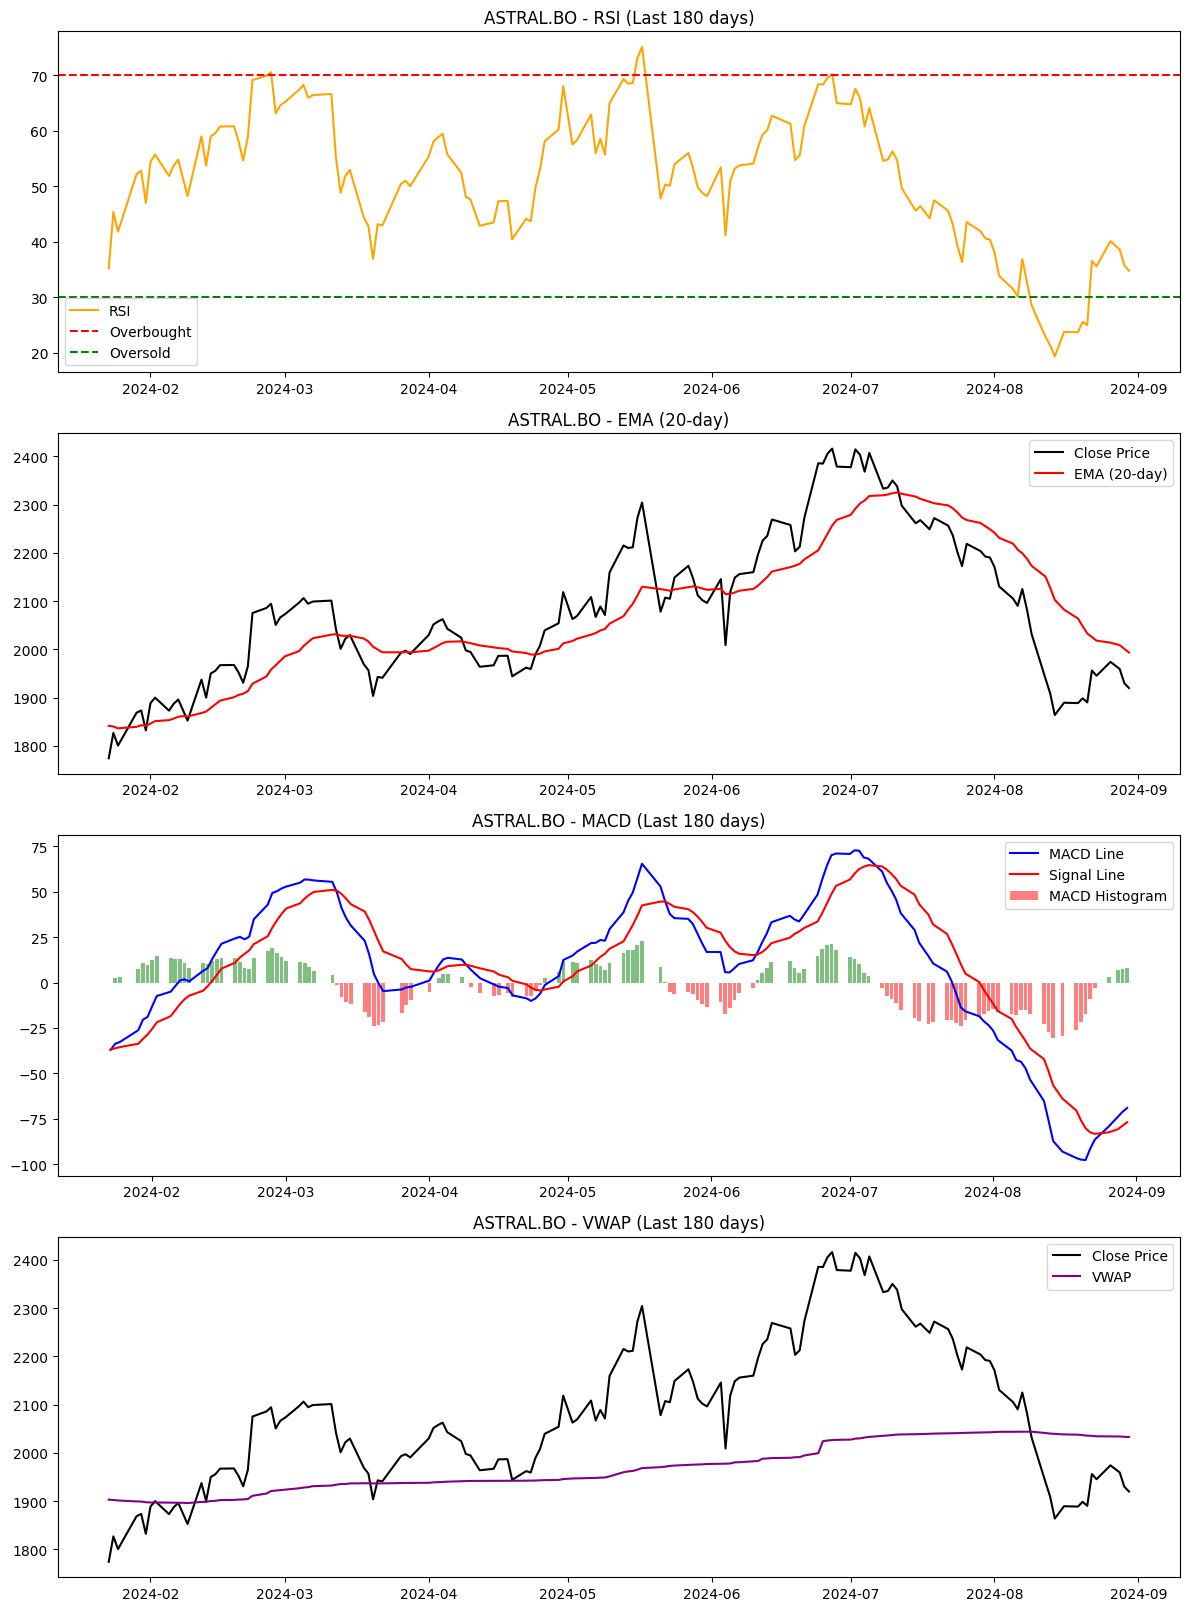

Processing stock: TATAPOWER.NS


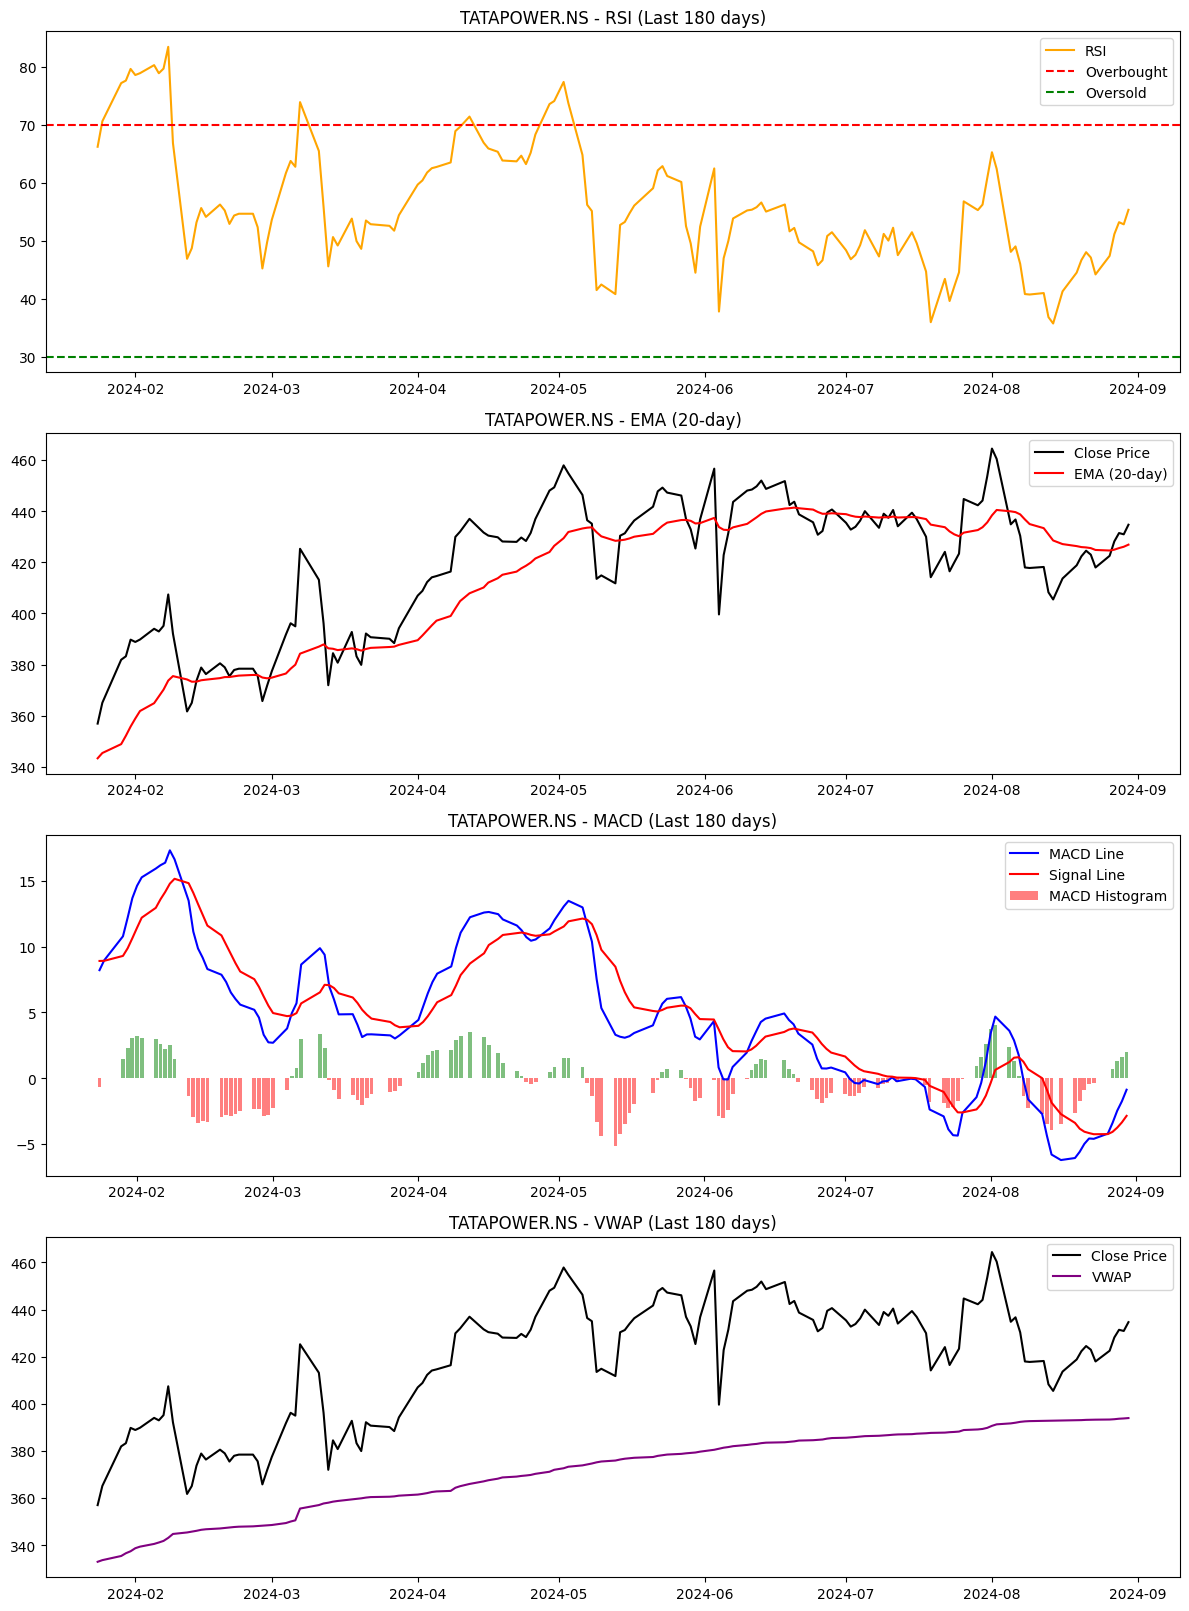

Processing stock: SUZLON.NS


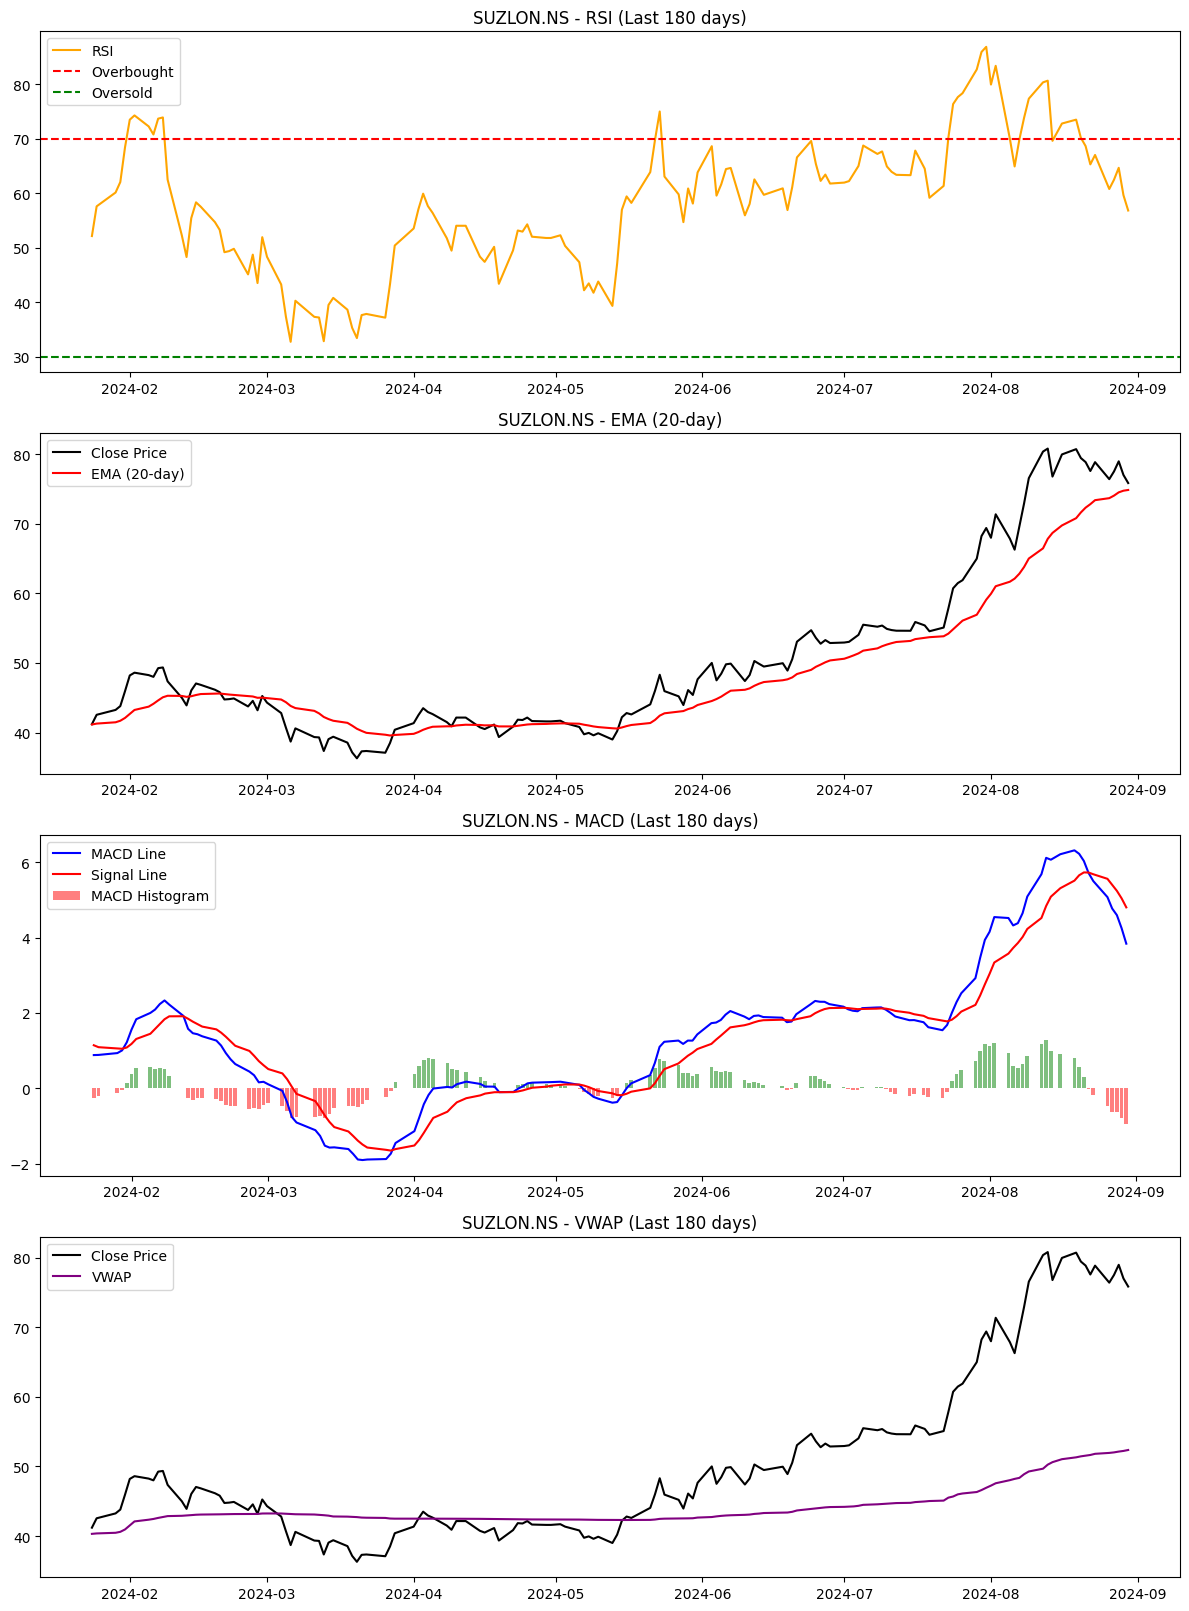

Processing stock: HINDPETRO.BO


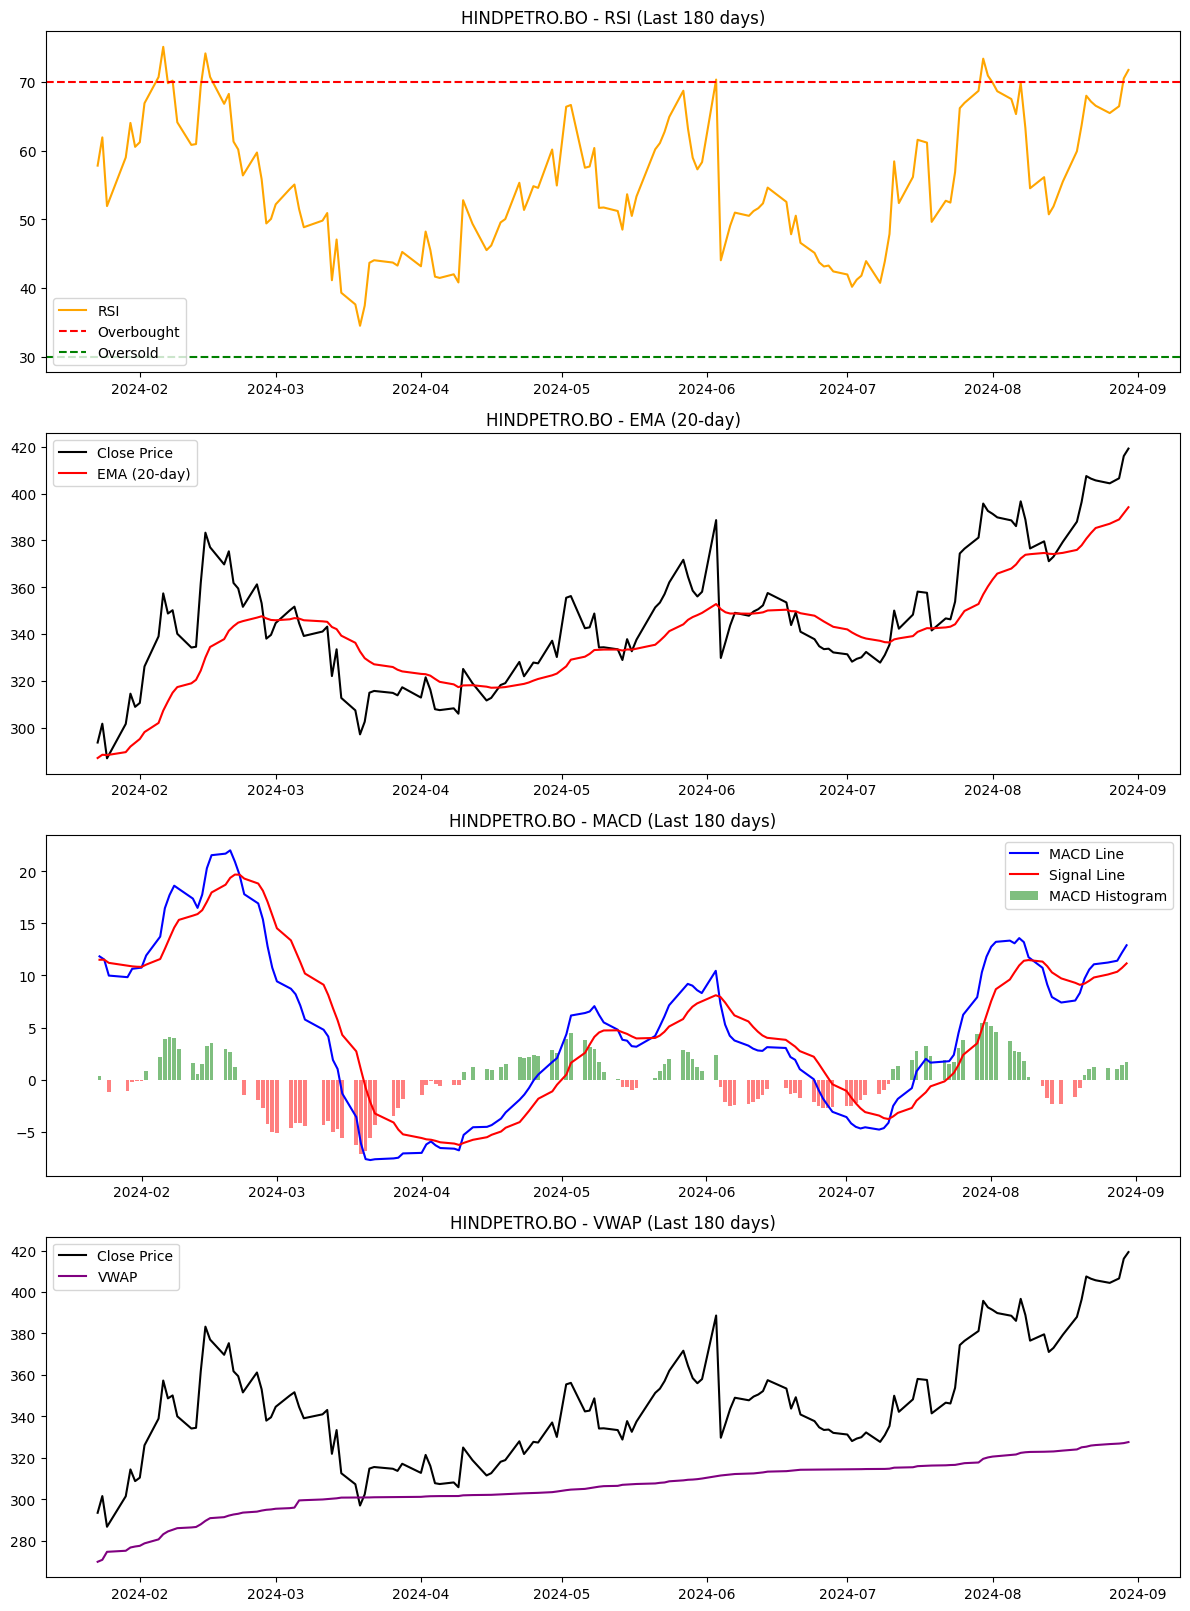

Processing stock: HDFCBANK.NS


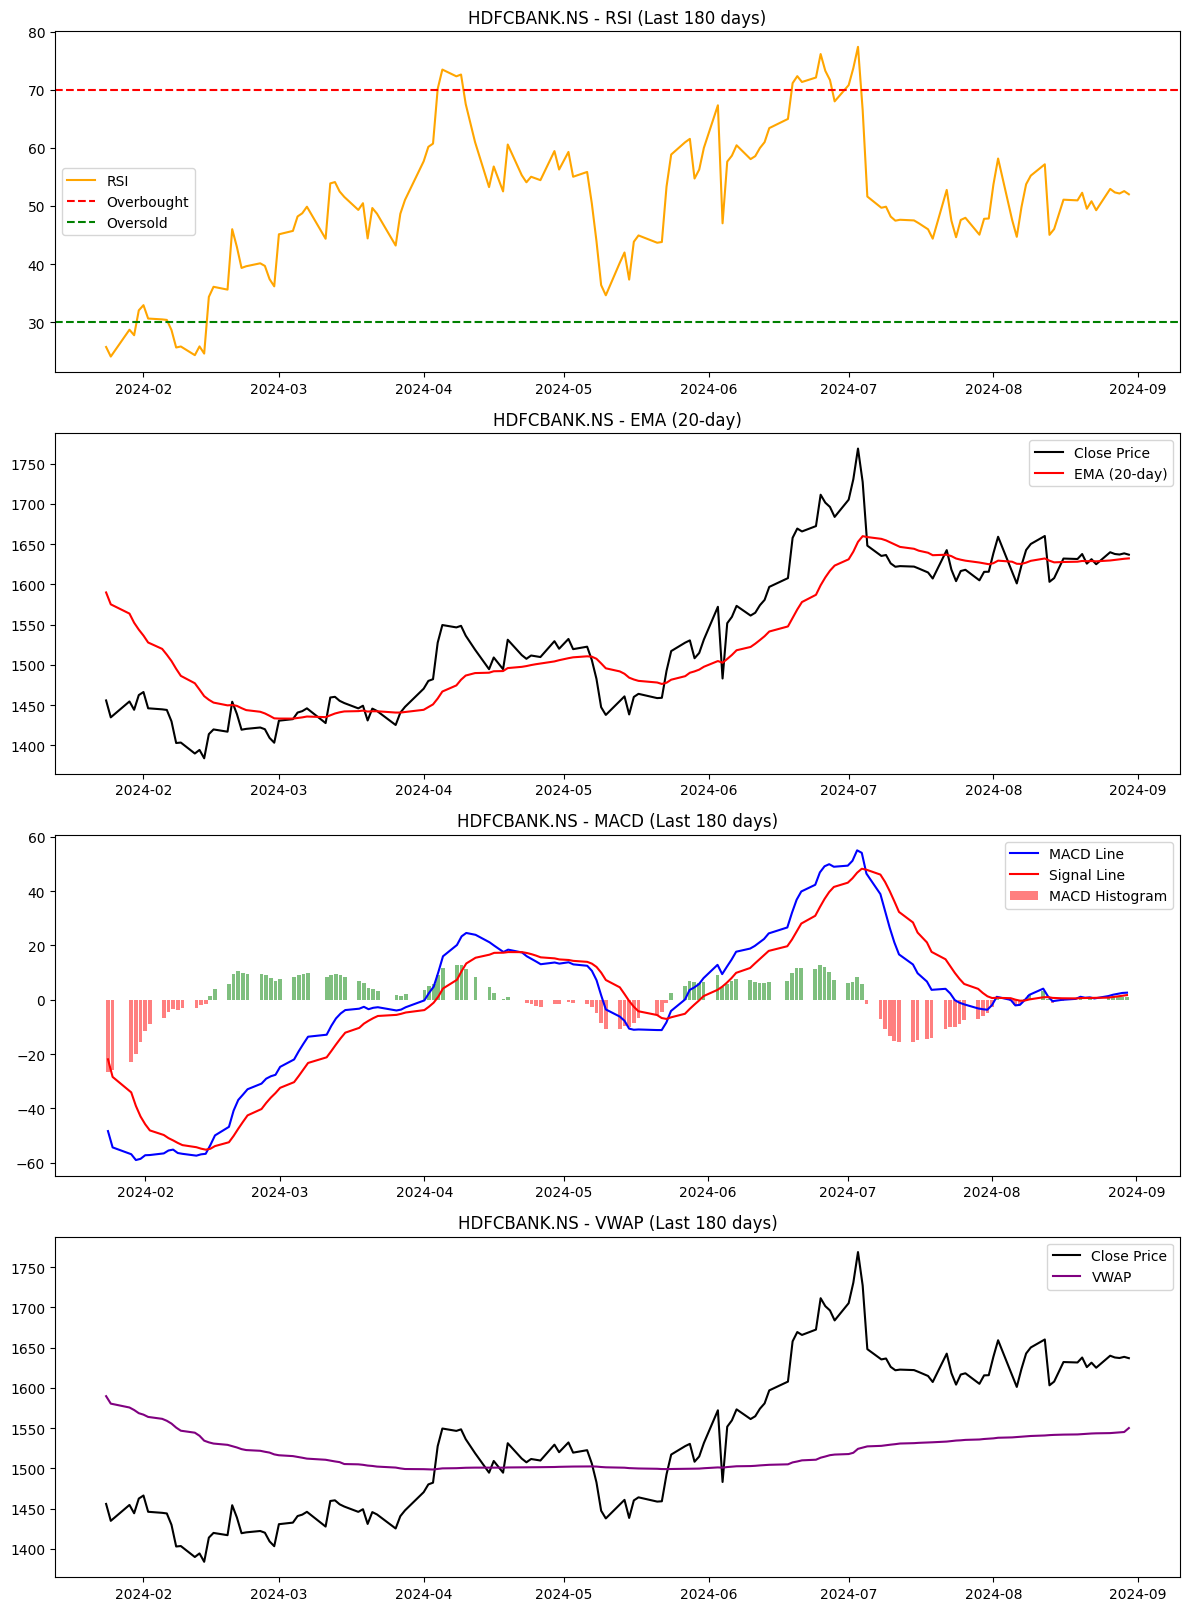

Processing stock: INFY.NS


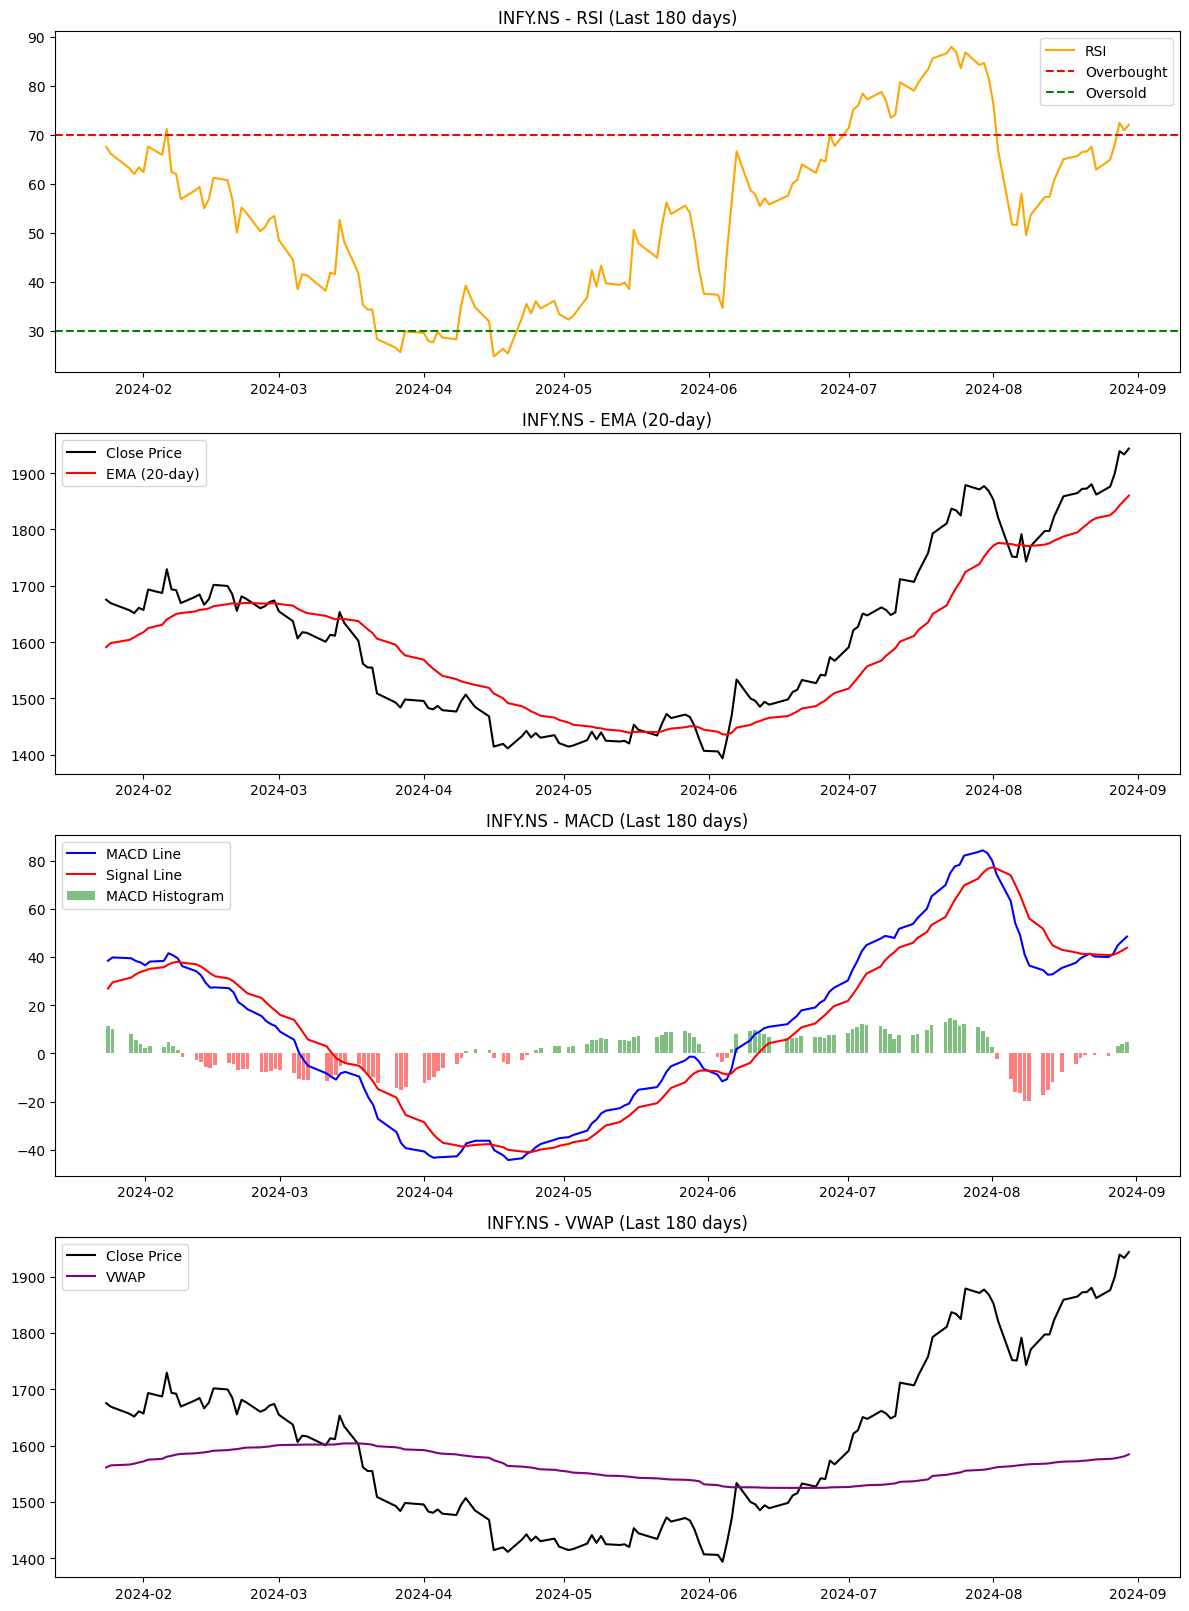

Processing stock: ULTRACEMCO.NS


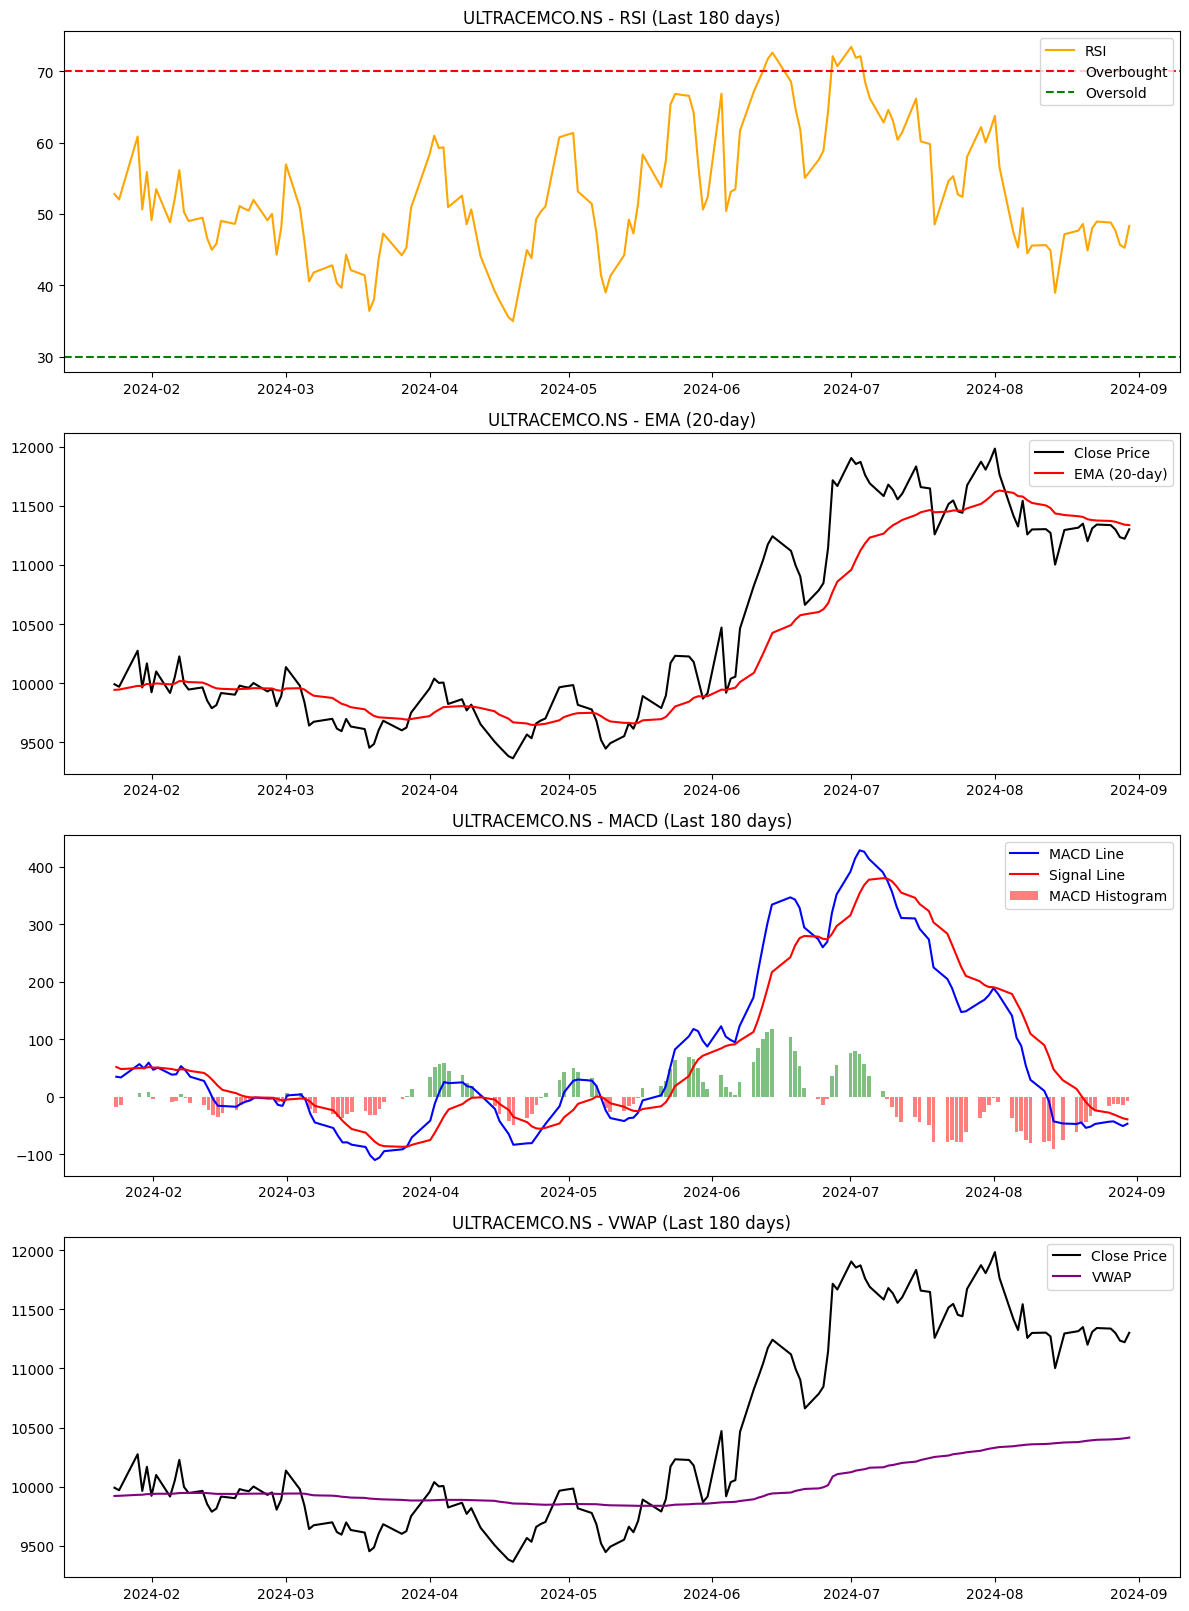

Processing stock: MAHLIFE.BO


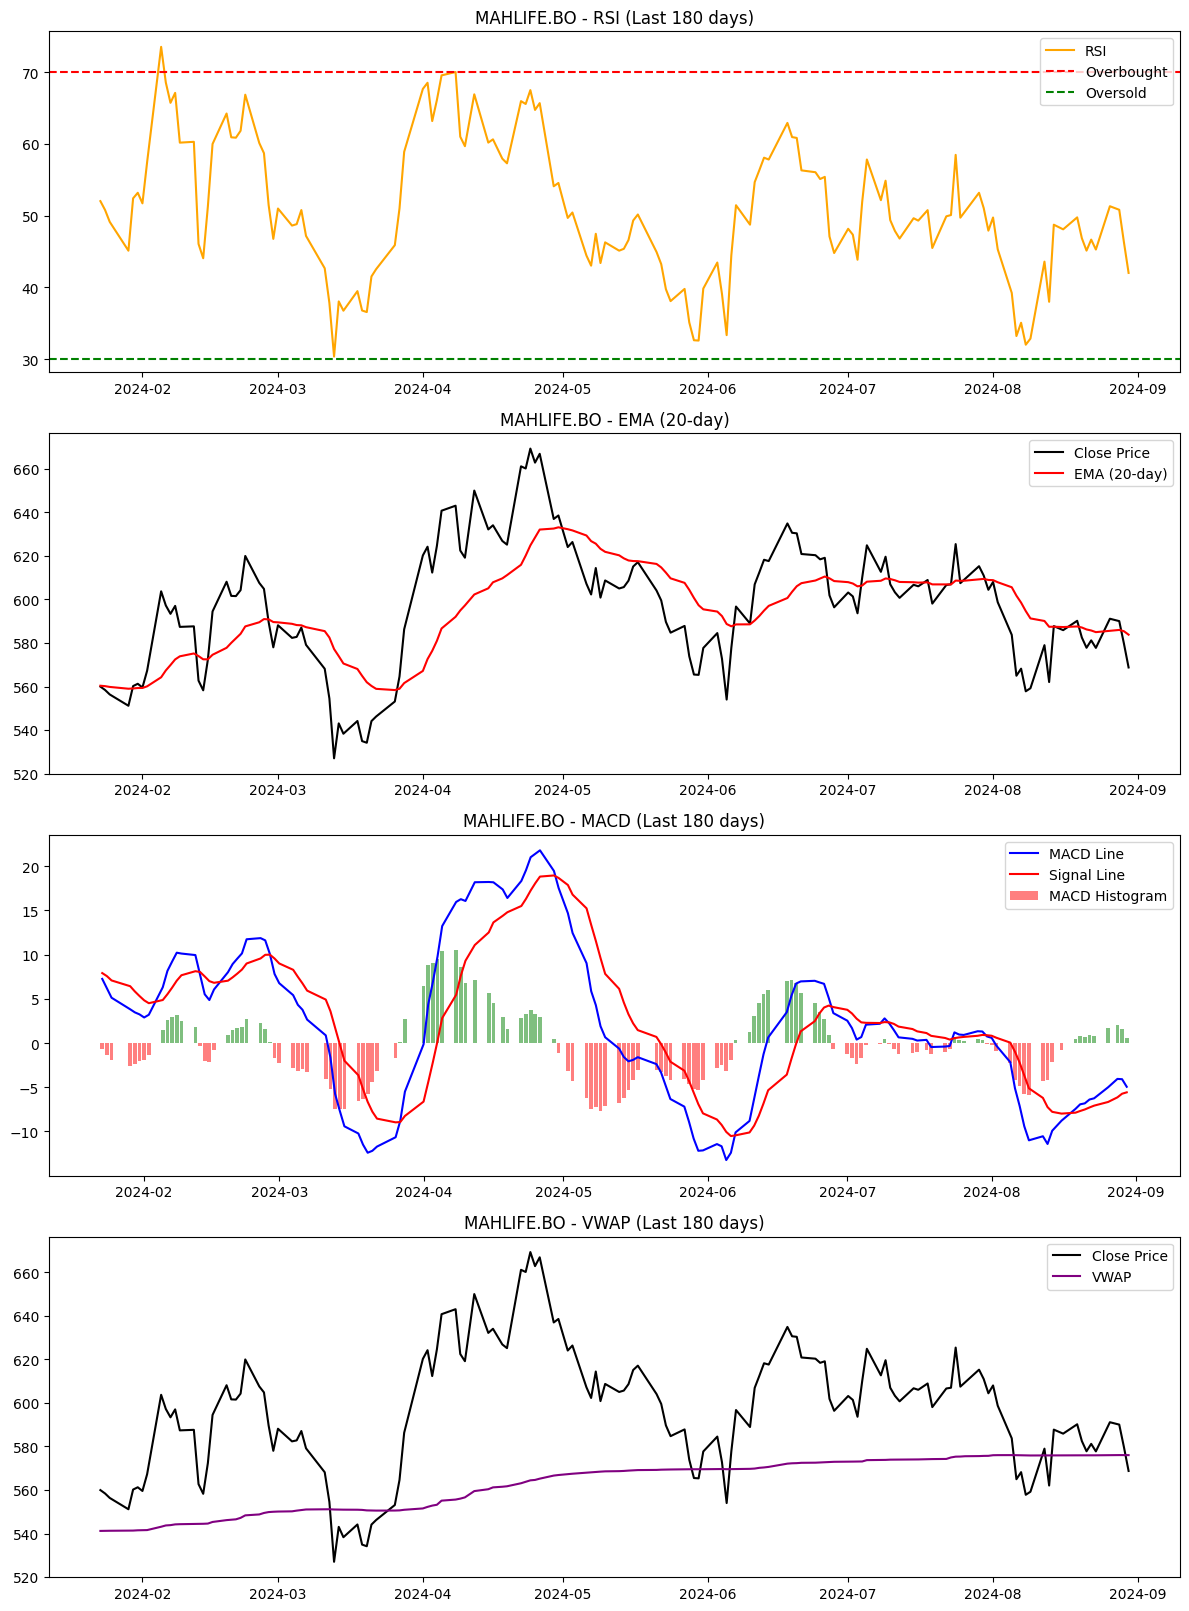

Processing stock: ADANIGREEN.BO


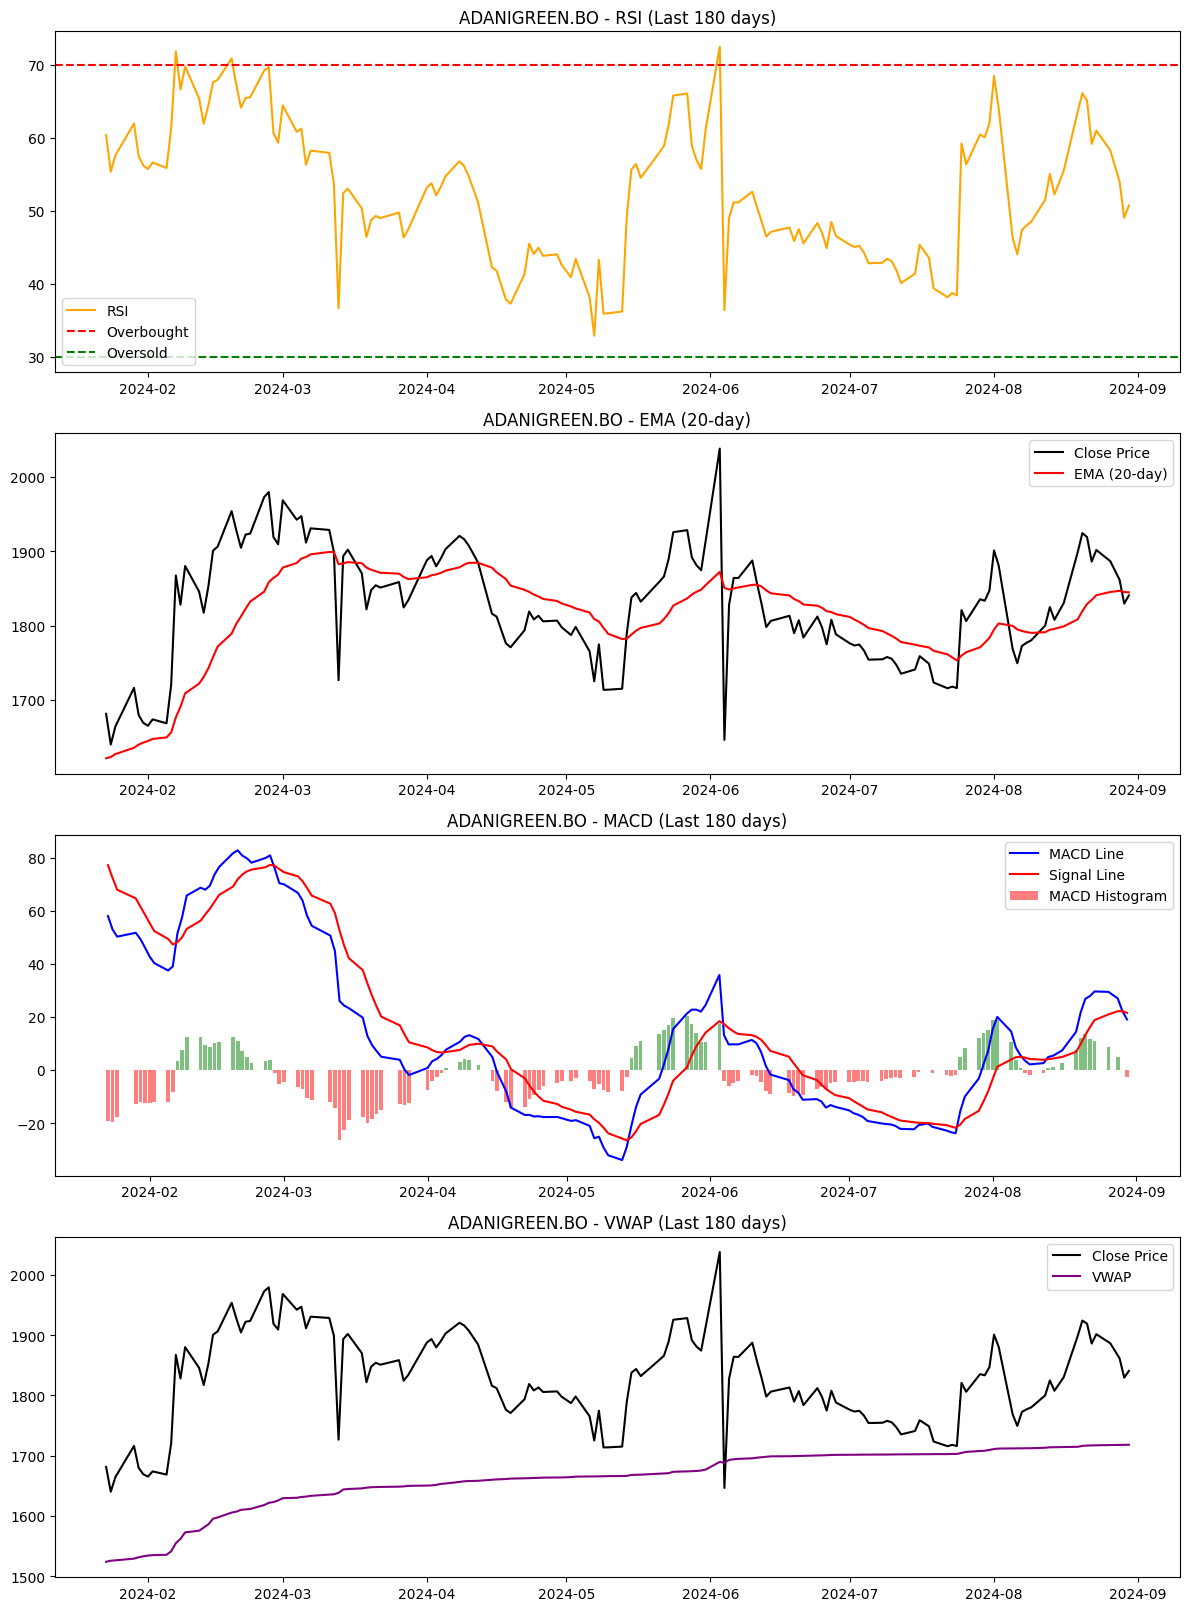

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta  # Technical Analysis library

# Function to calculate VWAP
def calculate_vwap(df):
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()
    return df

# Loop through each DataFrame in stocks to plot indicators
for stock_data in stocks:
    # Extract the stock name from the DataFrame
    stock_name = stock_data['company_name'].iloc[0]
    print(f"Processing stock: {stock_name}")

    # Filter to get only the last 180 days of data
    last_180_days = stock_data.tail(180).copy()  # Create a copy to avoid SettingWithCopyWarning

    # Calculate VWAP
    last_180_days = calculate_vwap(last_180_days)

    # Calculate technical indicators on the filtered data
    last_180_days.loc[:, 'RSI'] = ta.momentum.RSIIndicator(last_180_days['Close']).rsi()
    last_180_days.loc[:, 'EMA'] = ta.trend.EMAIndicator(last_180_days['Close'], window=20).ema_indicator()  # 20-day EMA
    macd_indicator = ta.trend.MACD(last_180_days['Close'])
    last_180_days.loc[:, 'MACD_Line'] = macd_indicator.macd()
    last_180_days.loc[:, 'Signal_Line'] = macd_indicator.macd_signal()
    last_180_days.loc[:, 'MACD_Histogram'] = macd_indicator.macd_diff()

    # Drop any rows with NaN values that result from the rolling mean or other indicators
    last_180_days.dropna(inplace=True)

    # Plotting
    plt.figure(figsize=(12, 20))

    # Plot RSI
    plt.subplot(5, 1, 1)
    plt.plot(last_180_days.index, last_180_days['RSI'], label='RSI', color='orange')
    plt.axhline(y=70, color='r', linestyle='--', label='Overbought')
    plt.axhline(y=30, color='g', linestyle='--', label='Oversold')
    plt.title(f'{stock_name} - RSI (Last 180 days)')
    plt.legend()

    # Plot EMA
    plt.subplot(5, 1, 2)
    plt.plot(last_180_days['Close'], label='Close Price', color='black')
    plt.plot(last_180_days['EMA'], label='EMA (20-day)', color='red')  # 20-day EMA
    plt.title(f'{stock_name} - EMA (20-day)')
    plt.legend()

    # Plot MACD
    plt.subplot(5, 1, 3)
    plt.plot(last_180_days['MACD_Line'], label='MACD Line', color='blue')
    plt.plot(last_180_days['Signal_Line'], label='Signal Line', color='red')

    # Plot MACD Histogram with conditional coloring
    macd_histogram = last_180_days['MACD_Histogram']
    colors = ['green' if value >= 0 else 'red' for value in macd_histogram]
    plt.bar(last_180_days.index, macd_histogram, color=colors, label='MACD Histogram', alpha=0.5)
    
    plt.title(f'{stock_name} - MACD (Last 180 days)')
    plt.legend()

    # Plot VWAP
    plt.subplot(5, 1, 4)
    plt.plot(last_180_days['Close'], label='Close Price', color='black')
    plt.plot(last_180_days['VWAP'], label='VWAP', color='purple')
    plt.title(f'{stock_name} - VWAP (Last 180 days)')
    plt.legend()

    # Show plots
    plt.tight_layout()
    plt.show()


## Now we will predict price of TCS 

In [32]:
predicted_prices_list = []
previous_close_prices_list = []


In [33]:
df = stocks[0]
stock_name = tech_list[0]  # Assuming tech_list contains the names of stocks
print(f"Processing stock: {stock_name}")

Processing stock: TCS.NS


In [34]:
df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()
df['EMA'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()
df['MACD'] = ta.trend.MACD(df['Close']).macd()
df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

# Drop any rows with NaN values that result from the rolling mean or other indicators
df.dropna(inplace=True)

## Creating training and validation set

In [35]:
data = df.filter(['Close', 'RSI', 'EMA', 'MACD', 'VWAP'])
dataset = data.values
training_data_len = int(np.ceil(len(dataset) * .95))


training_data_len

2295

### Scaling 

In [36]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Save the scaler to a file
joblib.dump(scaler, f'scaler_{stock_name}.pkl')

['scaler_TCS.NS.pkl']

In [37]:
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for j in range(100, len(train_data)):
    x_train.append(train_data[j-100:j, :])  # Include all features
    y_train.append(train_data[j, 0])  # Predict the Close price

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))


## Model Training using LSTM

In [38]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)


C:\Users\dell\anaconda3\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2195/2195 ━━━━━━━━━━━━━━━━━━━━ 76s 32ms/step - loss: 0.0027


## Error Calculations

In [39]:
test_data = scaled_data[training_data_len - 100:, :]
x_test = []
y_test = dataset[training_data_len:, 0]  # Actual close prices for testing

for j in range(100, len(test_data)):
    x_test.append(test_data[j-100:j, :])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

# Calculate RMSE
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f"RMSE for {stock_name}: {rmse:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step
RMSE for TCS.NS: 84.5048


## Trends Capturing

In [44]:
train = data[:training_data_len]
valid = data[training_data_len:].copy()  # Make a copy of valid

# Assign predictions
valid['Predictions'] = predictions

# Calculate trends and matching trends for the last 50 rows
valid['Close_Trend'] = valid['Close'].diff().apply(lambda x: 1 if x > 0 else 0)
valid['Prediction_Trend'] = valid['Predictions'].diff().apply(lambda x: 1 if x > 0 else 0)

# Focus only on the last 50 rows
valid_last_50 = valid.tail(50).copy()
valid_last_50['Trend_Same'] = (valid_last_50['Close_Trend'] == valid_last_50['Prediction_Trend']).astype(int)

# Count matching trends for the last 50 rows
same_trend_count_last_50 = valid_last_50['Trend_Same'].sum()

# Print the trimmed valid DataFrame
print(f"\n{'='*50}\nLast 50 rows for {stock_name}:\n")
print(tabulate(valid_last_50, headers='keys', tablefmt='fancy_grid'))

# Display the number of matching trends for the last 50 rows
print(f"\nNumber of matching trends for the last 50 rows of {stock_name}: {same_trend_count_last_50}")



Last 50 rows for TCS.NS:

╒═════════════════════╤═════════╤═════════╤═════════╤═══════════╤═════════╤═══════════════╤═══════════════╤════════════════════╤══════════════╕
│ Date                │   Close │     RSI │     EMA │      MACD │    VWAP │   Predictions │   Close_Trend │   Prediction_Trend │   Trend_Same │
╞═════════════════════╪═════════╪═════════╪═════════╪═══════════╪═════════╪═══════════════╪═══════════════╪════════════════════╪══════════════╡
│ 2024-06-20 00:00:00 │ 3787.25 │ 44.918  │ 3823.33 │ -12.7894  │ 2256.37 │       3814.46 │             0 │                  0 │            1 │
├─────────────────────┼─────────┼─────────┼─────────┼───────────┼─────────┼───────────────┼───────────────┼────────────────────┼──────────────┤
│ 2024-06-21 00:00:00 │ 3810.75 │ 47.7377 │ 3822.13 │ -12.3782  │ 2257.49 │       3801.05 │             1 │                  0 │            0 │
├─────────────────────┼─────────┼─────────┼─────────┼───────────┼─────────┼───────────────┼───────────────┼──

### Price Prediction for next day

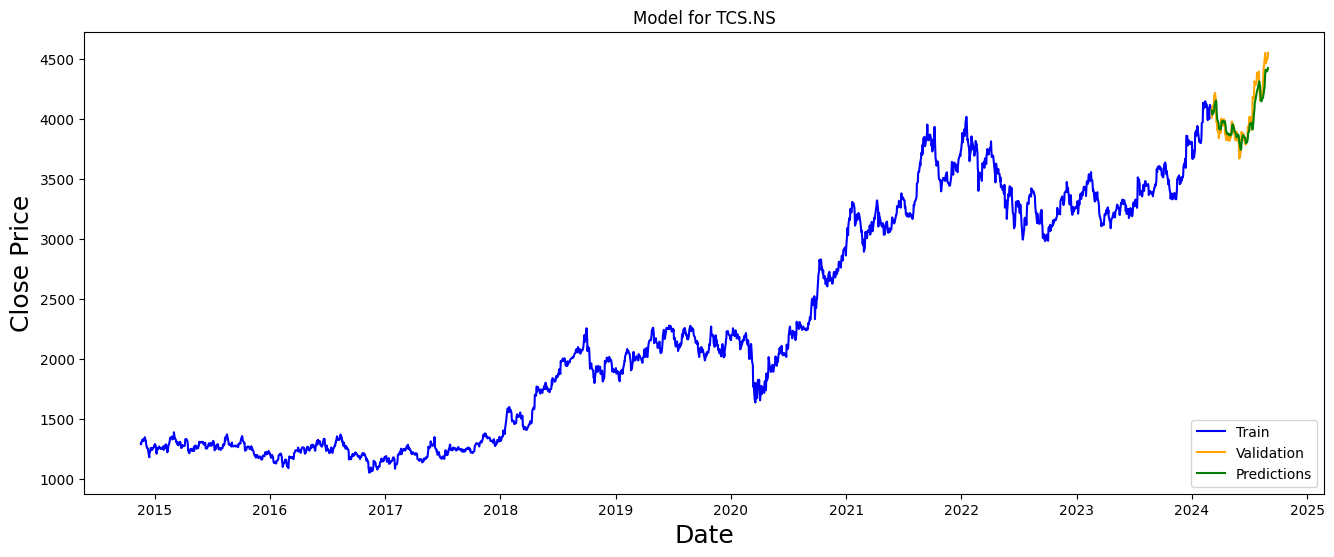

In [45]:
plt.figure(figsize=(16, 6))
plt.title(f'Model for {stock_name}')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'], label='Train', color='blue')
plt.plot(valid['Close'], label='Validation', color='orange')
plt.plot(valid['Predictions'], label='Predictions', color='green')
plt.legend(loc='lower right')
plt.show()

In [46]:
last_100_days = scaled_data[-100:]
last_100_days = np.reshape(last_100_days, (1, last_100_days.shape[0], last_100_days.shape[1]))
future_pred = model.predict(last_100_days)
future_pred = scaler.inverse_transform(np.concatenate((future_pred, np.zeros((future_pred.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

print("Tomorrow's price of TCS is ",future_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tomorrow's price of TCS is  [4448.93736261]


## Analysing each stock in list

Processing stock: TCS.NS


C:\Users\dell\anaconda3\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2171/2171 ━━━━━━━━━━━━━━━━━━━━ 70s 30ms/step - loss: 0.0033
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
RMSE for TCS.NS: 113.6386

Last 50 rows for TCS.NS:

╒═════════════════════╤═════════╤═════════╤═════════╤═══════════╤═════════╤═══════════════╤═══════════════╤════════════════════╤══════════════╕
│ Date                │   Close │     RSI │     EMA │      MACD │    VWAP │   Predictions │   Close_Trend │   Prediction_Trend │   Trend_Same │
╞═════════════════════╪═════════╪═════════╪═════════╪═══════════╪═════════╪═══════════════╪═══════════════╪════════════════════╪══════════════╡
│ 2024-06-20 00:00:00 │ 3787.25 │ 44.918  │ 3823.33 │ -12.7894  │ 2272.51 │       3749.9  │             0 │                  0 │            1 │
├─────────────────────┼─────────┼─────────┼─────────┼───────────┼─────────┼───────────────┼───────────────┼────────────────────┼──────────────┤
│ 2024-06-21 00:00:00 │ 3810.75 │ 47.7377 │ 3822.13 │ -12.3782  │ 2273.64 │       3730.35 │             1 │                  0 │

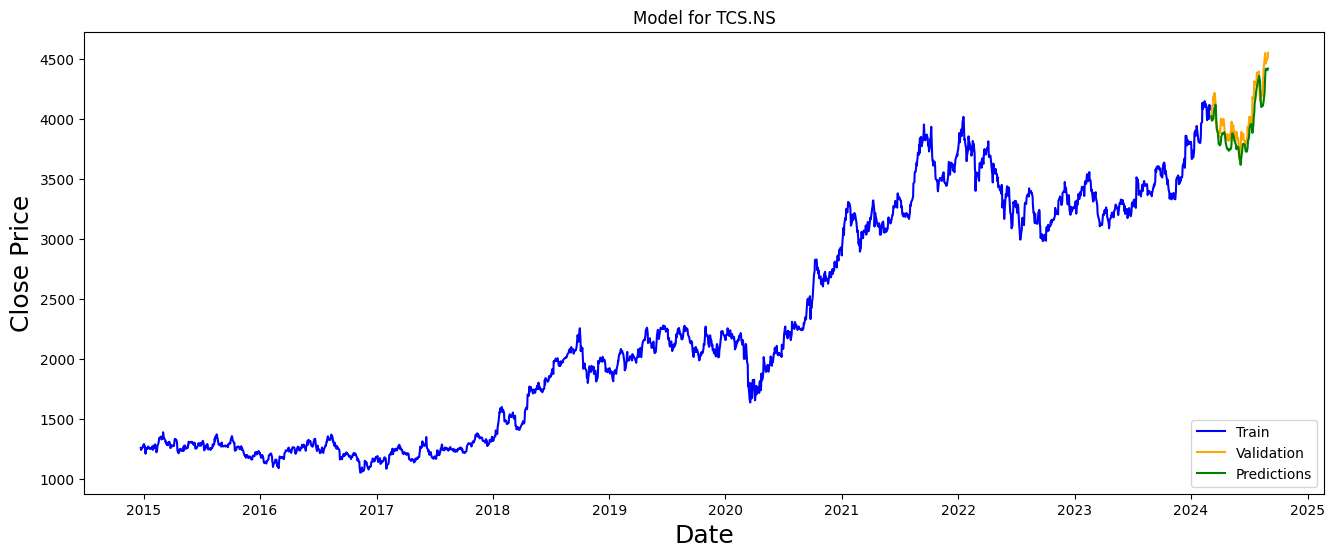

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Processing stock: NESTLEIND.NS


C:\Users\dell\anaconda3\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2195/2195 ━━━━━━━━━━━━━━━━━━━━ 75s 32ms/step - loss: 0.0060
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step WARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000210F2878F40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step
RMSE for NESTLEIND.NS: 115.5122

Last 50 rows for NESTLEIND.NS:

╒═════════════════════╤═════════╤═════════╤═════════╤════════════╤═════

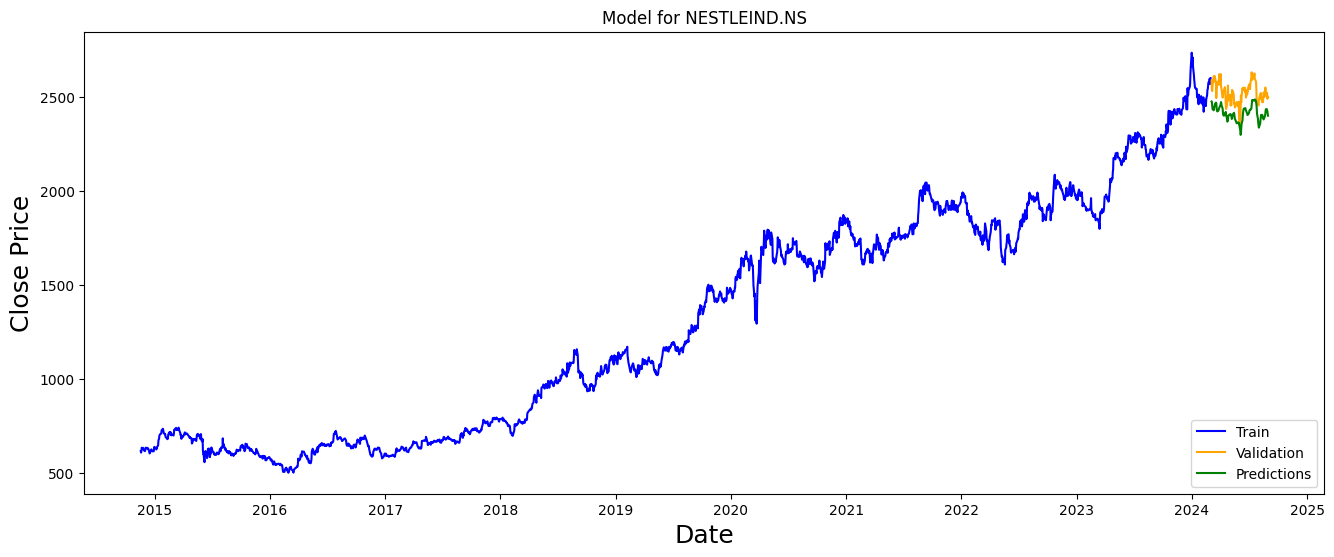

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Processing stock: TITAN.NS


C:\Users\dell\anaconda3\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2195/2195 ━━━━━━━━━━━━━━━━━━━━ 76s 33ms/step - loss: 0.0029
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step
RMSE for TITAN.NS: 162.6488

Last 50 rows for TITAN.NS:

╒═════════════════════╤═════════╤═════════╤═════════╤════════════╤═════════╤═══════════════╤═══════════════╤════════════════════╤══════════════╕
│ Date                │   Close │     RSI │     EMA │       MACD │    VWAP │   Predictions │   Close_Trend │   Prediction_Trend │   Trend_Same │
╞═════════════════════╪═════════╪═════════╪═════════╪════════════╪═════════╪═══════════════╪═══════════════╪════════════════════╪══════════════╡
│ 2024-06-20 00:00:00 │ 3435.95 │ 51.267  │ 3419.19 │  17.7439   │ 1244.3  │       3352.61 │             0 │                  0 │            1 │
├─────────────────────┼─────────┼─────────┼─────────┼────────────┼─────────┼───────────────┼───────────────┼────────────────────┼──────────────┤
│ 2024-06-21 00:00:00 │ 3399.75 │ 48.501  │ 3417.34 │  13.4641   │ 1245.65 │       3337.2  │             0 │           

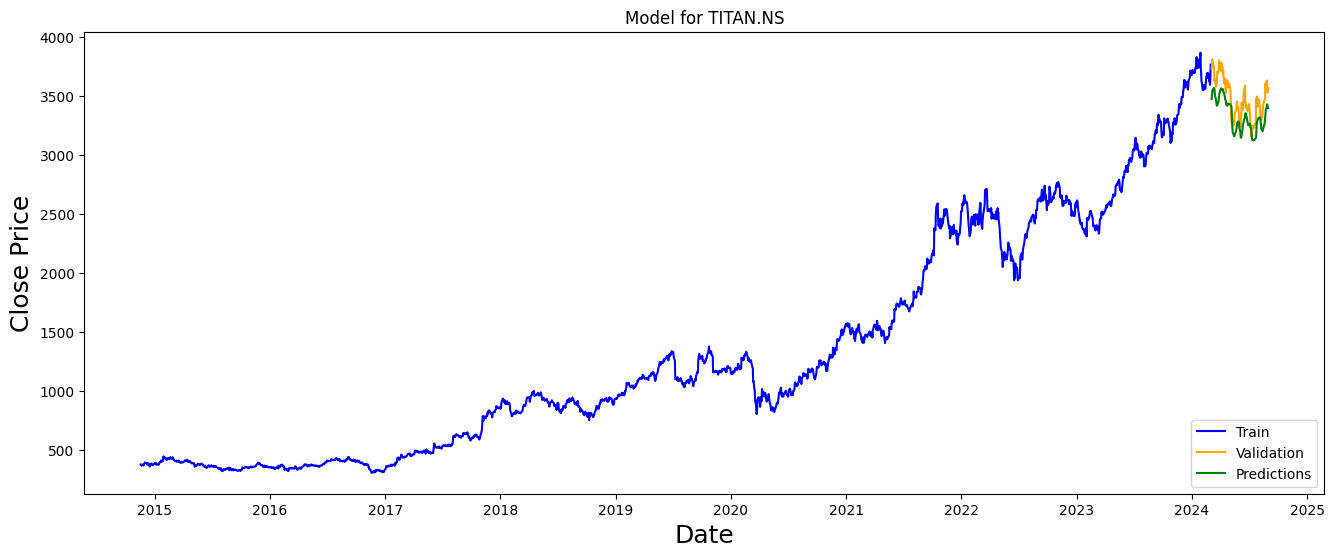

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Processing stock: ASTRAL.BO


C:\Users\dell\anaconda3\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2178/2178 ━━━━━━━━━━━━━━━━━━━━ 76s 33ms/step - loss: 0.0033
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
RMSE for ASTRAL.BO: 72.2942

Last 50 rows for ASTRAL.BO:

╒═════════════════════╤═════════╤═════════╤═════════╤════════════╤═════════╤═══════════════╤═══════════════╤════════════════════╤══════════════╕
│ Date                │   Close │     RSI │     EMA │       MACD │    VWAP │   Predictions │   Close_Trend │   Prediction_Trend │   Trend_Same │
╞═════════════════════╪═════════╪═════════╪═════════╪════════════╪═════════╪═══════════════╪═══════════════╪════════════════════╪══════════════╡
│ 2024-06-19 00:00:00 │ 2203.1  │ 54.6984 │ 2173.54 │  34.7424   │ 591.229 │       2172.05 │             0 │                  1 │            0 │
├─────────────────────┼─────────┼─────────┼─────────┼────────────┼─────────┼───────────────┼───────────────┼────────────────────┼──────────────┤
│ 2024-06-20 00:00:00 │ 2212.65 │ 55.5899 │ 2177.26 │  33.5618   │ 591.269 │       2166.91 │             1 │          

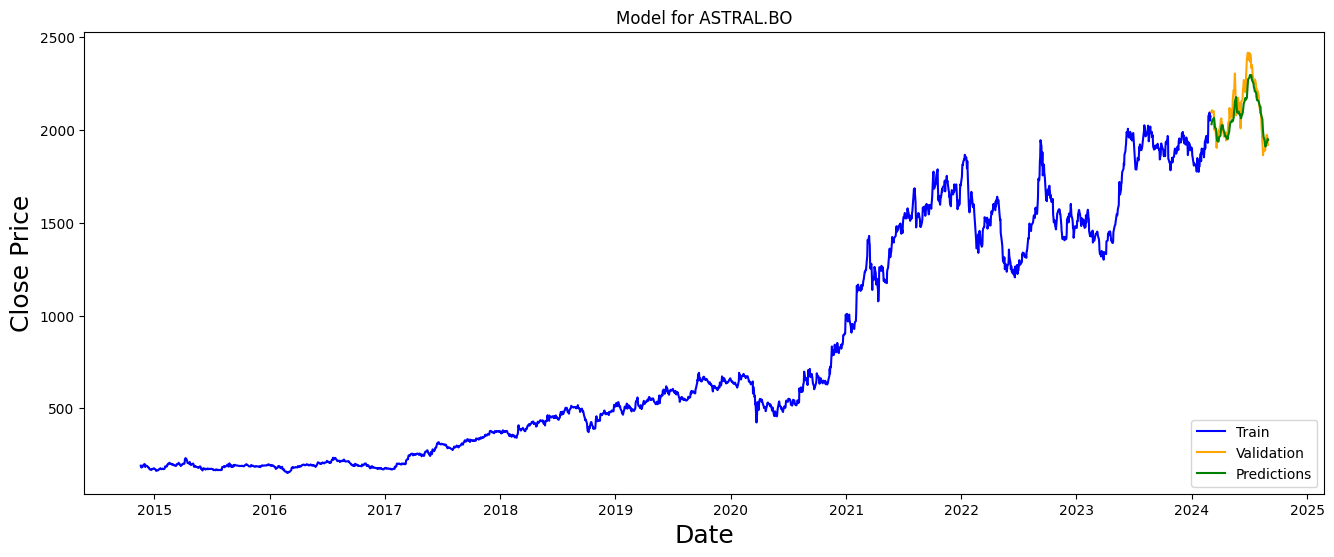

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Processing stock: TATAPOWER.NS


C:\Users\dell\anaconda3\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2195/2195 ━━━━━━━━━━━━━━━━━━━━ 77s 33ms/step - loss: 0.0026
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step
RMSE for TATAPOWER.NS: 43.7301

Last 50 rows for TATAPOWER.NS:

╒═════════════════════╤═════════╤═════════╤═════════╤════════════╤═════════╤═══════════════╤═══════════════╤════════════════════╤══════════════╕
│ Date                │   Close │     RSI │     EMA │       MACD │    VWAP │   Predictions │   Close_Trend │   Prediction_Trend │   Trend_Same │
╞═════════════════════╪═════════╪═════════╪═════════╪════════════╪═════════╪═══════════════╪═══════════════╪════════════════════╪══════════════╡
│ 2024-06-20 00:00:00 │  443.65 │ 52.1899 │ 441.342 │  4.0925    │ 153.595 │       403.462 │             1 │                  0 │            0 │
├─────────────────────┼─────────┼─────────┼─────────┼────────────┼─────────┼───────────────┼───────────────┼────────────────────┼──────────────┤
│ 2024-06-21 00:00:00 │  438.7  │ 49.7043 │ 441.091 │  3.38972   │ 153.719 │       402.808 │             0 │    

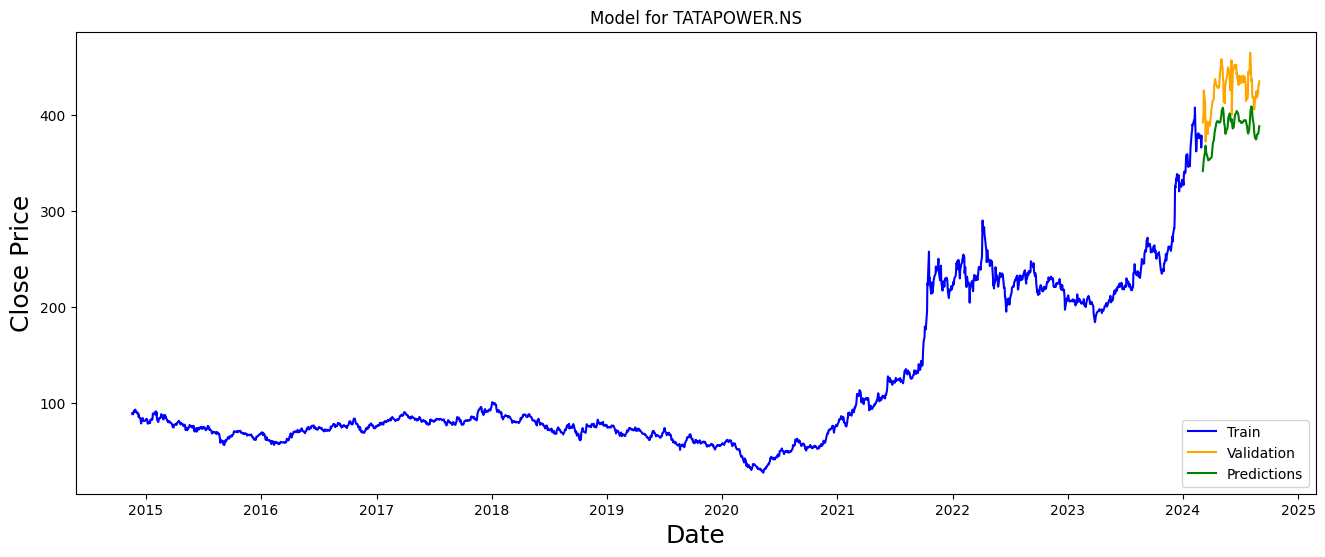

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Processing stock: SUZLON.NS


C:\Users\dell\anaconda3\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2195/2195 ━━━━━━━━━━━━━━━━━━━━ 74s 32ms/step - loss: 0.0012
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
RMSE for SUZLON.NS: 3.9608

Last 50 rows for SUZLON.NS:

╒═════════════════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═══════════════╤═══════════════╤════════════════════╤══════════════╕
│ Date                │   Close │     RSI │     EMA │    MACD │    VWAP │   Predictions │   Close_Trend │   Prediction_Trend │   Trend_Same │
╞═════════════════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════════════╪═══════════════╪════════════════════╪══════════════╡
│ 2024-06-20 00:00:00 │   50.53 │ 61.1034 │ 47.9189 │ 1.76965 │ 14.4841 │       49.701  │             1 │                  0 │            0 │
├─────────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────────────┼───────────────┼────────────────────┼──────────────┤
│ 2024-06-21 00:00:00 │   53.05 │ 66.5549 │ 48.4076 │ 1.96366 │ 14.527  │       49.8963 │             1 │                  1 │        

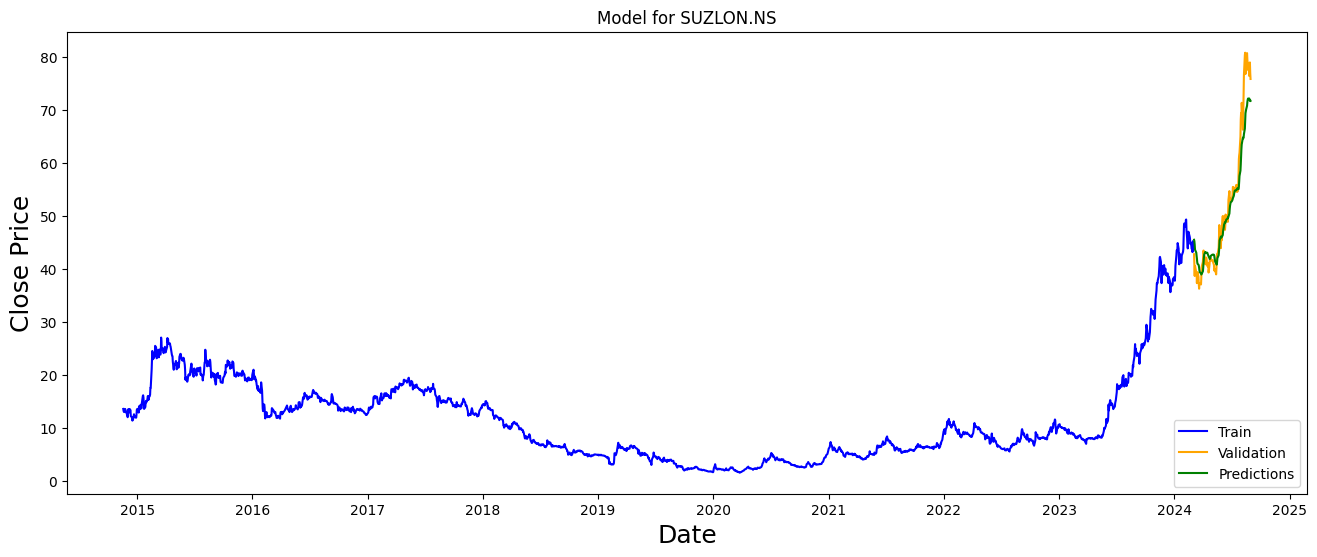

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Processing stock: HINDPETRO.BO


C:\Users\dell\anaconda3\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2193/2193 ━━━━━━━━━━━━━━━━━━━━ 74s 32ms/step - loss: 0.0064
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
RMSE for HINDPETRO.BO: 12.8013

Last 50 rows for HINDPETRO.BO:

╒═════════════════════╤═════════╤═════════╤═════════╤════════════╤═════════╤═══════════════╤═══════════════╤════════════════════╤══════════════╕
│ Date                │   Close │     RSI │     EMA │       MACD │    VWAP │   Predictions │   Close_Trend │   Prediction_Trend │   Trend_Same │
╞═════════════════════╪═════════╪═════════╪═════════╪════════════╪═════════╪═══════════════╪═══════════════╪════════════════════╪══════════════╡
│ 2024-06-19 00:00:00 │ 343.8   │ 47.8151 │ 349.734 │  2.18302   │ 167.447 │       348.756 │             0 │                  1 │            0 │
├─────────────────────┼─────────┼─────────┼─────────┼────────────┼─────────┼───────────────┼───────────────┼────────────────────┼──────────────┤
│ 2024-06-20 00:00:00 │ 349.267 │ 50.5189 │ 349.689 │  1.91516   │ 167.523 │       346.529 │             1 │    

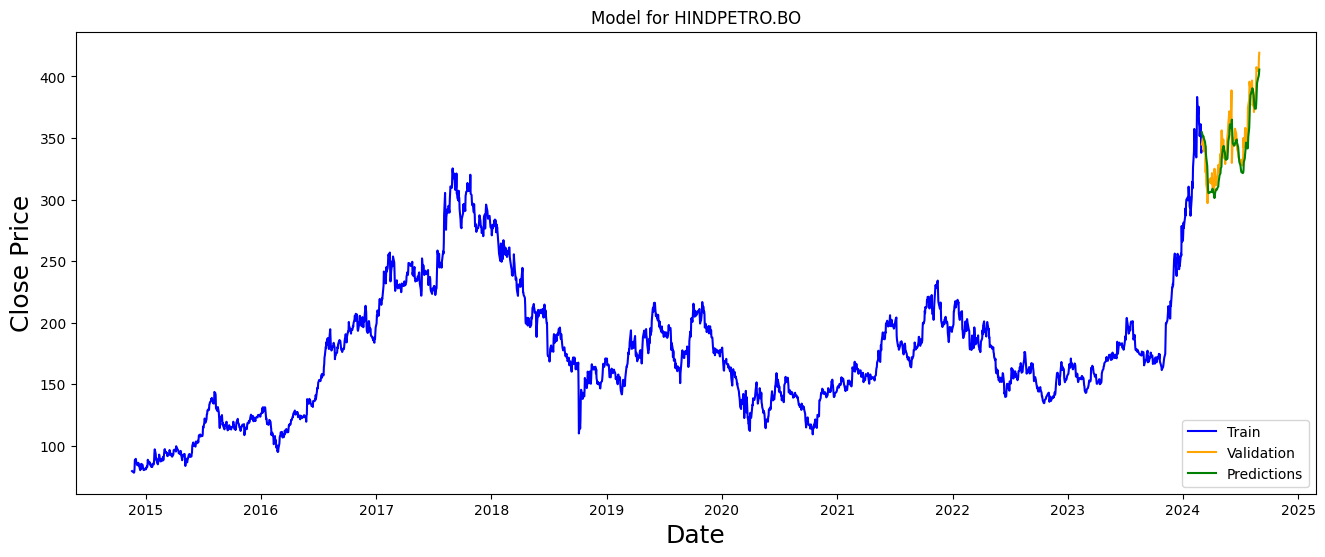

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Processing stock: HDFCBANK.NS


C:\Users\dell\anaconda3\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2195/2195 ━━━━━━━━━━━━━━━━━━━━ 77s 33ms/step - loss: 0.0043
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
RMSE for HDFCBANK.NS: 127.4783

Last 50 rows for HDFCBANK.NS:

╒═════════════════════╤═════════╤═════════╤═════════╤════════════╤═════════╤═══════════════╤═══════════════╤════════════════════╤══════════════╕
│ Date                │   Close │     RSI │     EMA │       MACD │    VWAP │   Predictions │   Close_Trend │   Prediction_Trend │   Trend_Same │
╞═════════════════════╪═════════╪═════════╪═════════╪════════════╪═════════╪═══════════════╪═══════════════╪════════════════════╪══════════════╡
│ 2024-06-20 00:00:00 │ 1669.35 │ 72.3226 │ 1568.86 │ 36.798     │ 1259.85 │       1479.07 │             1 │                  1 │            1 │
├─────────────────────┼─────────┼─────────┼─────────┼────────────┼─────────┼───────────────┼───────────────┼────────────────────┼──────────────┤
│ 2024-06-21 00:00:00 │ 1665.75 │ 71.321  │ 1578.09 │ 39.8432    │ 1260.39 │       1493.39 │             0 │     

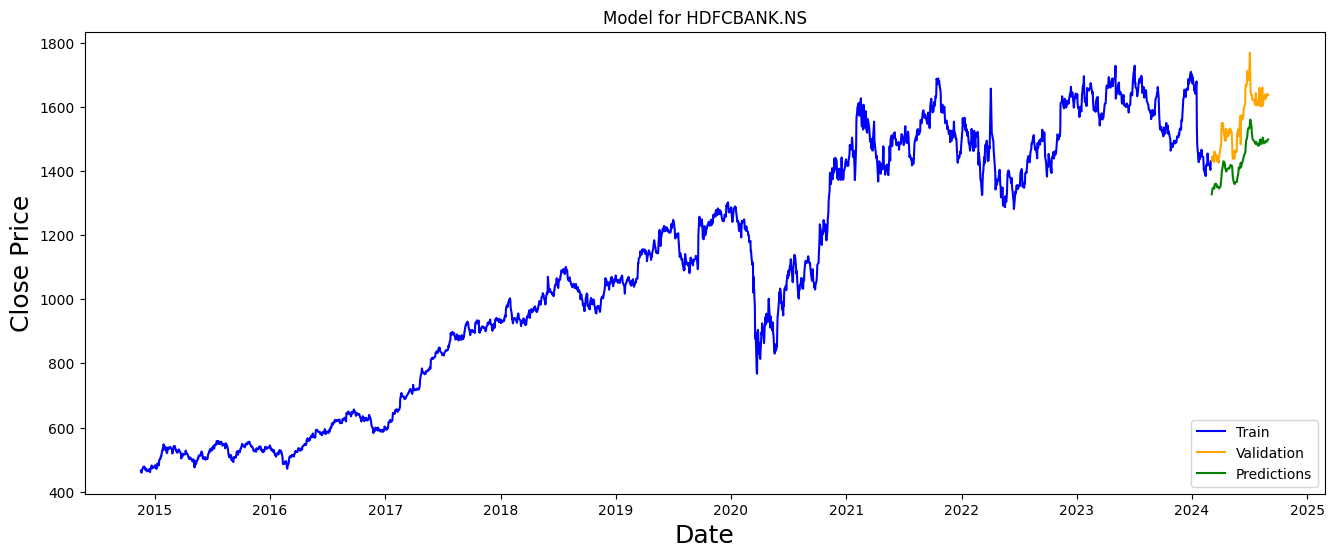

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Processing stock: INFY.NS


C:\Users\dell\anaconda3\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2195/2195 ━━━━━━━━━━━━━━━━━━━━ 79s 33ms/step - loss: 0.0037
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step
RMSE for INFY.NS: 88.5532

Last 50 rows for INFY.NS:

╒═════════════════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═══════════════╤═══════════════╤════════════════════╤══════════════╕
│ Date                │   Close │     RSI │     EMA │    MACD │    VWAP │   Predictions │   Close_Trend │   Prediction_Trend │   Trend_Same │
╞═════════════════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════════════╪═══════════════╪════════════════════╪══════════════╡
│ 2024-06-20 00:00:00 │ 1515.4  │ 60.8291 │ 1476.77 │ 15.42   │ 885.464 │       1596.51 │             1 │                  1 │            1 │
├─────────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────────────┼───────────────┼────────────────────┼──────────────┤
│ 2024-06-21 00:00:00 │ 1532.7  │ 63.9657 │ 1482.1  │ 17.8326 │ 886.026 │       1605.22 │             1 │                  1 │           

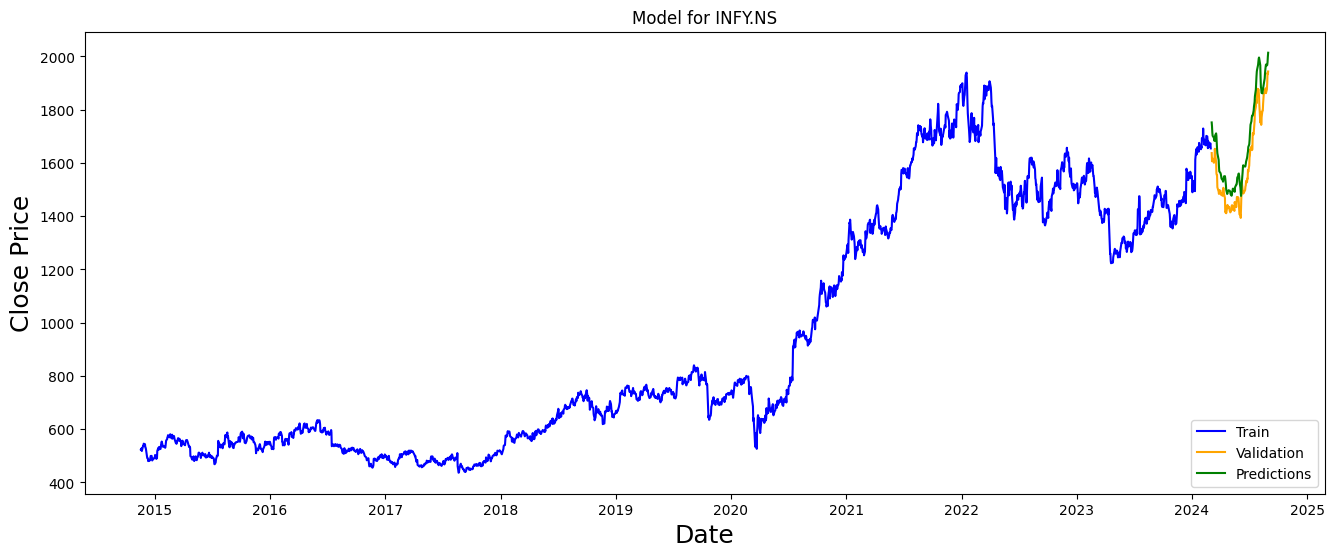

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Processing stock: ULTRACEMCO.NS


C:\Users\dell\anaconda3\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2195/2195 ━━━━━━━━━━━━━━━━━━━━ 78s 34ms/step - loss: 0.0024
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
RMSE for ULTRACEMCO.NS: 281.7736

Last 50 rows for ULTRACEMCO.NS:

╒═════════════════════╤═════════╤═════════╤═════════╤═══════════╤═════════╤═══════════════╤═══════════════╤════════════════════╤══════════════╕
│ Date                │   Close │     RSI │     EMA │      MACD │    VWAP │   Predictions │   Close_Trend │   Prediction_Trend │   Trend_Same │
╞═════════════════════╪═════════╪═════════╪═════════╪═══════════╪═════════╪═══════════════╪═══════════════╪════════════════════╪══════════════╡
│ 2024-06-20 00:00:00 │ 10903.2 │ 61.8053 │ 10573.9 │ 328.512   │ 5152.81 │       11057.4 │             0 │                  0 │            1 │
├─────────────────────┼─────────┼─────────┼─────────┼───────────┼─────────┼───────────────┼───────────────┼────────────────────┼──────────────┤
│ 2024-06-21 00:00:00 │ 10662.4 │ 55.0411 │ 10582.4 │ 294.343   │ 5156.31 │       11027.7 │             0 │       

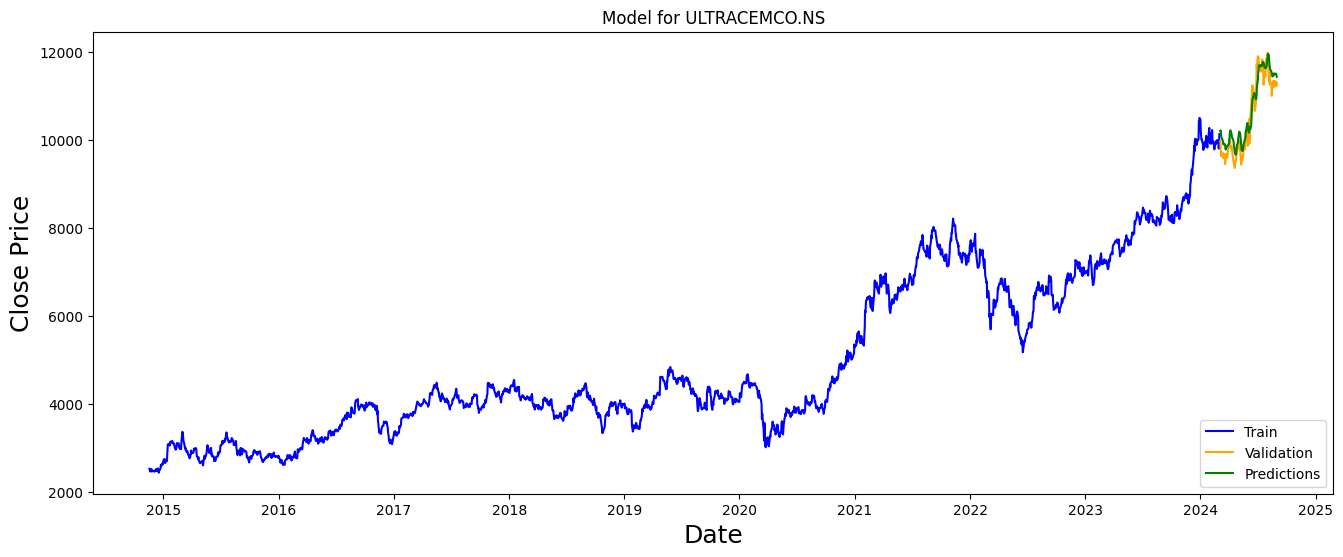

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Processing stock: MAHLIFE.BO


C:\Users\dell\anaconda3\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2176/2176 ━━━━━━━━━━━━━━━━━━━━ 73s 32ms/step - loss: 0.0039
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step
RMSE for MAHLIFE.BO: 25.8142

Last 50 rows for MAHLIFE.BO:

╒═════════════════════╤═════════╤═════════╤═════════╤════════════╤═════════╤═══════════════╤═══════════════╤════════════════════╤══════════════╕
│ Date                │   Close │     RSI │     EMA │       MACD │    VWAP │   Predictions │   Close_Trend │   Prediction_Trend │   Trend_Same │
╞═════════════════════╪═════════╪═════════╪═════════╪════════════╪═════════╪═══════════════╪═══════════════╪════════════════════╪══════════════╡
│ 2024-06-19 00:00:00 │  630.65 │ 60.9657 │ 603.526 │   5.35822  │ 245.662 │       627.111 │             0 │                  1 │            0 │
├─────────────────────┼─────────┼─────────┼─────────┼────────────┼─────────┼───────────────┼───────────────┼────────────────────┼──────────────┤
│ 2024-06-20 00:00:00 │  630.4  │ 60.8461 │ 606.086 │   6.73488  │ 245.708 │       633.432 │             0 │        

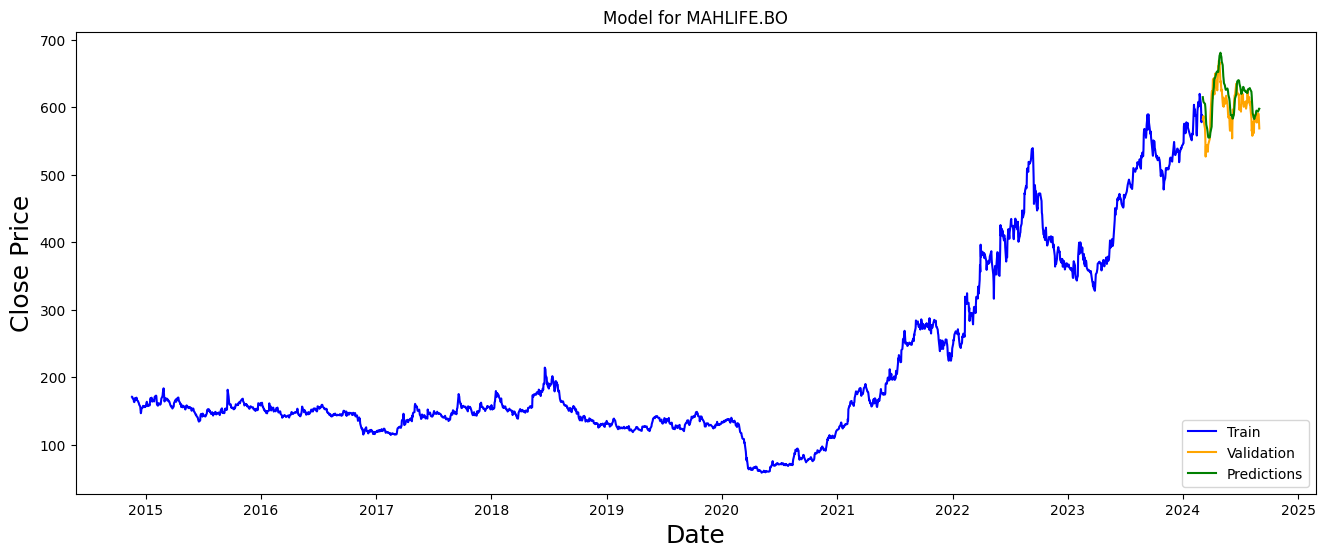

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Processing stock: ADANIGREEN.BO


C:\Users\dell\anaconda3\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1287/1287 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - loss: 0.0076
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step
RMSE for ADANIGREEN.BO: 79.2903

Last 50 rows for ADANIGREEN.BO:

╒═════════════════════╤═════════╤═════════╤═════════╤═══════════╤═════════╤═══════════════╤═══════════════╤════════════════════╤══════════════╕
│ Date                │   Close │     RSI │     EMA │      MACD │    VWAP │   Predictions │   Close_Trend │   Prediction_Trend │   Trend_Same │
╞═════════════════════╪═════════╪═════════╪═════════╪═══════════╪═════════╪═══════════════╪═══════════════╪════════════════════╪══════════════╡
│ 2024-06-19 00:00:00 │ 1789.65 │ 45.831  │ 1835.53 │  -7.24975 │ 781.923 │       1862.71 │             0 │                  0 │            1 │
├─────────────────────┼─────────┼─────────┼─────────┼───────────┼─────────┼───────────────┼───────────────┼────────────────────┼──────────────┤
│ 2024-06-20 00:00:00 │ 1807.05 │ 47.4551 │ 1832.82 │  -8.48651 │ 782.056 │       1854.16 │             1 │        

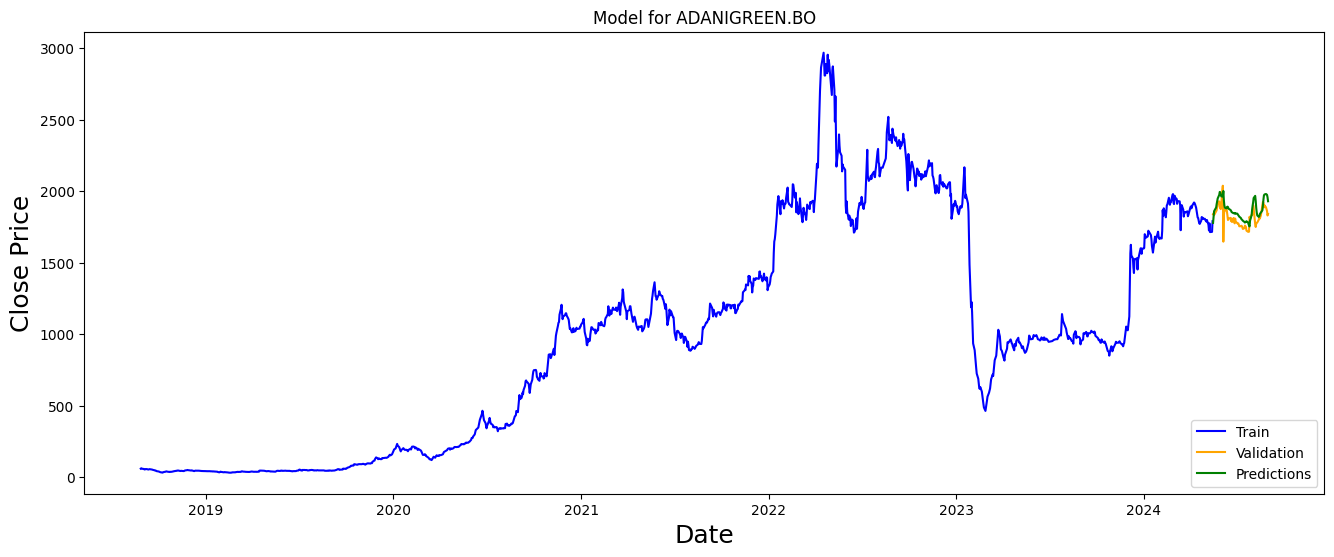

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [47]:


# Lists to store predicted prices and close prices of the previous day for all stocks
predicted_prices_list = []
previous_close_prices_list = []

# Assuming `stocks` is a list of DataFrames for each stock and `tech_list` contains stock names
for i, df in enumerate(stocks):
    stock_name = tech_list[i]  # Assuming tech_list contains the names of stocks
    print(f"Processing stock: {stock_name}")

    # Calculate additional indicators
    df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()
    df['EMA'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()
    df['MACD'] = ta.trend.MACD(df['Close']).macd()
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

    # Drop any rows with NaN values that result from the rolling mean or other indicators
    df.dropna(inplace=True)

    # Prepare the data
    data = df.filter(['Close', 'RSI', 'EMA', 'MACD', 'VWAP'])
    dataset = data.values
    training_data_len = int(np.ceil(len(dataset) * .95))

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Save the scaler to a file
    joblib.dump(scaler, f'scaler_{stock_name}.pkl')

    # Create the training data set
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []

    for j in range(100, len(train_data)):
        x_train.append(train_data[j-100:j, :])  # Include all features
        y_train.append(train_data[j, 0])  # Predict the Close price

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=1)

    # Create the testing data set
    test_data = scaled_data[training_data_len - 100:, :]
    x_test = []
    y_test = dataset[training_data_len:, 0]  # Actual close prices for testing

    for j in range(100, len(test_data)):
        x_test.append(test_data[j-100:j, :])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

    # Get the model's predicted price values
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

    # Calculate RMSE
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print(f"RMSE for {stock_name}: {rmse:.4f}")

    train = data[:training_data_len]
    valid = data[training_data_len:].copy()  # Make a copy of valid

    # Assign predictions
    valid['Predictions'] = predictions

    # Calculate trends and matching trends for the last 50 rows
    valid['Close_Trend'] = valid['Close'].diff().apply(lambda x: 1 if x > 0 else 0)
    valid['Prediction_Trend'] = valid['Predictions'].diff().apply(lambda x: 1 if x > 0 else 0)
    
    # Focus only on the last 50 rows
    valid_last_50 = valid.tail(50).copy()
    valid_last_50['Trend_Same'] = (valid_last_50['Close_Trend'] == valid_last_50['Prediction_Trend']).astype(int)
    
    # Count matching trends for the last 50 rows
    same_trend_count_last_50 = valid_last_50['Trend_Same'].sum()

    # Print the trimmed valid DataFrame
    print(f"\n{'='*50}\nLast 50 rows for {stock_name}:\n")
    print(tabulate(valid_last_50, headers='keys', tablefmt='fancy_grid'))

    # Display the number of matching trends for the last 50 rows
    print(f"\nNumber of matching trends for the last 50 rows of {stock_name}: {same_trend_count_last_50}")

    # Plot the results
    plt.figure(figsize=(16, 6))
    plt.title(f'Model for {stock_name}')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price', fontsize=18)
    plt.plot(train['Close'], label='Train', color='blue')
    plt.plot(valid['Close'], label='Validation', color='orange')
    plt.plot(valid['Predictions'], label='Predictions', color='green')
    plt.legend(loc='lower right')
    plt.show()

    # Predict the next day's price
    last_100_days = scaled_data[-100:]
    last_100_days = np.reshape(last_100_days, (1, last_100_days.shape[0], last_100_days.shape[1]))
    future_pred = model.predict(last_100_days)
    future_pred = scaler.inverse_transform(np.concatenate((future_pred, np.zeros((future_pred.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

    # Store the predicted price and previous day's close price
    predicted_prices_list.append(future_pred[0])
    previous_close_prices_list.append(df['Close'].iloc[-1])


In [48]:
# Print the lists for verification
print("\nPredicted prices for each stock:", predicted_prices_list)
print("Previous day's close prices for each stock:", previous_close_prices_list)


Predicted prices for each stock: [4442.458545419577, 2395.689730330978, 3394.6815001148825, 1939.0182902179677, 390.4360298610737, 71.46362108127161, 409.60137610415313, 1498.4982591287262, 2027.8095318584385, 11447.242505246948, 594.7751470578573, 1908.4700766442313]
Previous day's close prices for each stock: [4553.75, 2500.75, 3565.14990234375, 1919.75, 434.6499938964844, 75.83999633789062, 419.25, 1636.9000244140625, 1943.699951171875, 11301.900390625, 568.75, 1840.449951171875]


In [49]:
print("Predicted prices for each stock:", predicted_prices_list)
print("Previous day's close prices for each stock:", previous_close_prices_list)

# Calculate expected return (example)
expected_return = np.array(predicted_prices_list) / np.array(previous_close_prices_list) - 1
print("Expected return for each stock:", expected_return)


Predicted prices for each stock: [4442.458545419577, 2395.689730330978, 3394.6815001148825, 1939.0182902179677, 390.4360298610737, 71.46362108127161, 409.60137610415313, 1498.4982591287262, 2027.8095318584385, 11447.242505246948, 594.7751470578573, 1908.4700766442313]
Previous day's close prices for each stock: [4553.75, 2500.75, 3565.14990234375, 1919.75, 434.6499938964844, 75.83999633789062, 419.25, 1636.9000244140625, 1943.699951171875, 11301.900390625, 568.75, 1840.449951171875]
Expected return for each stock: [-0.02443952 -0.0420115  -0.04781521  0.01003687 -0.10172314 -0.05770537
 -0.02301401 -0.08455114  0.04327292  0.01285997  0.0457585   0.03695842]


In [50]:
j= 0
for i in range(len(stocks)):
    company_name = stocks[i]
    predicted_price = predicted_prices_list[i]
    previous_close_price = previous_close_prices_list[i]
    return_value = expected_return[i]
    
    # Print in a formatted way
    print(tech_list[j])
    print(f"Previous Close Price: {previous_close_price:.2f}")
    print(f"Predicted Price: {predicted_price:.2f}")
    print(f"Expected Return: {return_value:.4f}")
    print(f"Percentage Expected Return: {expected_return[i]*100:.4f} %")
    print("\n")
    j= j+1

TCS.NS
Previous Close Price: 4553.75
Predicted Price: 4442.46
Expected Return: -0.0244
Percentage Expected Return: -2.4440 %


NESTLEIND.NS
Previous Close Price: 2500.75
Predicted Price: 2395.69
Expected Return: -0.0420
Percentage Expected Return: -4.2012 %


TITAN.NS
Previous Close Price: 3565.15
Predicted Price: 3394.68
Expected Return: -0.0478
Percentage Expected Return: -4.7815 %


ASTRAL.BO
Previous Close Price: 1919.75
Predicted Price: 1939.02
Expected Return: 0.0100
Percentage Expected Return: 1.0037 %


TATAPOWER.NS
Previous Close Price: 434.65
Predicted Price: 390.44
Expected Return: -0.1017
Percentage Expected Return: -10.1723 %


SUZLON.NS
Previous Close Price: 75.84
Predicted Price: 71.46
Expected Return: -0.0577
Percentage Expected Return: -5.7705 %


HINDPETRO.BO
Previous Close Price: 419.25
Predicted Price: 409.60
Expected Return: -0.0230
Percentage Expected Return: -2.3014 %


HDFCBANK.NS
Previous Close Price: 1636.90
Predicted Price: 1498.50
Expected Return: -0.0846
Pe

In [51]:
print("Expected return vector is : ", expected_return)

Expected return vector is :  [-0.02443952 -0.0420115  -0.04781521  0.01003687 -0.10172314 -0.05770537
 -0.02301401 -0.08455114  0.04327292  0.01285997  0.0457585   0.03695842]


## Portfolio Optimisation

### Covariance Matrix and Daily Return vector

In [52]:
stock_data = {}
stock_pct_change = {}
daily_expected_returns = []

In [53]:
j = 0 
for st in tech_list:  
    data = stocks[j] 
    # Calculate daily percentage change
    pct_change = data['Close'].pct_change().dropna()
    stock_pct_change[st] = pct_change  # Store daily percentage changes
    
    # Calculate mean daily return
    mean_daily_return = pct_change.mean()
    daily_expected_returns.append(mean_daily_return)
    j = j + 1

# Convert list of daily expected returns into a numpy array
daily_expected_returns_vector = np.array(daily_expected_returns)

# Print expected daily returns for each stock
for st, ret in zip(tech_list, daily_expected_returns_vector):
    print(f"Expected daily return for {st}: {ret:.4%}")

# Convert percentage changes to DataFrame
pct_change_df = pd.DataFrame(stock_pct_change)

# Calculate covariance matrix of percentage changes
cov_matrix = pct_change_df.cov().to_numpy()


Expected daily return for TCS.NS: 0.0649%
Expected daily return for NESTLEIND.NS: 0.0687%
Expected daily return for TITAN.NS: 0.1118%
Expected daily return for ASTRAL.BO: 0.1200%
Expected daily return for TATAPOWER.NS: 0.0906%
Expected daily return for SUZLON.NS: 0.1402%
Expected daily return for HINDPETRO.BO: 0.1002%
Expected daily return for HDFCBANK.NS: 0.0623%
Expected daily return for INFY.NS: 0.0686%
Expected daily return for ULTRACEMCO.NS: 0.0767%
Expected daily return for MAHLIFE.BO: 0.0741%
Expected daily return for ADANIGREEN.BO: 0.2961%


## Objective Function

Our goal is to minimize risk while ensuring that our investment meets a specified return threshold. To achieve this, we'll focus on reducing the variance of the stock's returns, which represents the risk. We will minimize the variance of the portfolio while adhering to certain constraints.

In [54]:
# Define the objective function (minimize variance)
def objective_function(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights  # Minimize portfolio variance

## Constraints
- Sum of all the weights should be 1
- Expected return >= threshold return
- Each weight should be between 0 and 1 (both inclusive)


In [55]:
# Define constraints and bounds
threshold_return = 0.024  # Set your desired daily threshold return here (0.1%)

# Check if the threshold return is feasible
if threshold_return > max(expected_return):
    print("The threshold return exceeds the maximum possible return. Enter a feasible return ")

# Constraints: weights sum to 1 and expected return >= threshold_return
constraints = [
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Weights sum to 1
    {'type': 'ineq', 'fun': lambda weights: np.dot(weights, expected_return) - threshold_return}  # Expected return >= threshold_return
]

bounds = [(0, 1) for _ in stocks]  # No short selling (0 <= weight <= 1)


### Calculating optimized weights

In [56]:
from scipy.optimize import minimize
# Initial guess (equal distribution)
initial_weights = np.array([1/len(stocks)] * len(stocks))

# Minimize the portfolio variance
result = minimize(objective_function, initial_weights, args=(cov_matrix,), 
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Extract optimized weights
optimized_weights = result.x
print("Optimized Portfolio Weights:", optimized_weights)

# Calculate expected daily portfolio return
expected_daily_portfolio_return = np.dot(optimized_weights, expected_return)
print(f"Expected Daily Portfolio Return: {expected_daily_portfolio_return:.4%}")

# Calculate portfolio variance (risk)
portfolio_variance = result.fun
print(f"Portfolio Variance (Risk): {portfolio_variance:.4f}")


Optimized Portfolio Weights: [5.68864294e-02 1.97981699e-02 7.44888136e-03 1.29569704e-01
 2.77555756e-17 2.77555756e-17 5.97296011e-02 1.38777878e-17
 1.99812202e-01 1.35534159e-01 2.04999475e-01 1.86221379e-01]
Expected Daily Portfolio Return: 2.4000%
Portfolio Variance (Risk): 0.0002


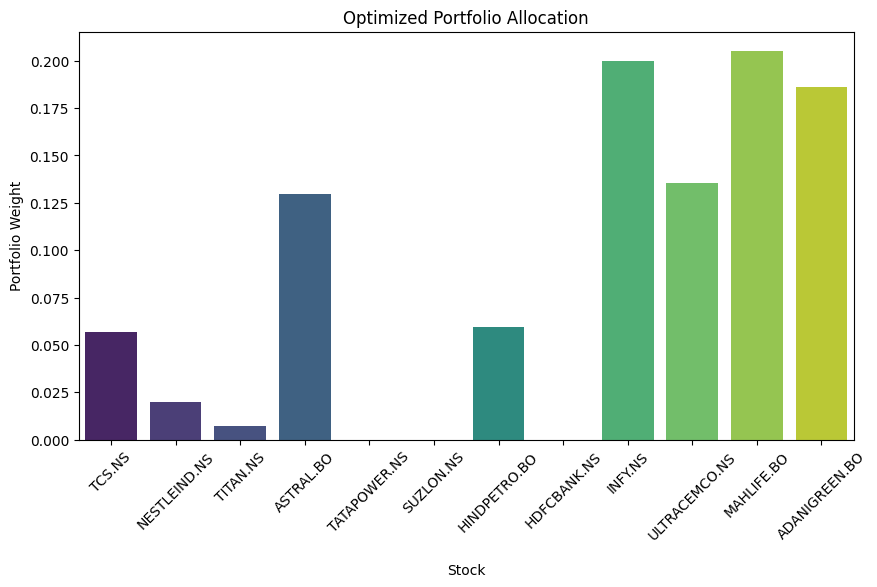

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for portfolio allocation
portfolio_df = pd.DataFrame({
    'Stock': tech_list,
    'Weight': optimized_weights
})

# Add a dummy hue column
portfolio_df['Hue'] = portfolio_df['Stock']

# Define a color palette (you can customize it or use a built-in one)
colors = sns.color_palette("viridis", len(portfolio_df))

# Plot the optimized portfolio allocation
plt.figure(figsize=(10, 6))
sns.barplot(x='Stock', y='Weight', data=portfolio_df, hue='Hue', palette=colors, legend=False)
plt.title('Optimized Portfolio Allocation')
plt.ylabel('Portfolio Weight')
plt.xlabel('Stock', labelpad=15)  # Adjust the gap between labels and x-axis

# Rotate x-axis labels and adjust spacing
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.2)  # Adjust bottom space to accommodate rotated labels

plt.show()


In [ ]:


# Lists to store predicted prices and close prices of the previous day for all stocks
predicted_prices_list = []
previous_close_prices_list = []

# Assuming `stocks` is a list of DataFrames for each stock and `tech_list` contains stock names
for i, df in enumerate(stocks):
    stock_name = tech_list[i]  # Assuming tech_list contains the names of stocks
    print(f"Processing stock: {stock_name}")

    # Calculate additional indicators
    df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()
    df['EMA'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()
    df['MACD'] = ta.trend.MACD(df['Close']).macd()
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

    # Drop any rows with NaN values that result from the rolling mean or other indicators
    df.dropna(inplace=True)

    # Prepare the data
    data = df.filter(['Close', 'RSI', 'EMA', 'MACD', 'VWAP'])
    dataset = data.values
    training_data_len = int(np.ceil(len(dataset) * .98))

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Save the scaler to a file
    joblib.dump(scaler, f'scaler_{stock_name}.pkl')

    # Create the training data set
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []

    for j in range(100, len(train_data)):
        x_train.append(train_data[j-80:j, :])  # Include all features
        y_train.append(train_data[j, 0])  # Predict the Close price

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=1)

    # Create the testing data set
    test_data = scaled_data[training_data_len - 80:, :]
    x_test = []
    y_test = dataset[training_data_len:, 0]  # Actual close prices for testing

    for j in range(100, len(test_data)):
        x_test.append(test_data[j-80:j, :])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

    # Get the model's predicted price values
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

    # Calculate RMSE
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print(f"RMSE for {stock_name}: {rmse:.4f}")

    train = data[:training_data_len]
    valid = data[training_data_len:].copy()  # Make a copy of valid

    # Assign predictions
    valid['Predictions'] = predictions

    # Calculate trends and matching trends for the last 50 rows
    valid['Close_Trend'] = valid['Close'].diff().apply(lambda x: 1 if x > 0 else 0)
    valid['Prediction_Trend'] = valid['Predictions'].diff().apply(lambda x: 1 if x > 0 else 0)
    
    # Focus only on the last 50 rows
    valid_last_50 = valid.tail(50).copy()
    valid_last_50['Trend_Same'] = (valid_last_50['Close_Trend'] == valid_last_50['Prediction_Trend']).astype(int)
    
    # Count matching trends for the last 50 rows
    same_trend_count_last_50 = valid_last_50['Trend_Same'].sum()

    # Print the trimmed valid DataFrame
    print(f"\n{'='*50}\nLast 50 rows for {stock_name}:\n")
    print(tabulate(valid_last_50, headers='keys', tablefmt='fancy_grid'))

    # Display the number of matching trends for the last 50 rows
    print(f"\nNumber of matching trends for the last 50 rows of {stock_name}: {same_trend_count_last_50}")

    # Plot the results
    plt.figure(figsize=(16, 6))
    plt.title(f'Model for {stock_name}')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price', fontsize=18)
    plt.plot(train['Close'], label='Train', color='blue')
    plt.plot(valid['Close'], label='Validation', color='orange')
    plt.plot(valid['Predictions'], label='Predictions', color='green')
    plt.legend(loc='lower right')
    plt.show()

    # Predict the next day's price
    last_100_days = scaled_data[-80:]
    last_100_days = np.reshape(last_100_days, (1, last_100_days.shape[0], last_100_days.shape[1]))
    future_pred = model.predict(last_100_days)
    future_pred = scaler.inverse_transform(np.concatenate((future_pred, np.zeros((future_pred.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

    # Store the predicted price and previous day's close price
    predicted_prices_list.append(future_pred[0])
    previous_close_prices_list.append(df['Close'].iloc[-1])


In [ ]:


# Lists to store predicted prices and close prices of the previous day for all stocks
predicted_prices_list = []
previous_close_prices_list = []

# Assuming `stocks` is a list of DataFrames for each stock and `tech_list` contains stock names
for i, df in enumerate(stocks):
    stock_name = tech_list[i]  # Assuming tech_list contains the names of stocks
    print(f"Processing stock: {stock_name}")

    # Calculate additional indicators
    df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()
    df['EMA'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()
    df['MACD'] = ta.trend.MACD(df['Close']).macd()
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

    # Drop any rows with NaN values that result from the rolling mean or other indicators
    df.dropna(inplace=True)

    # Prepare the data
    data = df.filter(['Close', 'RSI', 'EMA', 'MACD', 'VWAP'])
    dataset = data.values
    training_data_len = int(np.ceil(len(dataset) * .98))

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Save the scaler to a file
    joblib.dump(scaler, f'scaler_{stock_name}.pkl')

    # Create the training data set
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []

    for j in range(100, len(train_data)):
        x_train.append(train_data[j-120:j, :])  # Include all features
        y_train.append(train_data[j, 0])  # Predict the Close price

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=1)

    # Create the testing data set
    test_data = scaled_data[training_data_len - 120:, :]
    x_test = []
    y_test = dataset[training_data_len:, 0]  # Actual close prices for testing

    for j in range(100, len(test_data)):
        x_test.append(test_data[j-80:j, :])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

    # Get the model's predicted price values
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

    # Calculate RMSE
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print(f"RMSE for {stock_name}: {rmse:.4f}")

    train = data[:training_data_len]
    valid = data[training_data_len:].copy()  # Make a copy of valid

    # Assign predictions
    valid['Predictions'] = predictions

    # Calculate trends and matching trends for the last 50 rows
    valid['Close_Trend'] = valid['Close'].diff().apply(lambda x: 1 if x > 0 else 0)
    valid['Prediction_Trend'] = valid['Predictions'].diff().apply(lambda x: 1 if x > 0 else 0)
    
    # Focus only on the last 50 rows
    valid_last_50 = valid.tail(50).copy()
    valid_last_50['Trend_Same'] = (valid_last_50['Close_Trend'] == valid_last_50['Prediction_Trend']).astype(int)
    
    # Count matching trends for the last 50 rows
    same_trend_count_last_50 = valid_last_50['Trend_Same'].sum()

    # Print the trimmed valid DataFrame
    print(f"\n{'='*50}\nLast 50 rows for {stock_name}:\n")
    print(tabulate(valid_last_50, headers='keys', tablefmt='fancy_grid'))

    # Display the number of matching trends for the last 50 rows
    print(f"\nNumber of matching trends for the last 50 rows of {stock_name}: {same_trend_count_last_50}")

    # Plot the results
    plt.figure(figsize=(16, 6))
    plt.title(f'Model for {stock_name}')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price', fontsize=18)
    plt.plot(train['Close'], label='Train', color='blue')
    plt.plot(valid['Close'], label='Validation', color='orange')
    plt.plot(valid['Predictions'], label='Predictions', color='green')
    plt.legend(loc='lower right')
    plt.show()

    # Predict the next day's price
    last_100_days = scaled_data[-120:]
    last_100_days = np.reshape(last_100_days, (1, last_100_days.shape[0], last_100_days.shape[1]))
    future_pred = model.predict(last_100_days)
    future_pred = scaler.inverse_transform(np.concatenate((future_pred, np.zeros((future_pred.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

    # Store the predicted price and previous day's close price
    predicted_prices_list.append(future_pred[0])
    previous_close_prices_list.append(df['Close'].iloc[-1])
